<h1 style='color:orange; font-weight:bold; text-align:center'>Time Series Forecasting of Ground-Level Ozone Concentration in Jakarta</h1>

## **1 Scenario**
While ozone in statosphere protects us from harmful utraviolet radiation from the sun by absobing some portion of the light, the ground-level ozone is not safe for human respiratory health. Exposure to ground-level ozone are associated with irritation in respiratory system for short-term and even lung cancer for long-term period ([Filippidou & Koukouliata, 2011]([umb.edu.pl/photo/pliki/progress-file/phs/phs_2011_2/144-155.pdf](https://www.umb.edu.pl/photo/pliki/progress-file/phs/phs_2011_2/144-155.pdf))). For this reason, understanding the fluctuation of ozone concentration in the ground level is crucial for individuals to maintain their respiratory health. Understanding and forecasting the fluctuation is also critical for designing environmental policies, including by Environmental Management Agency. This information helps the agency predict the pollutant spike and assist in providing health advisories.

In relation to this issue, this project aims to understand the long-term trend in ground-level ozone (O<sub>3</sub>) concentration. In Jakarta's context, ground-level ozone is the main contributor of air pollutants, especially ones achieving critical level more frequently than other pollutants such as PM10, PM25, and CO. Accurate predictions are required to forecast the concentration of the air pollutant for data-driven policy-making, and the central issue in the model building is how accurate time series models, e.g., ARIMA, Prophet, and RNN variants, forecast trend in air pollution.

To evaluate the time series model for forecasting ozone concentrations, RMSE will be utilized. RMSE focuses on large errors by penalizing them more heavily. Penalization of large deviations is required since the deviations represent critical health risk. In addition to the focus of RMSE on penalizing large deviations, RMSE is also more considered than, for example, MSE. Unlike MSE, RMSE uses the same scale as the variable of interest (ozone concentration in ppm), making the output easier to understand. For example, RMSE 10 directly represents on average the model's predictions are off by 10 ppm.

Dataset to build the time series models was obtained from [Pohan](https://www.kaggle.com/datasets/senadu34/air-quality-index-in-jakarta-2010-2021) on Kaggle. This dataset contains 11 columns, including date ranging between 2010 and 2023.
- `tanggal`: Date of the air quality index was recorded.
- `stasiun`: Monitoring station name
- `pm10`: Concentration of particular matter (PM) with a diameter of 10 micrometers or less ($\mu \text{g}/\text{m}^3$)
- `pm25`: Concentration of PM with a diameter of 2.5 micrometer or less (also referred as "fine particular matter", measured in $\mu \text{g}/\text{m}^3$)
- `so2`: Concentration of sulfur dioxide (parts per million, ppm)
- `co`: Concentration of carbon monoxide (parts per million, ppm)
- `o3`: Concentration of ozone (parts per million, ppm)
- `no2`: Concentration of nitrogen dioxide (parts per million, ppm)
- `max`: Max value recorded among pollutants for specific entry.
- `critical`: Pollutant with the highest concentration
- `category`: Air quality category based on column max.

In [734]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
plt.style.use('ggplot')
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from scipy.stats import shapiro
from scipy.stats import skew, kurtosis
from scipy.stats import mstats
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from prophet import Prophet
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm
from statsmodels.graphics.gofplots import qqplot
from sklearn.preprocessing import MinMaxScaler
from prophet.plot import add_changepoints_to_plot
import tensorflow as tf
from sklearn.metrics import mean_squared_error
from prophet.plot import plot_components_plotly
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan
import joblib

## **2 Initial Inspection and Exploration**
Section 2 deals with data quality check and treatment. This quality check will include basic inspection on the data types, number of observations and features, the rates of missing values and duplicates, the number of missing values, and the treatments when necessary. While the dataset contains multiple features, only dates and one more feature, concerning ground-level ozone concentration will be needed for forecasting the future values of the concentration in a long-term period (one year).

### **2.1 Basic Inspection**

In [735]:
# import dataframe
df = pd.read_csv('../data/ispu_dki_all.csv')

In [736]:
# create function to inspect df
def inspect_dataframe(df):
    summary = {
        'ColumnName': df.columns.values.tolist(),
        'Nrow': df.shape[0],
        'DataType': df.dtypes.values.tolist(),
        'NAPct': (df.isna().mean() * 100).round(2).tolist(),
        'DuplicatePct': (df.duplicated().sum()/len(df)*100).round(2),
        'UniqueValue': df.nunique().tolist(),
        'Sample': [df[col].unique() for col in df.columns]
    }
    return pd.DataFrame(summary)

In [737]:
# inspect dataframe
print(f'The dataframe contains {df.shape[0]} rows and {df.shape[1]} cols.')
print(f"- {len(df.select_dtypes(include='number').columns)} are numeric cols")
print(f"- {len(df.select_dtypes(include='O').columns)} are object cols")
inspect_dataframe(df)

The dataframe contains 4626 rows and 11 cols.
- 7 are numeric cols
- 4 are object cols


ColumnName  Nrow DataType  NAPct  DuplicatePct  UniqueValue  \
0     tanggal  4626   object   0.00           0.0         4626   
1     stasiun  4626   object   0.00           0.0            5   
2        pm10  4626  float64   3.46           0.0          131   
3        pm25  4626  float64  84.37           0.0          123   
4         so2  4626  float64   0.41           0.0           87   
5          co  4626  float64   0.17           0.0           94   
6          o3  4626  float64   0.11           0.0          264   
7         no2  4626  float64   0.17           0.0           75   
8         max  4626  float64   0.00           0.0          244   
9    critical  4626   object   0.02           0.0            6   
10   categori  4626   object   0.00           0.0            6   

                                               Sample  
0   [2010-01-01, 2010-01-02, 2010-01-03, 2010-01-0...  
1   [DKI1 (Bunderan HI), DKI2 (Kelapa Gading), DKI...  
2   [60.0, 32.0, 27.0, 22.0, 25.0, 30.0, 41.0, 64....  
3   [nan, 60.0, 126.0, 70.0, 53.0, 59.0, 51.0, 55....  
4   [4.0, 2.0, 3.0, 8.0, 5.0, 10.0, 6.0, 7.0, 9.0,...  
5   [73.0, 16.0, 19.0, 17.0, 22.0, 24.0, 51.0, 39....  
6   [27.0, 33.0, 20.0, 15.0, 19.0, 23.0, 26.0, 9.0...  
7   [14.0, 9.0, 6.0, 8.0, 11.0, 13.0, 15.0, 16.0, ...  
8   [73.0, 33.0, 27.0, 22.0, 25.0, 30.0, 41.0, 64....  
9                 [CO, O3, PM10, NO2, SO2, PM25, nan]  
10  [SEDANG, BAIK, TIDAK SEHAT, SANGAT TIDAK SEHAT...

**Note**
- The dataset contains 4,626 observations and 11 cols in which 7 of them are float and four are objects. However, it is necessary to point out that `tanggal` is misidentified as an object so a conversion to datetime will be necessary for time series forecasting.
- The dataset does not contain any duplicates but there are some missing values in several features such as `pm10`, `pm25`, `so2`, `co`, `o3`, `no2`, and `critical`. Other than `o3`, the missing values can be ignored because these features are not directly relevant for the goal of the current project. For the `o3`, the missing values can be addressed using an interpolation. The small rate of missing values shoould not affect the distribution much when the missing values are handled with the technique.

In [738]:
# convert to datetime
df['tanggal'] = pd.to_datetime(df['tanggal'], format='%Y-%m-%d')
df['tanggal'].dtype

dtype('<M8[ns]')

**Note**: The feature `tanggal` represents the date when the ozone concentration was measured and recorded. And here, the date order is YYYY-MM-DD so the format `%Y-%m-%d` was used as the parameter to convert the feature into the desired format.

### **2.2 Feature Selection**
There are many ways of doing feature selection such as ANOVA F-test or Mutual Information (filter methods). Alternatively, embedded methods, e.g., L1/L2 regularization or tree-based feature importance, can also generally be implemented. Nonetheless, in this case, I rely on domain knowledge since univariate time series forecasting only needs one feature in addition to time series (`tanggal`), which feature to choose has been specifically determined in the beginning of this project, namely `o3`, representing the concentration of ground-level ozone (ar pollutant).

The selection of this air pollutant is also clarified here by identifying the criticality of air pollution and how it contributes to the unhealthiness of respiratory system. The identification is done by comparing different air pollutants (i.e., O3, PM10, PM25, CO, NO2, and SO2) based on their critical status and air quality status. For the record, critical status denotes which air pollutant achieves the critical level, and air quality status refers to safe or unsafe status to human based on the concentration of the pollutant.

In [739]:
# prepare data
critical_df = df['critical'].value_counts().reset_index(name='count')
critical_unhealthy_df = (df[df['categori'] == 'SANGAT TIDAK SEHAT']['critical']
                         .value_counts().reset_index(name='count'))

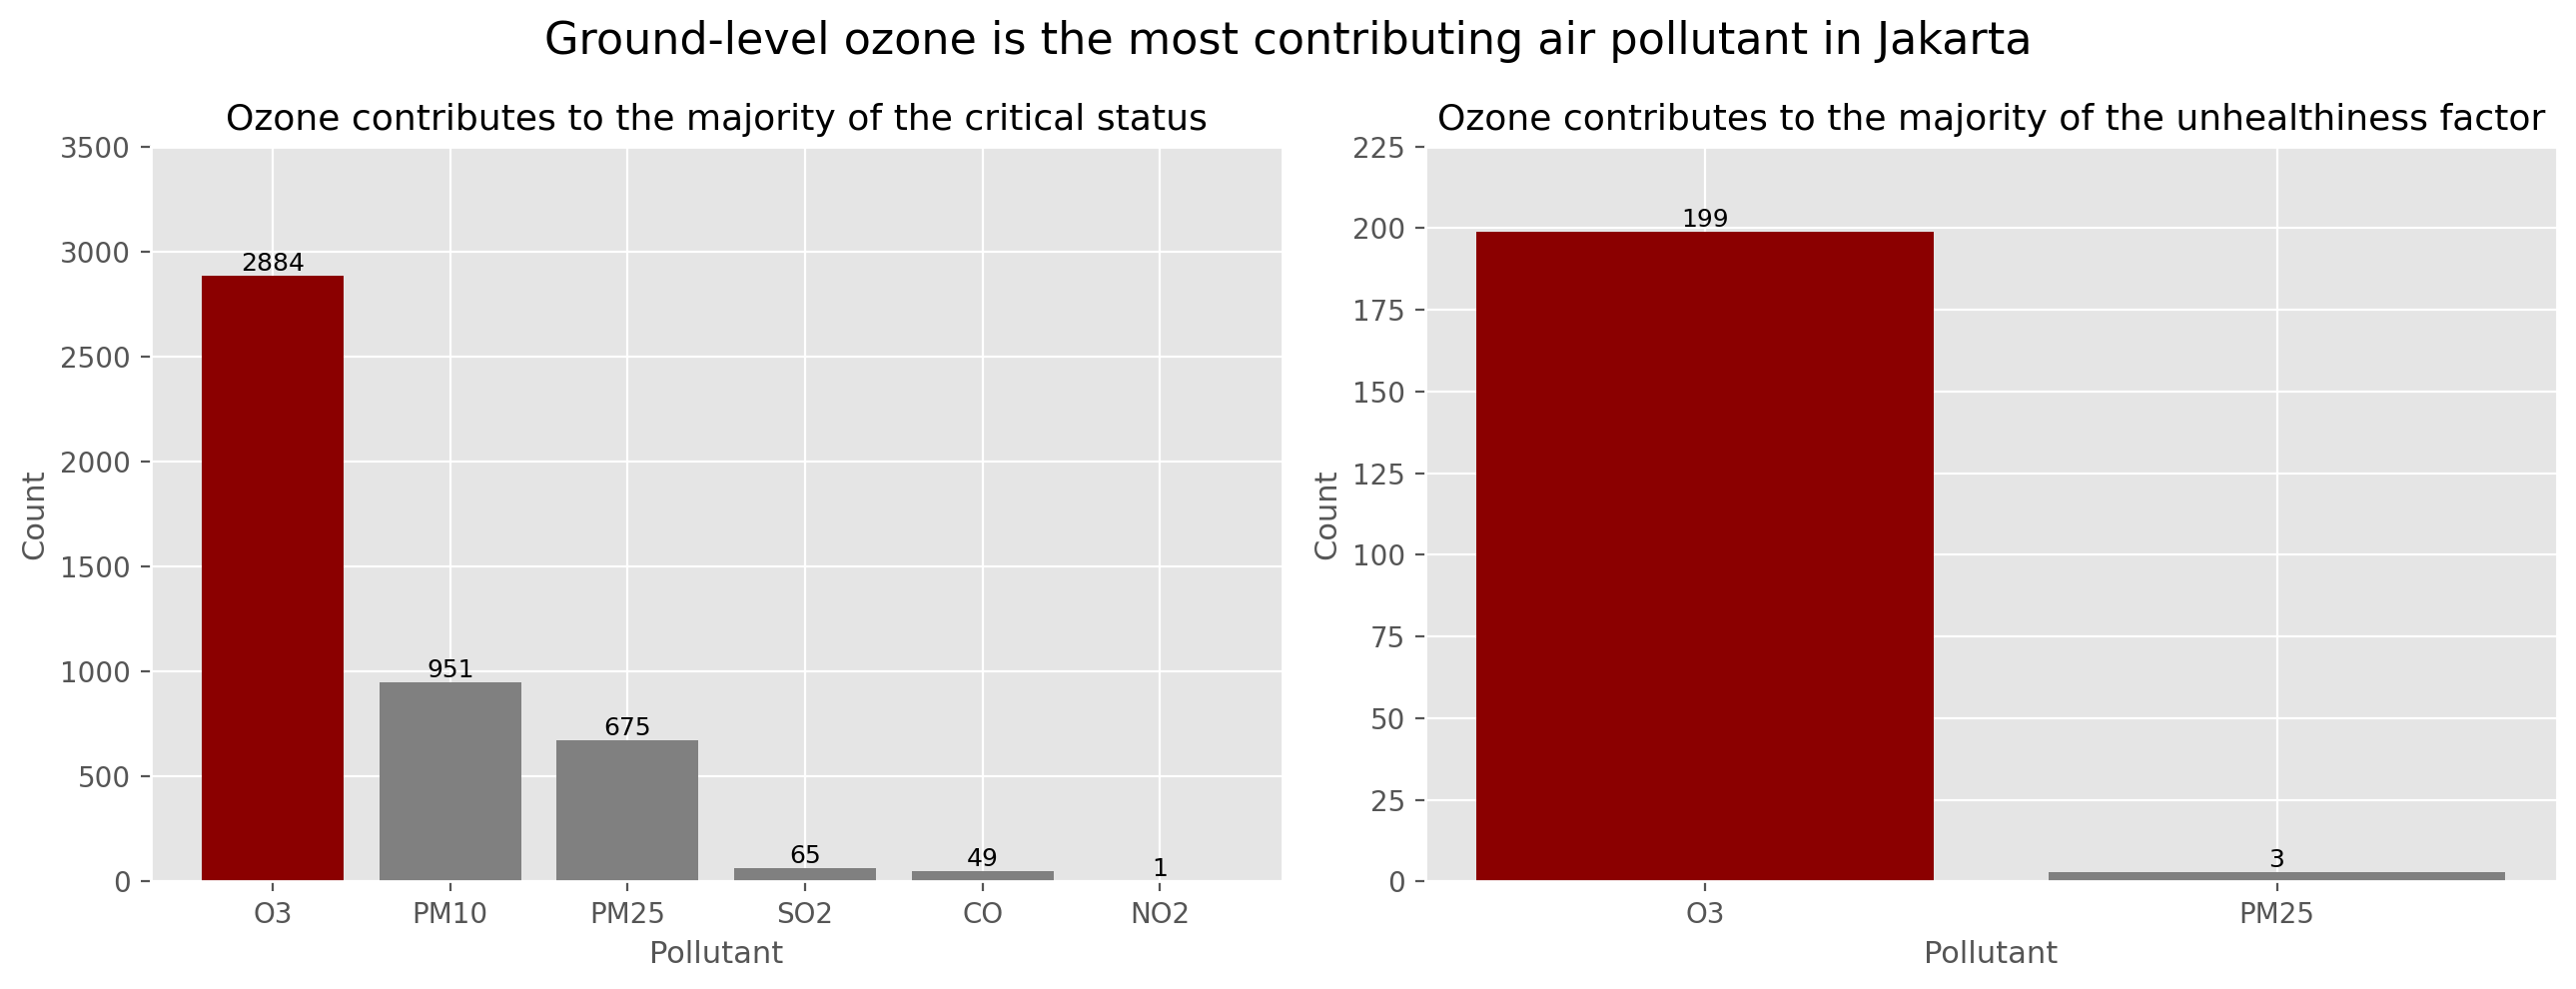

In [740]:
# create subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(13, 5), dpi=200)

# plot 1: critical factor
bars = (axes[0].bar(critical_df['index'], critical_df['count'], 
                    color=['darkred' if pollutant == 'O3' else 'grey' 
                           for pollutant in critical_df['index']]))

# add labels to plot 1
for bar in bars:
    yval = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom', size=9)

axes[0].set_xlabel('Pollutant', size=11)
axes[0].set_ylabel('Count', size=11)
axes[0].set_title('Ozone contributes to the majority of the critical status', size=13)
axes[0].set_ylim(0, 3500)
axes[0].set_xticks(range(len(critical_df['index'])))
axes[0].set_xticklabels(critical_df['index'], rotation=0)

# plot 2: unhealthiness factor
bars = (axes[1].bar(critical_unhealthy_df['index'], critical_unhealthy_df['count'], 
                    color=['darkred' if pollutant == 'O3' else 'grey' 
                           for pollutant in critical_unhealthy_df['index']]))

# add labels to plot 2
for bar in bars:
    yval = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom', size=9)

axes[1].set_xlabel('Pollutant', size=11)
axes[1].set_ylabel('Count', size=11)
axes[1].set_title('Ozone contributes to the majority of the unhealthiness factor', size=13)
axes[1].set_ylim(0, 225)
axes[1].set_xticks(range(len(critical_unhealthy_df['index'])))
axes[1].set_xticklabels(critical_unhealthy_df['index'], rotation=0)

plt.suptitle('Ground-level ozone is the most contributing air pollutant in Jakarta', size=16)
plt.tight_layout()
plt.show()

**Note**
- Two plots above represent a comparison between different air pollutants which has achived critical status and unsafe status for human.
- The plot on the left suggests that ground-level ozone is the most frequent contributor to air pollutant in Jakarta over time. It is the air pollutant which often achieved critical status. As can be seen the ground-level ozone has achieved critical status for 2,884 times, meaning that throughout the records, this air pollutant is almost twice (1.6 times) of the total air pollutant records.
- In addition to the citical status, ground-level ozone also the main contributor of healthy status of air quality in Jakarta since beng recorded here.
- For these two factors, ground-level ozone was selected for the forecasting in addition to feature `tanggal.

In [741]:
# select col and reinspect df
df = df.loc[:, ['tanggal', 'o3']]
inspect_dataframe(df)

ColumnName  Nrow        DataType  NAPct  DuplicatePct  UniqueValue  \
0    tanggal  4626  datetime64[ns]   0.00           0.0         4626   
1         o3  4626         float64   0.11           0.0          264   

                                              Sample  
0  [2010-01-01T00:00:00.000000000, 2010-01-02T00:...  
1  [27.0, 33.0, 20.0, 15.0, 19.0, 23.0, 26.0, 9.0...

### **2.3 Handle Missing Values**
Fortunately, the missing value rate is low. As mentioned earlier, the percentage of missing value is 1.1%. Because there is only a small amount, there are several ways of handling this problem such as listwise deletion, median/mean imputation, last observation carried forward or next observation carried backward, and interpolation. In this project, interpolation will be implemented. In general, interpolation estimate the missing values based on the existing data points, especialy the neighboring ones (values next to the missing data). 

In this subsection, I will perform linear interpolation and evaluate the output of the interpolation by comparing the descriptive statistics of the feature before and after the interpolation. The desired result is that the descriptive statistics before and after the implementation of the linear interpolation is alike. Otherwise, other interpolation methods such as polynomial or trigonometric interpolation can be experimented.

In [742]:
# impute data with interpolation
df['o3_int'] = df['o3'].interpolate(method='linear')

# compare distribution
df[['o3', 'o3_int']].describe().transpose().round(2)

count   mean    std  min   25%   50%    75%    max
o3      4621.0  86.59  50.30  0.0  51.0  78.0  110.0  314.0
o3_int  4626.0  86.51  50.32  0.0  51.0  78.0  110.0  314.0

**Note**
- In general, the comparison between before and after linear interpolation being implemented shows that the distribution of the ground-level ozone concentration does not change much. While the number of counts increase by 4 records and slight changes in the means and the standard deviations, the overall distributions, including mean, median, and max values remain the same. For this reason, there is no need to try out other interpolation methods.
- Next, because I want to keep the original name of the feature the same, I will drop the original feature (before data imputation) and rename the interpolated feature (feature with no missing values) to `o3`.

In [743]:
# rename o3_int to o3
df.drop(columns='o3', inplace=True)
df.rename(columns={'o3_int':'o3'}, inplace=True)
df.head()

tanggal    o3
0 2010-01-01  27.0
1 2010-01-02  33.0
2 2010-01-03  20.0
3 2010-01-04  15.0
4 2010-01-05  15.0

### **2.4 Check Distribution of Ozone Concentration**
Checking data distribution provides an understanding of the characteristics of the data. By visualizing or computing the skewness and the kurtosis, general patterns of the data spread, including extreme cases, can be identified. This can assist whether a further investigation and removal will be necessary. In addition to anomalies, errors in measurement can also be detected. For example, it is not possible for the values of ozone concentration to be lower than zero. Checking data distribution either visually or numerically informs if such errors are present. 

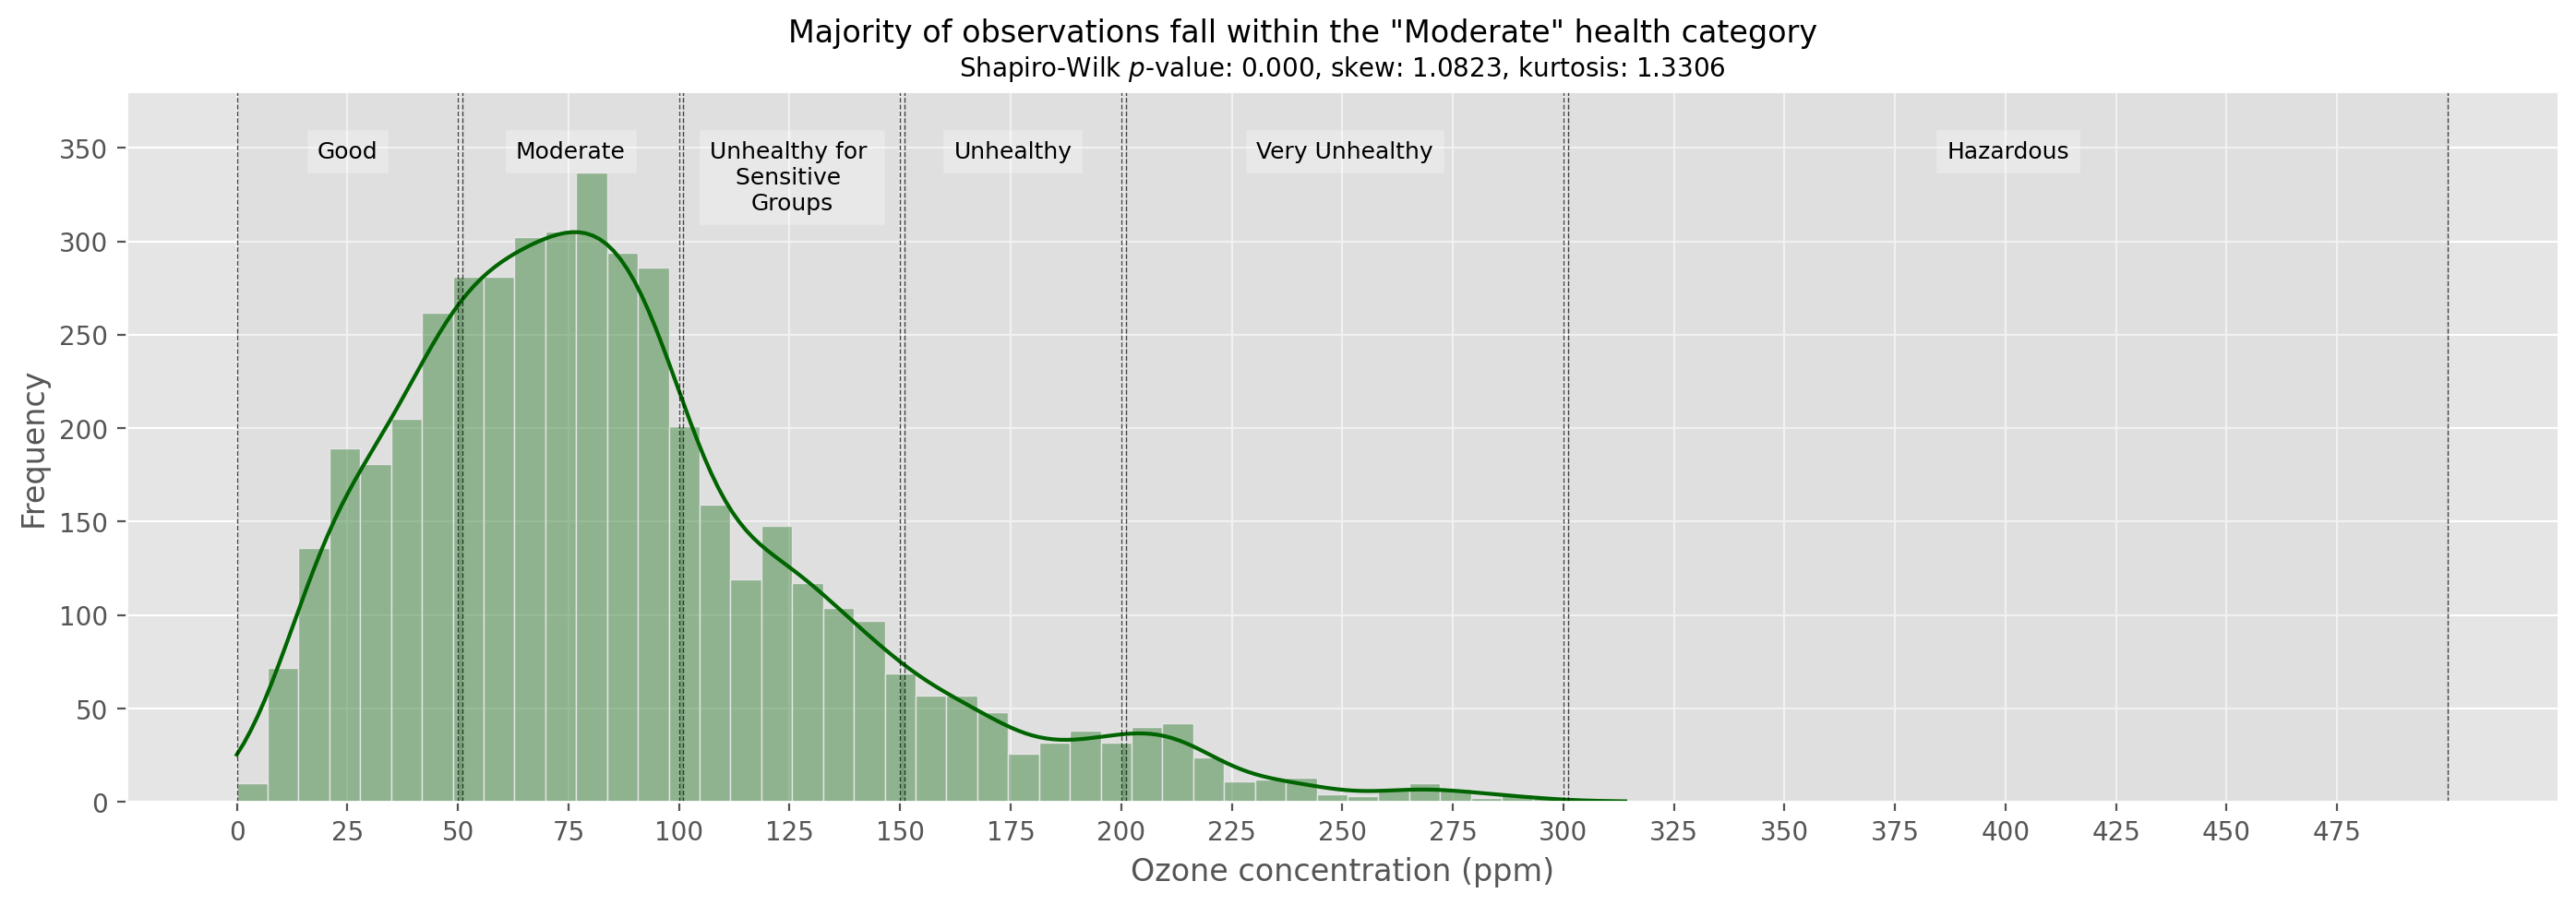

In [744]:
# define concentration & health impact categories
categories = {
    'Good': (0, 50),
    'Moderate': (51, 100),
    'Unhealthy for \nSensitive \nGroups': (101, 150),
    'Unhealthy': (151, 200),
    'Very Unhealthy': (201, 300),
    'Hazardous': (301, 500)
}

# calculate statistical measures
kurt_value = kurtosis(df['o3'])
skw_value = skew(df['o3'])
stat, p_value = shapiro(df['o3'])

# plot histogram
plt.figure(figsize=(17, 5), dpi=200)
sns.histplot(x=df['o3'], kde=True, color='darkgreen')

# annotate categories with vertical lines and shaded areas
for i, (label, (low, high)) in enumerate(categories.items()):
    plt.axvline(x=low, color='black', linestyle='--', linewidth=0.5, alpha=0.7)
    plt.axvline(x=high, color='black', linestyle='--', linewidth=0.5, alpha=0.7)
    plt.axvspan(low, high, color='lightgray', alpha=0.3)
    plt.text((low + high) / 2, plt.ylim()[1] * 1, label,
             horizontalalignment='center', verticalalignment='top',
             fontsize=9, color='black', bbox=dict(facecolor='white', alpha=0.3))

# add title and labels
plt.title(f'Shapiro-Wilk $p$-value: {p_value:.3f}, skew: {skw_value:.4f}, kurtosis: {kurt_value:.4f}', 
          size=10, color='black')
plt.suptitle('Majority of observations fall within the "Moderate" health category', y=0.96)
plt.xlabel('Ozone concentration (ppm)')
plt.ylabel('Frequency')
plt.xticks(range(0, 500, 25))
plt.ylim(0, 380)
plt.show()


**Note**
- In general, the distribution of the ozone concentration in Jakarta is not normal as indicated by the *p*-value of Shapiro-Wilk test lower than 0.05. The skewness value here represents the shape of the distribution which is positively skewed due to the presence of outliers in the right-end of the distribution. In addition to the *p*-value and the skewness, the kurtosis value suggests that the distribution has heavy tail (leptokurtic). Leptokurtic distribution also underscores the presence of outliers. Ideally, the desirable kurtosis value is 0, indicating mesokurtic or normal distribution.
- The central tendency of the ozone concentration falls within moderate health category. As can be seen on the descriptive statistical test output, despite discrepancy between mean and median values due to the skewed distribution, both median and mean remain falling within "moderate" category. This tenency indicates that overall, the ozone concentration in Jakarta is still normal or healthy for the majority of people.
- Some observations, especially the extreme cases, fall within the hazardous category. This signifies that in rare cases, the ozone concentration in the capital city can be hazardous to people's health. 

In [745]:
# compute descriptive statistics
df['o3'].describe().to_frame().transpose().round(2)

count   mean    std  min   25%   50%    75%    max
o3  4626.0  86.51  50.32  0.0  51.0  78.0  110.0  314.0

### **2.5 Check Outliers**
Outlier check is a follow-up on the data distribution check. As previously shown, some data points fall within category "Very Unhealthy" and "Hazardous". The presence of data points in these categories is indicative of outliers. Here, I use IQR-based outlier detection.

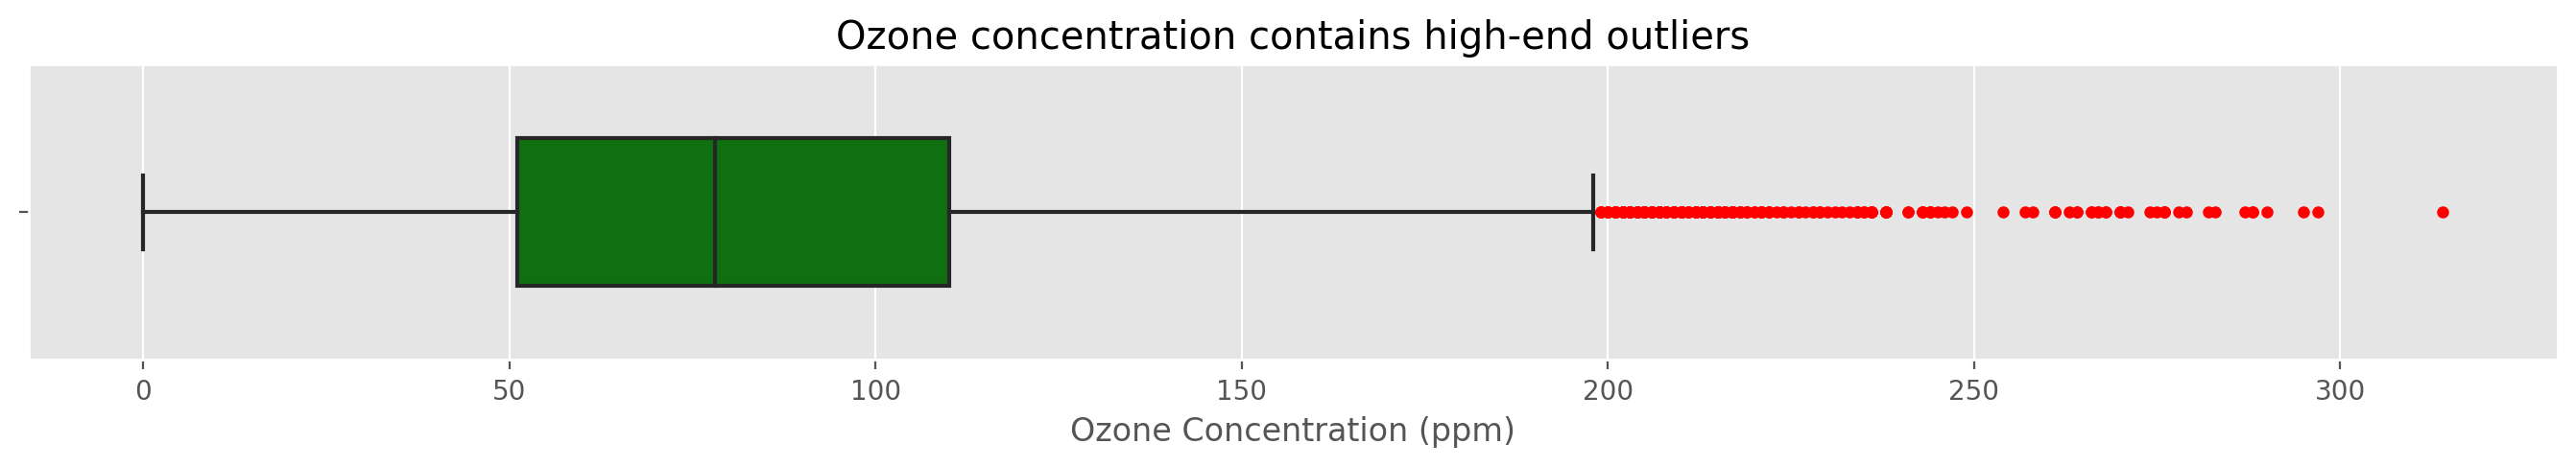

In [746]:
plt.figure(figsize=(17, 2), dpi=200)
sns.boxplot(x=df['o3'], color='green', width=0.5, 
            flierprops=dict(marker='.', markerfacecolor='red', 
                            markeredgecolor='red', alpha=1, 
                            markersize=7))

plt.title('Ozone concentration contains high-end outliers')
plt.xlabel('Ozone Concentration (ppm)')
plt.show()

In [747]:
Q1 = df['o3'].quantile(0.25)
Q3 = df['o3'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers = df.loc[(df['o3'] < lower_bound) | (df['o3'] > upper_bound)]
num_outliers = len(outliers)
total_rows = len(df)
print(f"The number of outliers is {num_outliers} or {(num_outliers / total_rows * 100):.2f}% of the total data ({total_rows} rows).")
display(outliers.sort_values(by='o3', ascending=False).head())

The number of outliers is 203 or 4.39% of the total data (4626 rows).


tanggal     o3
1035 2012-11-04  314.0
1036 2012-11-05  297.0
1002 2012-10-02  295.0
933  2012-07-25  290.0
1010 2012-10-10  288.0

**Note**
- There are 4.39% of data considered as outliers in the dataset. The outliers are generally records in 2012 in which the ozone concentration achieved the "Very Unhealthy" level or even "Hazardous" in 2012-11-04. 
- Moreover, while the boxplot already tells the location of the outliers, confirming insights from the histogram, the boxplot does not inform the number of outliers which is critical for making decision for the treatment.
- Given the outlier rate is moderate, winsorization or log-transformation can be chosen. Winsorization caps the extreme values to specific thresholds to reduce the impact of the outliers. Log-transformation, on the other hand, compresses the range of values. Listwise removal will be the last choice since this discards the records and the data size will decrease.
- But here, I consider winsorization more than log-transformation for several reasons. First, unlike log-transformation which uses log-scaled values, winsorization keeps the original range of values to preserve the data interpretability. Second, transformation can still be done if a further transformation is necessary. 

In [748]:
# cap the outliers
df['o3'] = mstats.winsorize(df['o3'], limits=[0, 0.05])

In [749]:
# create func to detect outliers
def detect_outliers(df, column_name):
    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df.loc[(df[column_name] < lower_bound) | (df[column_name] > upper_bound)]
    num_outliers = len(outliers)
    total_rows = len(df)
    print(f"The number of outliers is {num_outliers} or {(num_outliers / total_rows * 100):.2f}% of the total data ({total_rows} rows).")

In [750]:
# detect outliers
detect_outliers(df, 'o3')

The number of outliers is 0 or 0.00% of the total data (4626 rows).


### **2.6 Time Series Analysis**
This section seeks to investigate the systematicity or consistency of ozone concentration over time using time series decomposition. In general, time series consists of four components, namely level, trend, seasonality, and noise. Level represents the observed values for the data. Trend is a general pattern of the data. Seasonality denotes repeating seasonal patterns (cycles) over time. And last, noise is variability in the observation.

In [751]:
# perform seasonal decomposition
decompose_result = (seasonal_decompose(df.set_index('tanggal')['o3'], 
                                       model='additive', period=30))

**Note**: To perform time series decomposition, an additive model was used. Linear model was chosen over multiplicative one since there are some records whose ozone concentration is zero, causing an error. 

$$y(t)=\text{Level}+ \text{Trend} + \text{Seasonality} + \text{Noise}$$

#### **2.6.1 Observed Values**

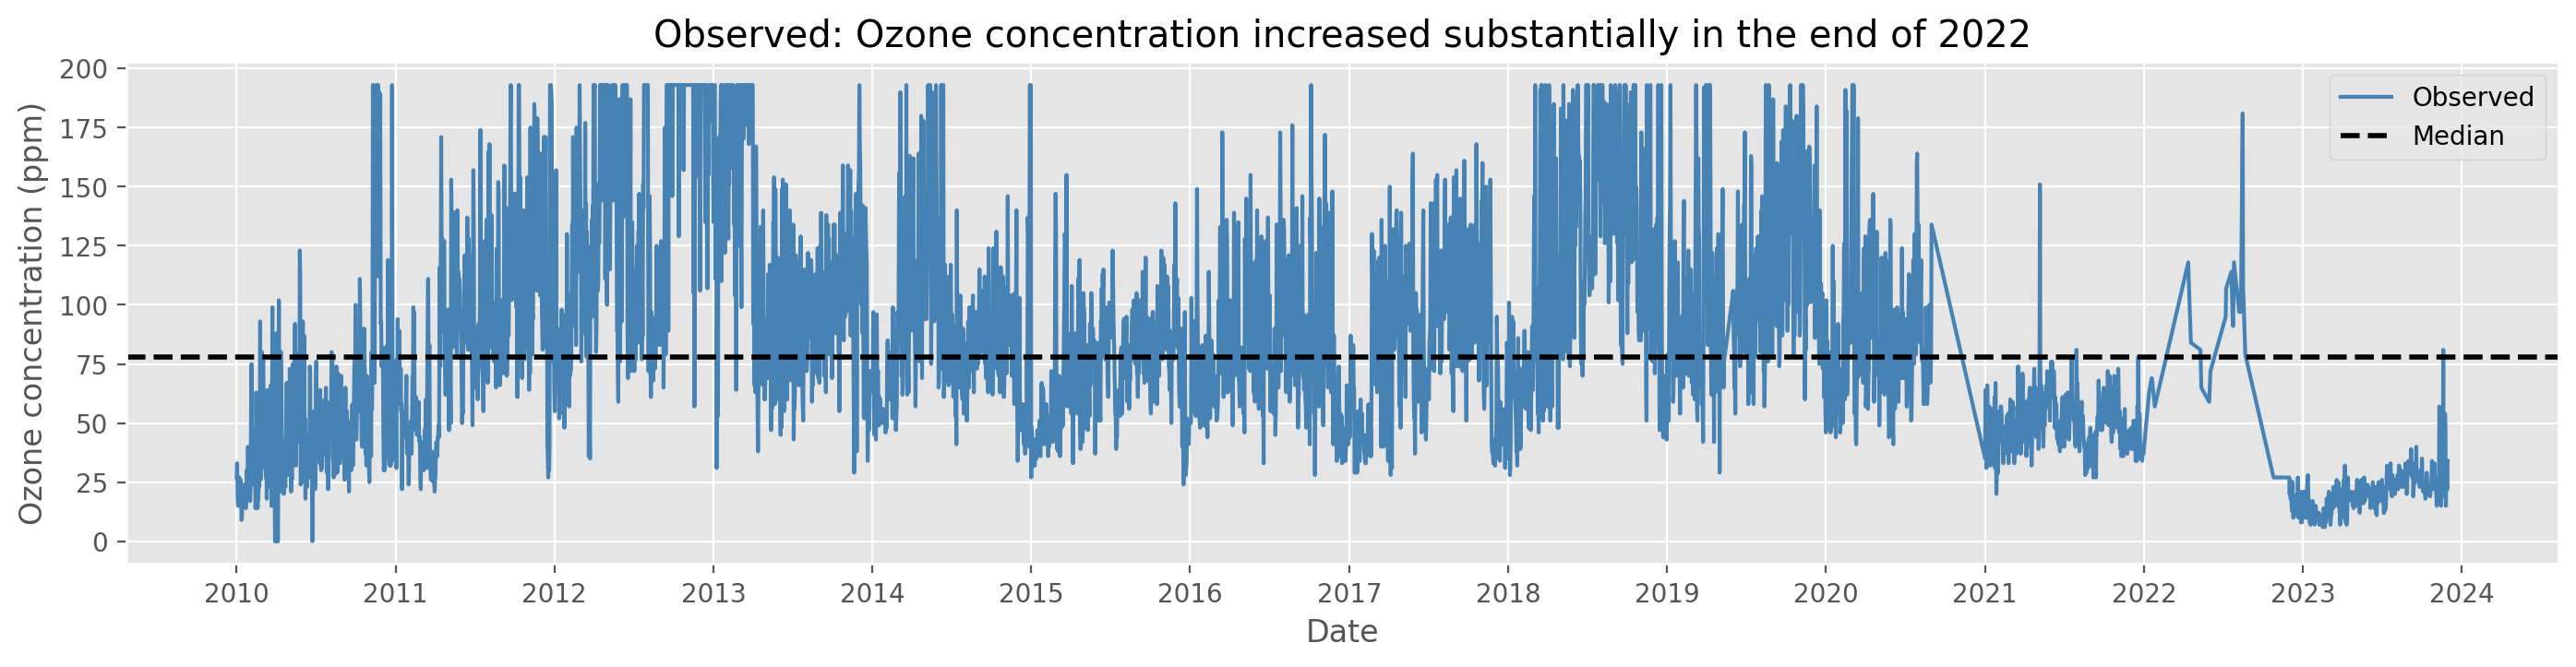

In [752]:
# plot observed values
plt.figure(figsize=(17, 4), dpi=200)
decompose_result.observed.plot(legend=True, color='steelblue', label='Observed')
plt.axhline(y=df['o3'].median(), color='black', linestyle='--', linewidth=2, label='Median')
plt.title('Observed: Ozone concentration increased substantially in the end of 2022')
plt.xlabel('Date')
plt.ylabel('Ozone concentration (ppm)')
plt.xticks(rotation=0, ha='center')
plt.gca().xaxis.set_major_locator(mdates.YearLocator())             # set tick locations to every year
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))     # format ticks as year
plt.legend()
plt.show()

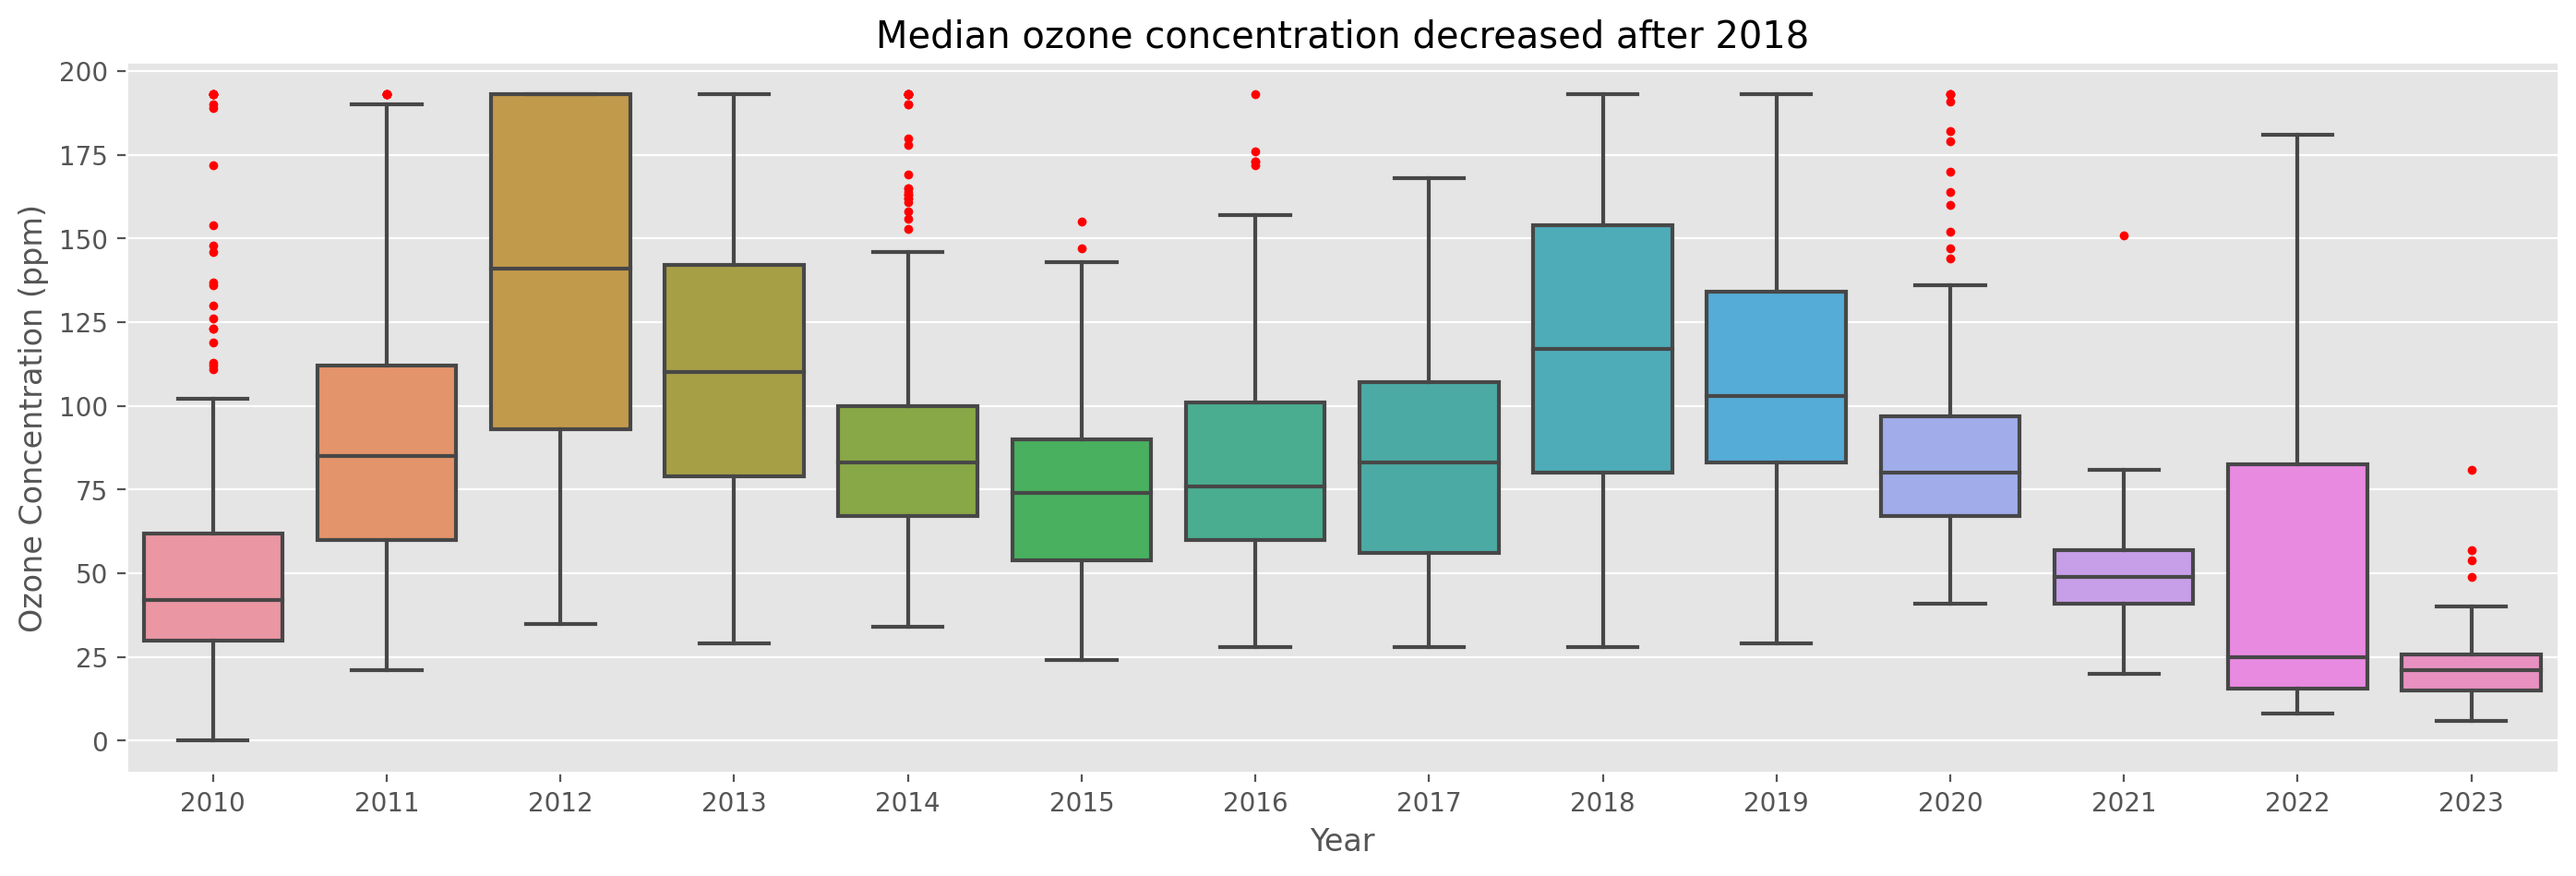

In [753]:
# extract year
df['year'] = df['tanggal'].dt.year

plt.figure(figsize=(17, 5), dpi=200)
sns.boxplot(x='year', y='o3', data=df,
            flierprops=dict(marker='.', markerfacecolor='red', 
                            markeredgecolor='red', alpha=1, 
                            markersize=5))
plt.title('Median ozone concentration decreased after 2018')
plt.xlabel('Year')
plt.ylabel('Ozone Concentration (ppm)')
plt.show()

**Note**
- The ozone concentration varies across  different years. Some years have higher median levels than others, especially in 2012 and 2018, indicating a greater overall concentration of ozone during those periods.
- Outliers remain present in the data when being subset annually. These outliers represent extreme concentrations significantly deviate from the typical values of a certain year.

#### **2.6.1 Trend in Ozone Concentration**

In [754]:
# subset 2012 data
subset2012 = decompose_result.trend.reset_index(name='o3')
subset2012 = subset2012[subset2012['tanggal'].dt.year==2012]

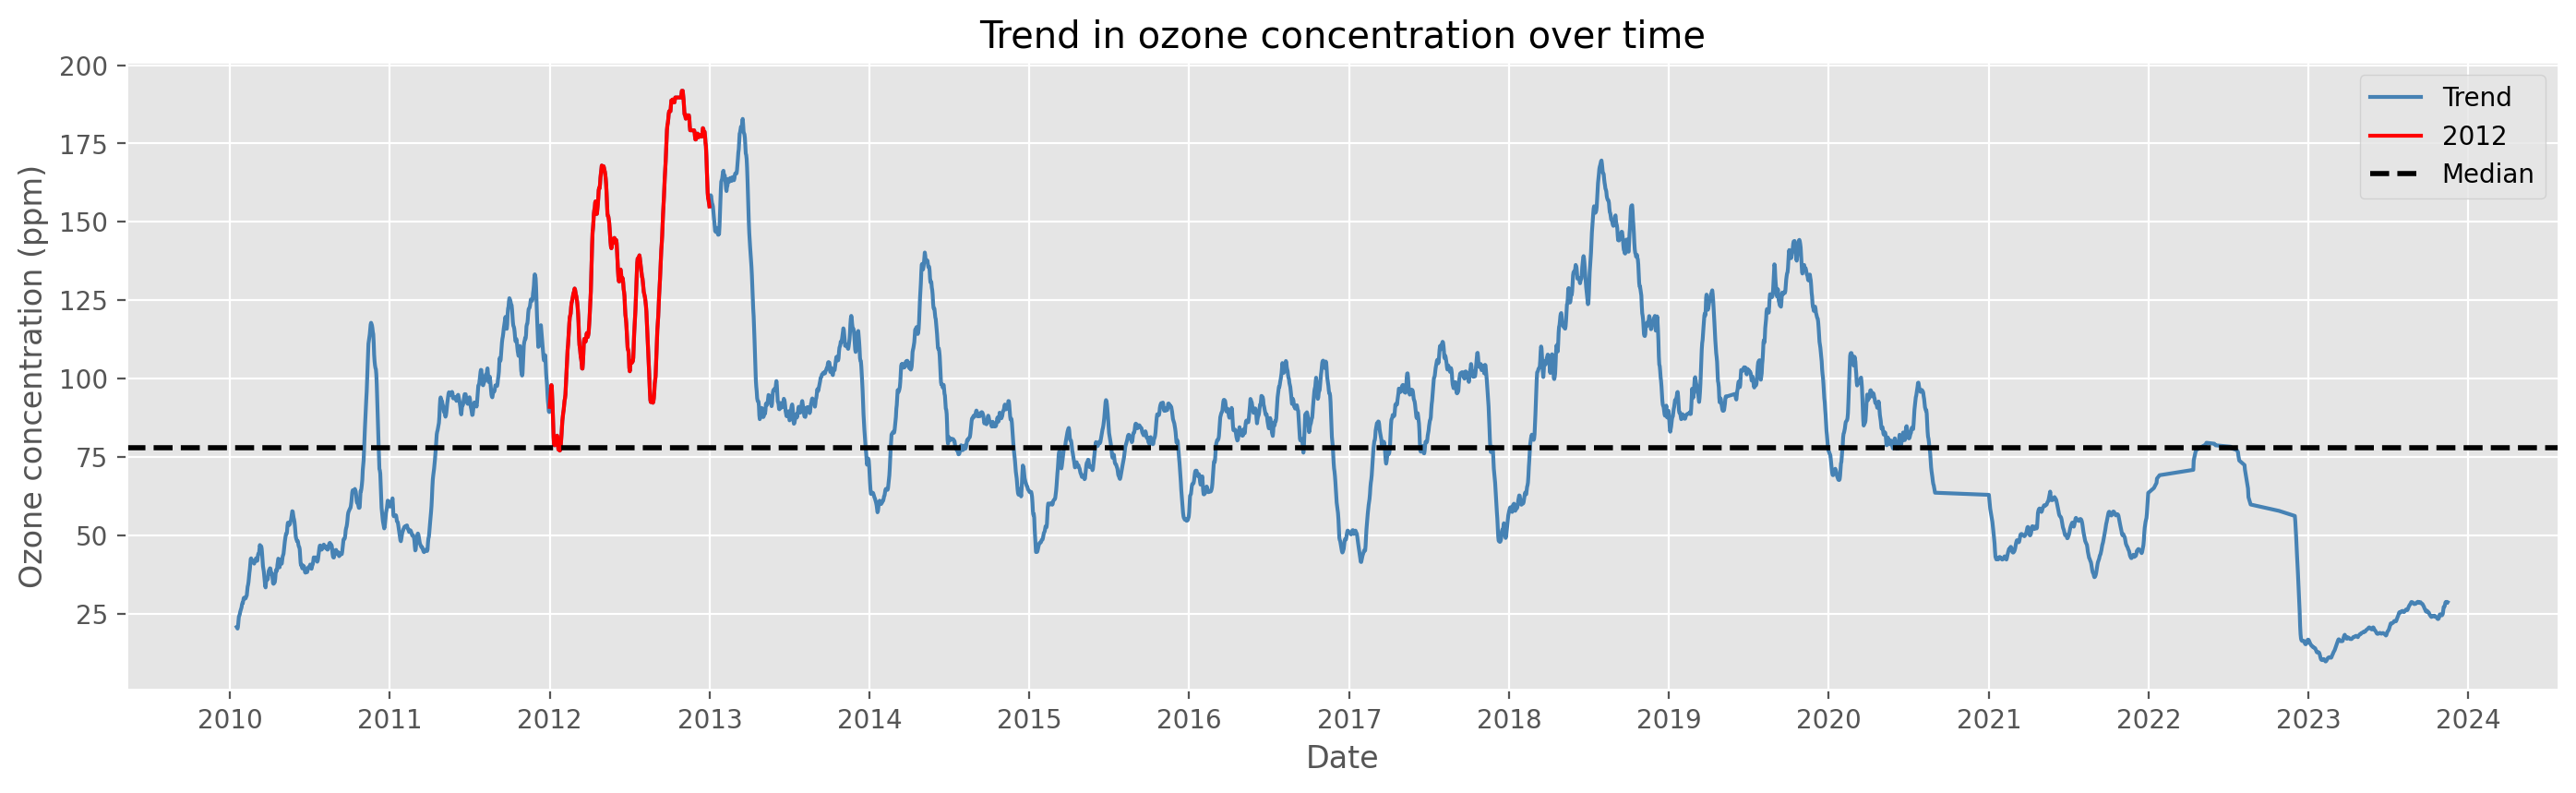

In [755]:
# plot trend
plt.figure(figsize=(17, 5), dpi=200)
decompose_result.trend.plot(legend=True, color='steelblue', label='Trend')
plt.plot(subset2012['tanggal'], subset2012['o3'], color='red', label='2012')
plt.axhline(y=df['o3'].median(), color='black', linestyle='--', linewidth=2, label='Median')
plt.title('Trend: No consistent trend in ozone concentration over time')
plt.title('Trend in ozone concentration over time')
plt.gca().xaxis.set_major_locator(mdates.YearLocator())          # set tick locations to every year
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # format ticks as year
plt.xlabel('Date')
plt.ylabel('Ozone concentration (ppm)')
plt.xticks(rotation=0, ha='center')
plt.legend()
plt.show()

**Note**
- The overall trend of ozone concentration in Jakarta seems to be stable over the years, except in 2012 in which the concentration increased substantially. A further analysis can provide more details on the spike in 2012.
- After the mid 2020, the ozone concentration in Jakarta indicates a downward trend. This might indicate the environmental effects of decreasing social activities after the discovery of the first coronavirus-19 on [Mar 2, 2020](https://news.detik.com/berita/d-5964691/kasus-corona-pertama-di-indonesia-ini-kilas-balik-usai-2-tahun-berlalu) in Indonesia.
- In addition to the significant spike in 2012, there seem no regular repeating cycles. 

In [756]:
# extract year and month
df['month'] = df['tanggal'].dt.month

# filter data for 2012
df_2012 = df[df['year'] == 2012]

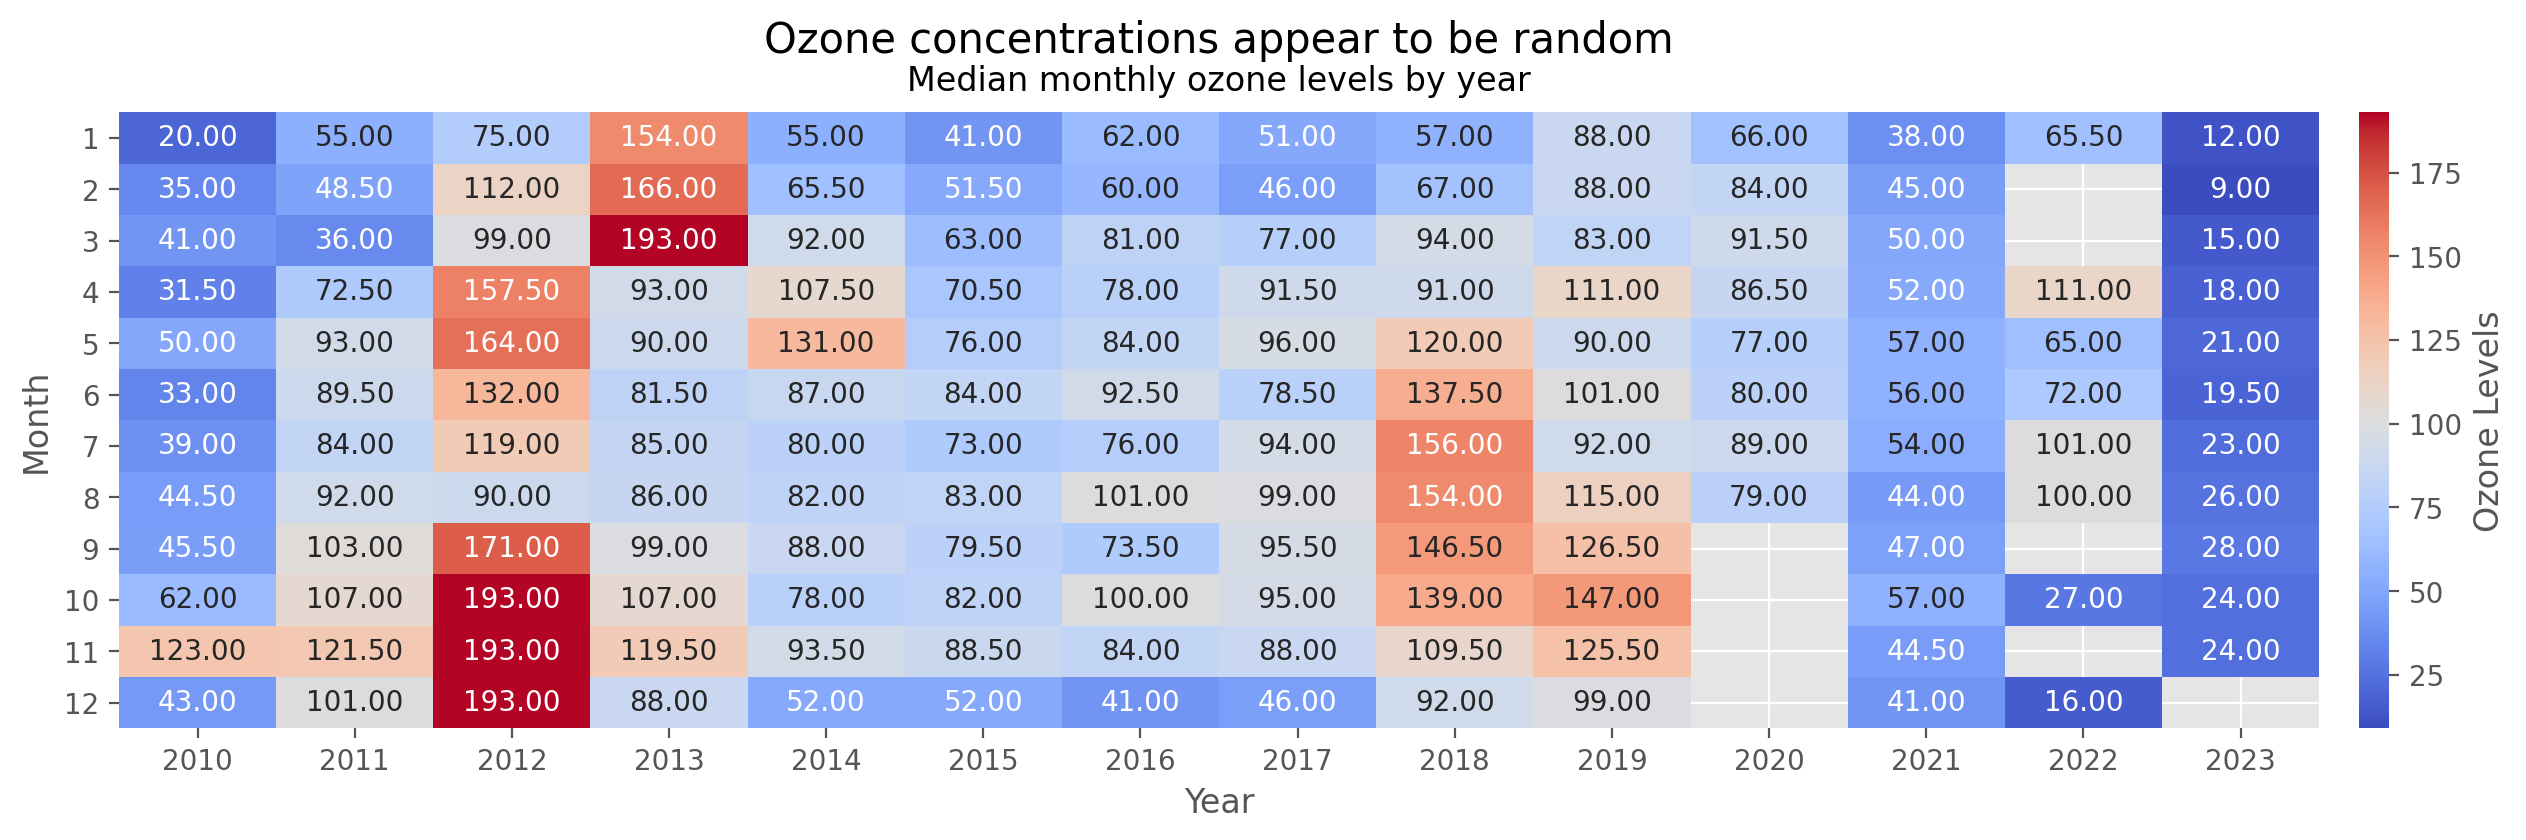

In [757]:
# Pivot the data to create a matrix of ozone levels by year and month
df_pivot = df.pivot_table(values='o3', index='month', columns='year', aggfunc='median')

# Create a heatmap
plt.figure(figsize=(17, 4), dpi=200)
sns.heatmap(df_pivot, annot=True, cmap='coolwarm', fmt=".2f", cbar_kws={'label': 'Ozone Levels', 'pad': 0.015})
plt.title('Ozone concentrations appear to be random', size=15, y=1.07)
plt.text(x=0.5, y=1.05, s='Median monthly ozone levels by year', 
         ha='center', va='center', size=12, transform=plt.gca().transAxes)
plt.yticks(rotation=0)
plt.xlabel('Year')
plt.ylabel('Month')
plt.show()


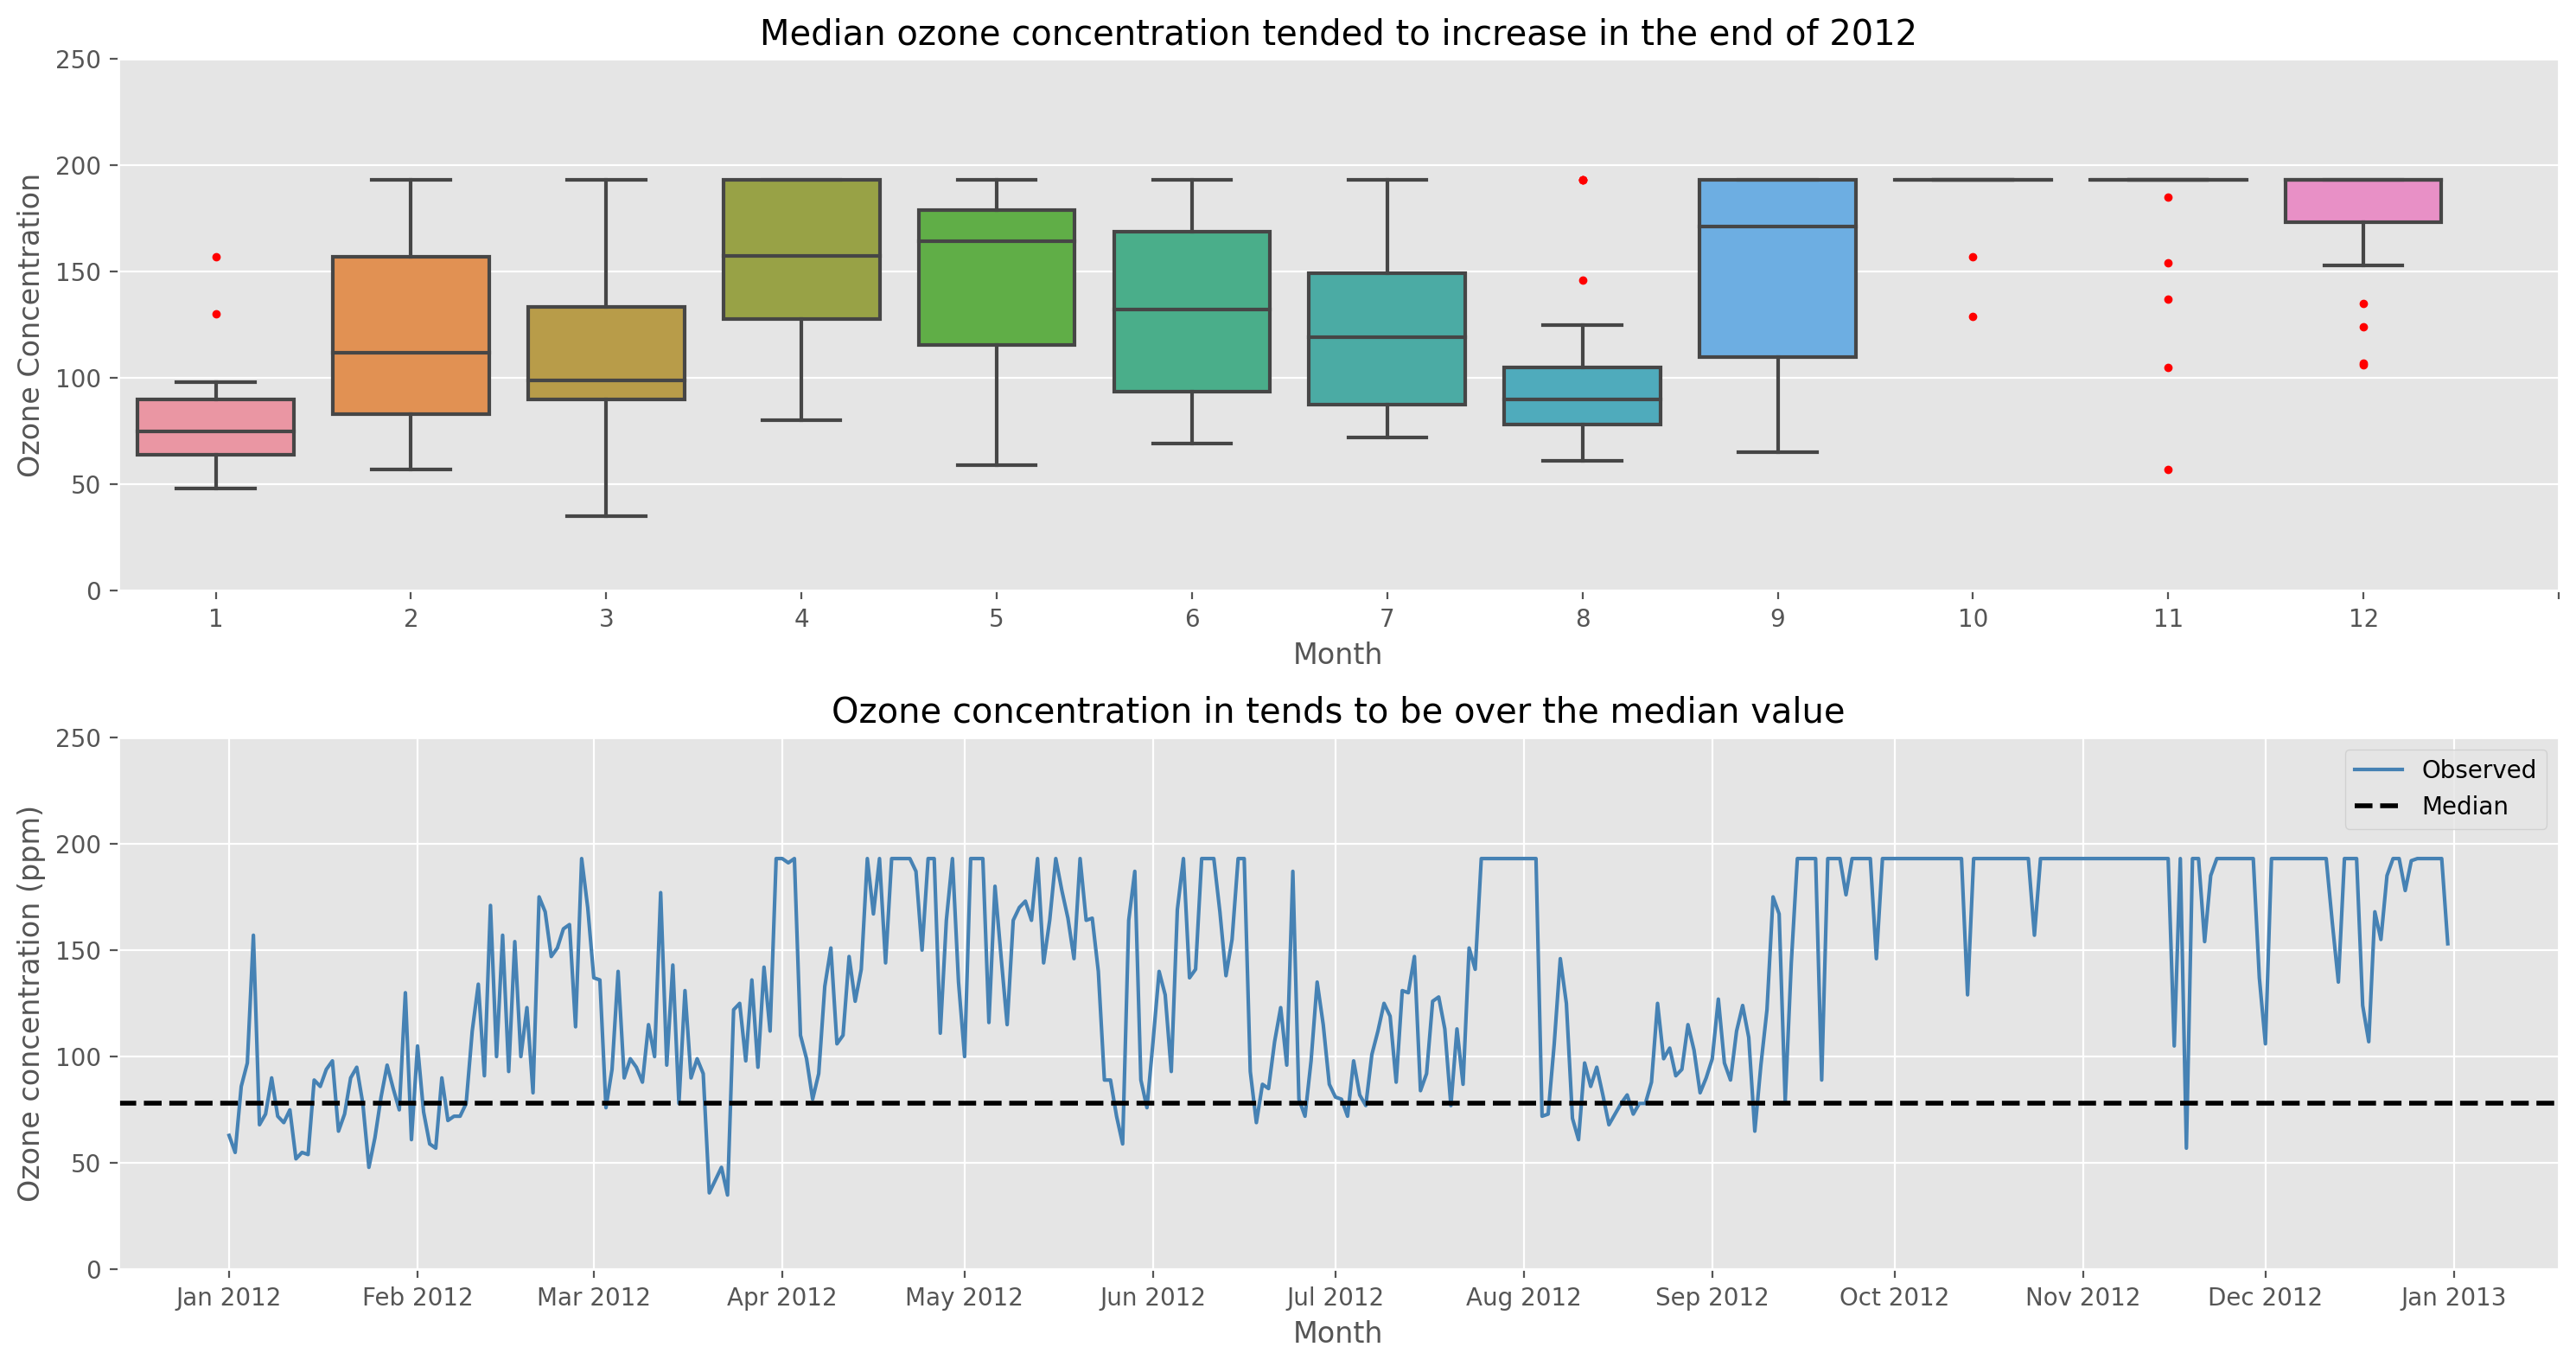

In [758]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(15, 8), dpi=200)

# plot the boxplot 
sns.boxplot(x='month', y='o3', data=df_2012,
            flierprops=dict(marker='.', markerfacecolor='red',
                            markeredgecolor='red', alpha=1, markersize=5),
            ax=ax1)
ax1.set_xlabel('Month')
ax1.set_ylabel('Ozone Concentration')
ax1.set_title('Median ozone concentration tended to increase in the end of 2012')
ax1.set_xticks(range(0, 13))
ax1.set_ylim(0, 250)

# plot the line chart 
ax2.plot(df_2012['tanggal'], df_2012['o3'], color='steelblue', label='Observed')
ax2.axhline(y=df['o3'].median(), color='black', linestyle='--', linewidth=2, label='Median')
ax2.set_xlabel('Month')
ax2.set_ylabel('Ozone concentration (ppm)')
ax2.set_title('Ozone concentration in tends to be over the median value')
ax2.set_ylim(0, 250)
ax2.legend()

# set x-ticks to display monthly
ax2.xaxis.set_major_locator(mdates.MonthLocator())             
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))    
plt.setp(ax2.get_xticklabels(), rotation=0, ha='center')       

plt.tight_layout()
plt.show()

**Note**
- The boxplots above represents the variability of ozone concentration in 2012. In general, the ozone concentration levels in 2012 are relatively high, especially compared to the overal median of 78 ppm.
- There is considerable variation in ozone levels across different months, especially an upward trend after Aug 2012. In these months, outliers in the lower distribution are also present, indicating while month-to-month variation tends to be increasing, ozone concentrations dropped in several days.
- Since there is no information about meterological variables such as temperature, humidity, and wind speed, it is not possible to explore possible causes of these factors on the ozone concentration on the near earth surface (not in the atmosphere).

#### **2.6.3 Seasonality**

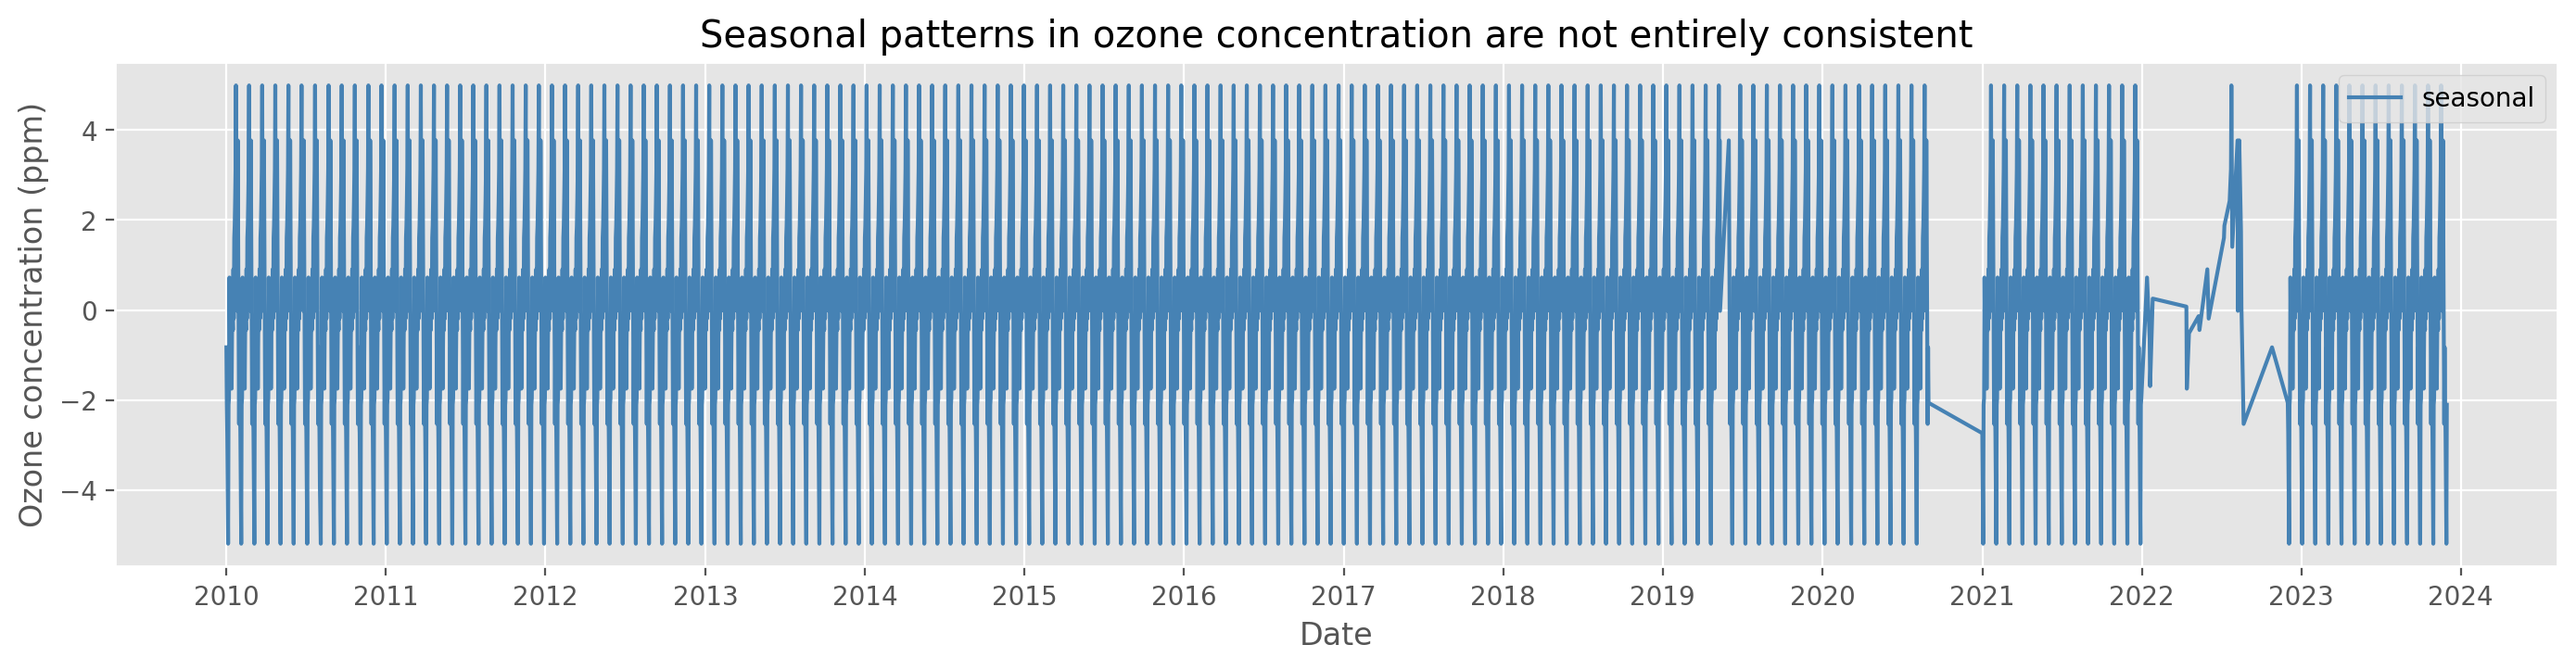

In [759]:
plt.figure(figsize=(17, 4), dpi=200)
decompose_result.seasonal.plot(legend=True, color='steelblue')
plt.title('Seasonal patterns in ozone concentration are not entirely consistent')
plt.xlabel('Date')
plt.ylabel('Ozone concentration (ppm)')
plt.gca().xaxis.set_major_locator(mdates.YearLocator())             # set tick locations to annual
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))     # format ticks as year

plt.xticks(rotation=0, ha='center')
plt.show()

**Note**
- The seasonal component of ozone concentration exhibits a clear periodic pattern, suggesting a strong seasonal influence on ozone levels.
- However, the seasonal fluctuations seem to be vary over time. This might suggest that the strength of seasonal influences may not be entirely consistent.
- The presence of a clear seasonal pattern indicate that ozone levels can be somewhat predicted based on the time of the year.
- The implication of this insight is on the consideration of Seasonal AutoRegressive Integrated Moving Average (SARIMA) over AutoRegressive Integrated Moving Average (ARIMA) for modeling time series data with seasonal patterns.

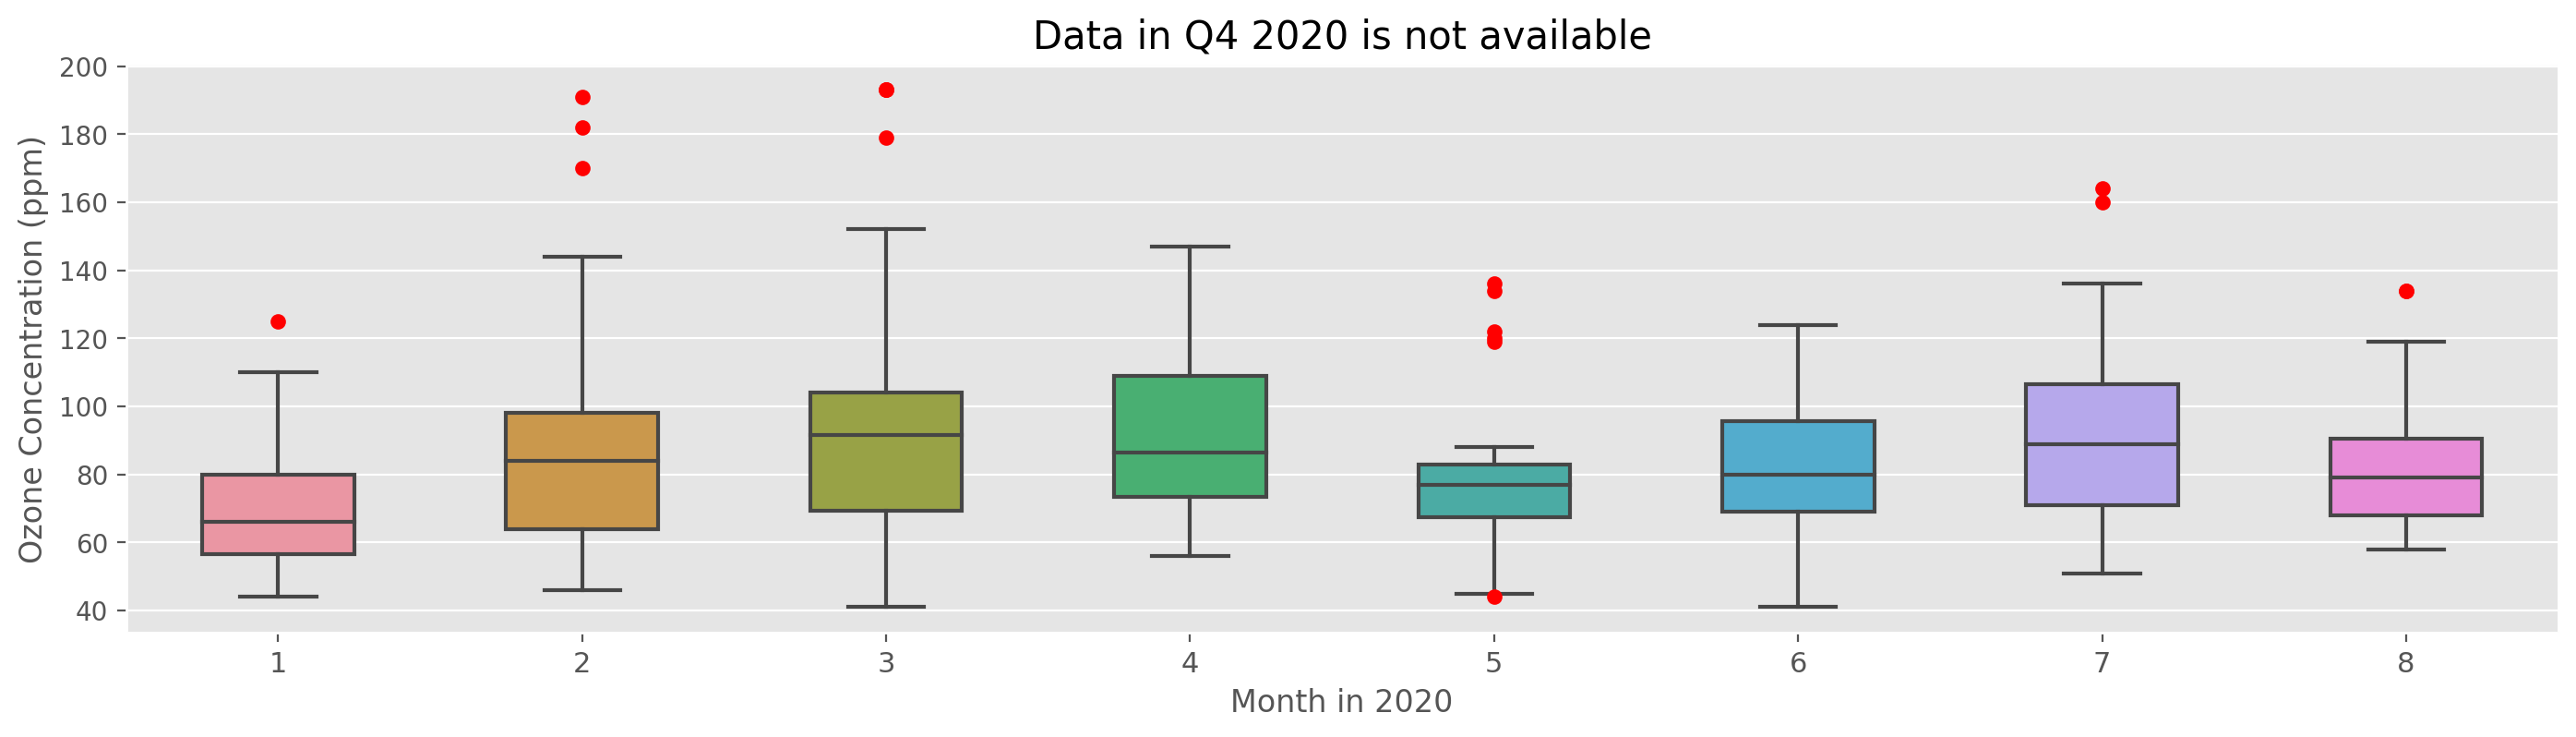

In [760]:
df_2020 = df[df['year'] == 2020]
plt.figure(figsize=(17, 4), dpi=200)
sns.boxplot(x='month', y='o3', data=df_2020, width=0.5,
            flierprops=dict(marker='.', markerfacecolor='red',
                            markeredgecolor='red', alpha=1, markersize=10))
plt.ylabel('Ozone Concentration (ppm)')
plt.xlabel('Month in 2020', size=12)
plt.title('Data in Q4 2020 is not available', size=15)
plt.xticks(size=11)
plt.show()

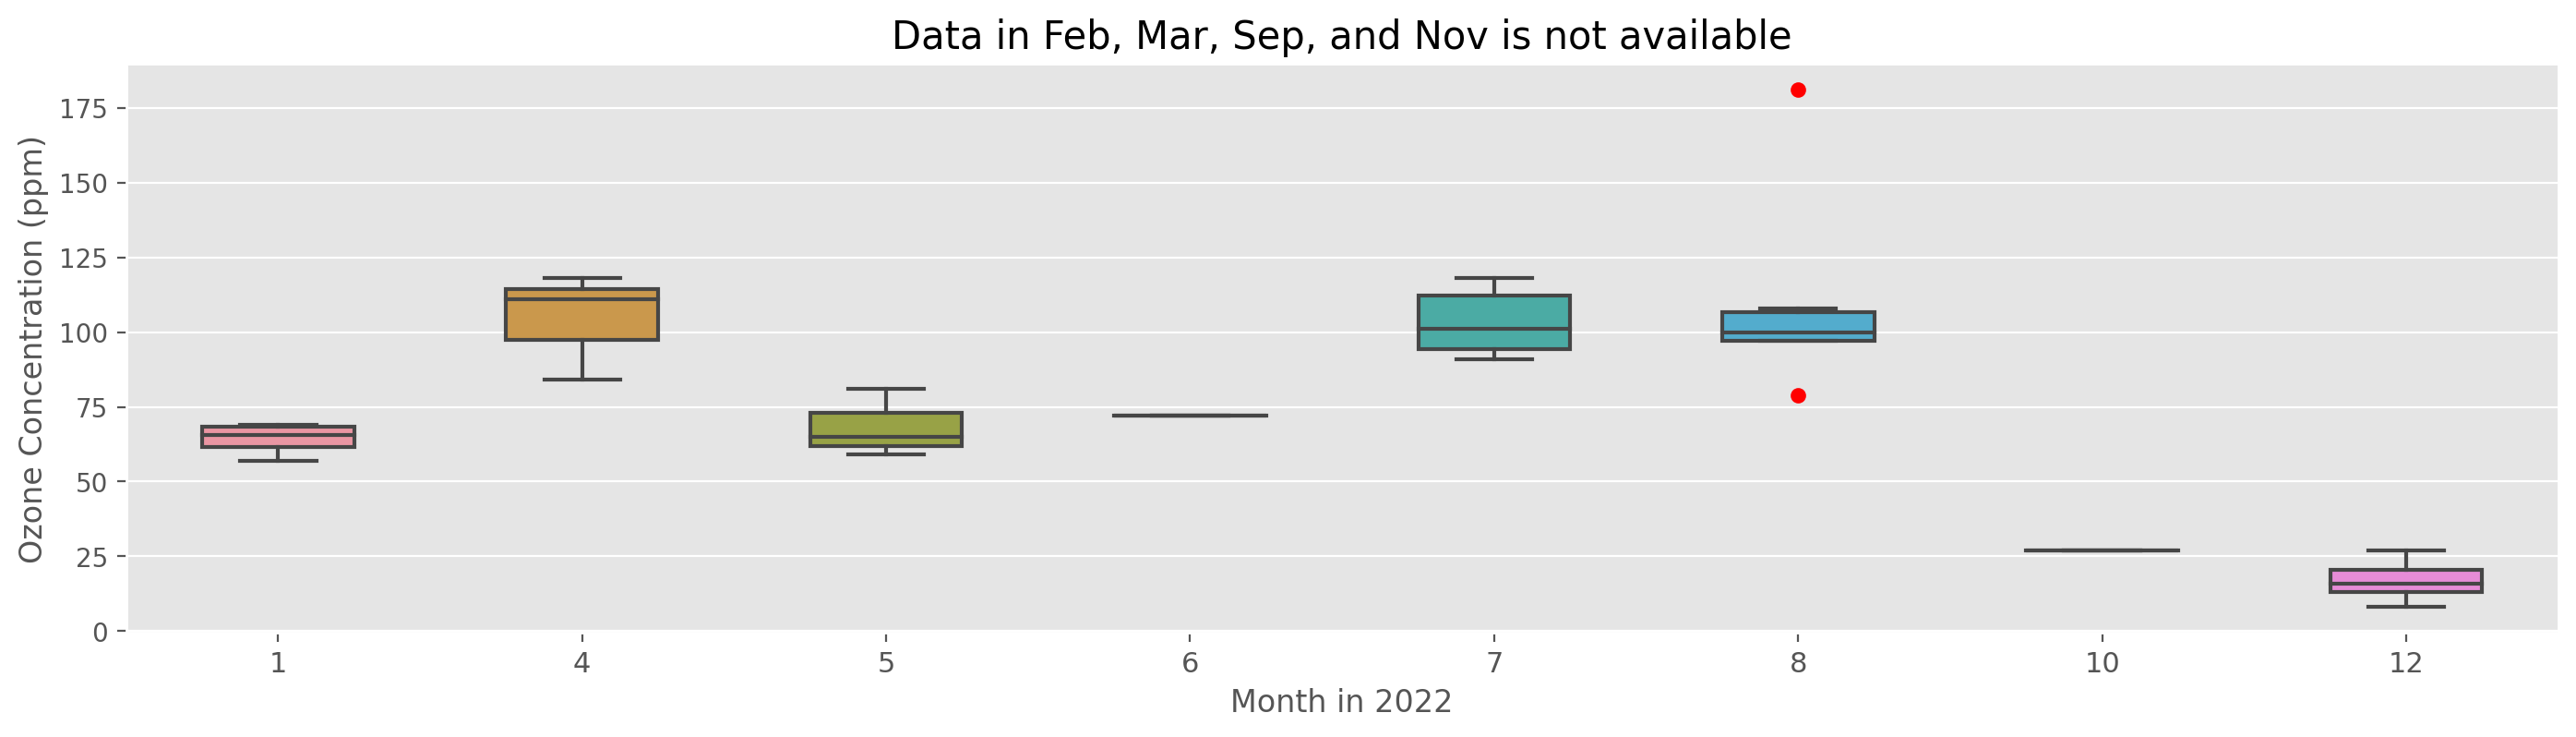

In [761]:
df_2022 = df[df['year'] == 2022]
plt.figure(figsize=(17, 4), dpi=200)
sns.boxplot(x='month', y='o3', data=df_2022, width=0.5,
            flierprops=dict(marker='.', markerfacecolor='red',
                            markeredgecolor='red', alpha=1, markersize=10))
plt.ylabel('Ozone Concentration (ppm)')
plt.xlabel('Month in 2022', size=12)
plt.title('Data in Feb, Mar, Sep, and Nov is not available', size=15)
plt.xticks(size=11)
plt.show()

#### **2.6.4 Residuals**
Residuals represent the remaining component of a time series after removing its trend and seasonal components. They are the remainder or noise that cannot be explained by the trend or seasonal patterns. 

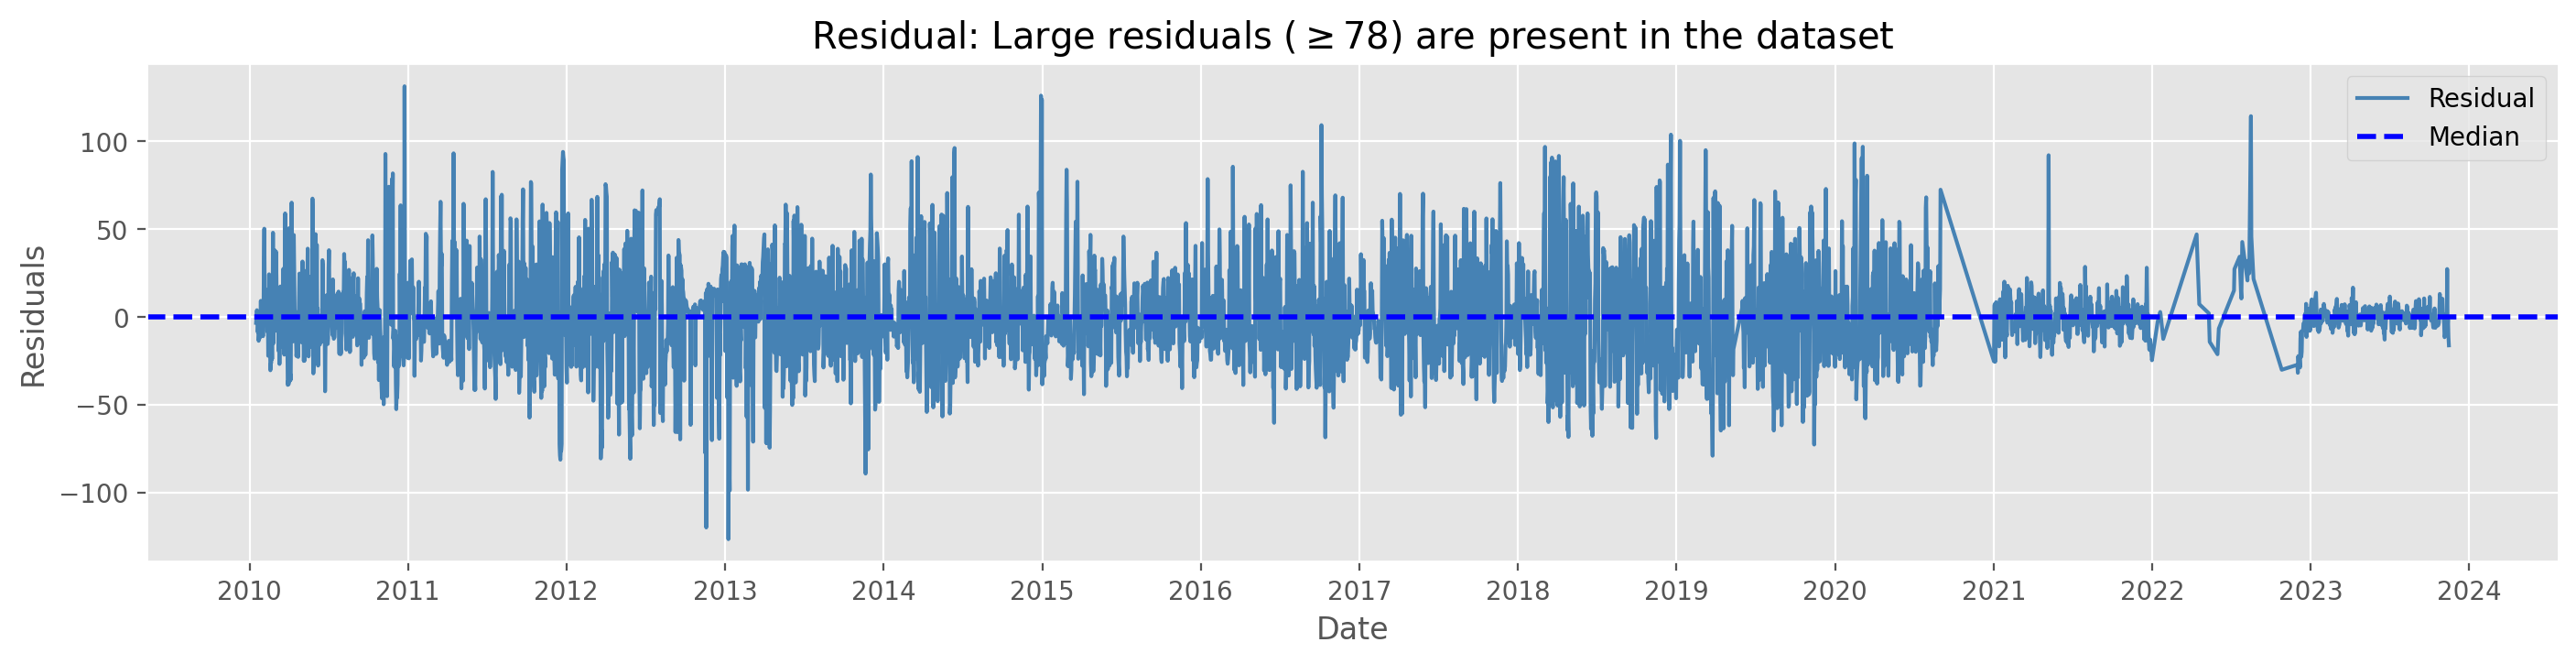

In [762]:
# plot residuals
plt.figure(figsize=(17, 4), dpi=200)
decompose_result.resid.plot(legend=True, color='steelblue', label='Residual')
plt.axhline(y=0, color='b', linestyle='--', linewidth=2, label='Median')
plt.title(r'Residual: Large residuals ($\geq 78$) are present in the dataset')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.xticks(rotation=0, ha='center')
plt.gca().xaxis.set_major_locator(mdates.YearLocator())             # set tick locations to every year
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))     # format ticks as year
plt.legend()
plt.show()

**Note**: The plot in general indicates that there are still significant unexplained variations in the data that are not captured by the trend and seasonal components alone. Since the residuals show a wide range between -150 and 150, this might be the effect of outliers or anomalies.

In [763]:
# get descriptive statistics
df['o3'].describe().round(2).to_frame().transpose()

count   mean    std  min   25%   50%    75%    max
o3  4626.0  85.05  46.28  0.0  51.0  78.0  110.0  193.0

### **2.7 Check Statitionarity**
Because temporal structure is crucial in time series, consistency (or stationarity) of ozone concentration over time should be investigated. Stationarity happens when seasonal patterns are absent in time series (Brownlee, 2020, p.131). Stationarity can be checked using a statistical test, namely Augmented Dickey-Fuller (ADF) test.

In [764]:
# perform ADF test
def adf_test(input):
    print ('ADF test result:')
    adf_output = adfuller(input, autolag='AIC')
    result = pd.Series(adf_output[0:4], index=['ADF stat','pvalue','Lag','Nobs'])
    for i, j in adf_output[4].items():
       result[f'Critical value {i}'] = j
    display(result)

display(adf_test(df['o3']))

ADF test result:


ADF stat                -3.725726
pvalue                   0.003766
Lag                     31.000000
Nobs                  4594.000000
Critical value 1%       -3.431774
Critical value 5%       -2.862169
Critical value 10%      -2.567105
dtype: float64

None

**Note**: Since the p-value of the Augmented Dickey-Fuller test is lower than the p-value at 0.05, the null hypothesis should be rejected, meaning that the data is stationary. And since it has been stationary, differencing is not necessary. For this reason, `d=0` can be used as the parameter for an ARIMA model later.

### **2.8 Check Autocorrelation**
Autocorrelation check investigates the similarity between a time series with a lagged (time steps) version of itself. In the context of ground-level ozone concentration, autocorrelation happens when today's ozone concentration is related to yesterday's concentration. This is a crucial step for a certain model, especially ARIMA or SARIMA. ARIMA will be a good choice when there is a strong autocorrelation. This autocorrelation check can be done with autocorrelation function (ACF).

This ACF plot will give three possible outputs, namely significant autocorrelation, decaying autocorrelation, and cutting off autocorrelation. 
- Significant autocorreelation happens when the lollipops remain high across many lags.
- Decaying autocorrelation occurs when the autocorrelation coefficient starts high and gradually decreases as the lag increases. 
- Cutting off autocorrelation occurs when there is a sudden drop to near zero after starting high at first few lags.

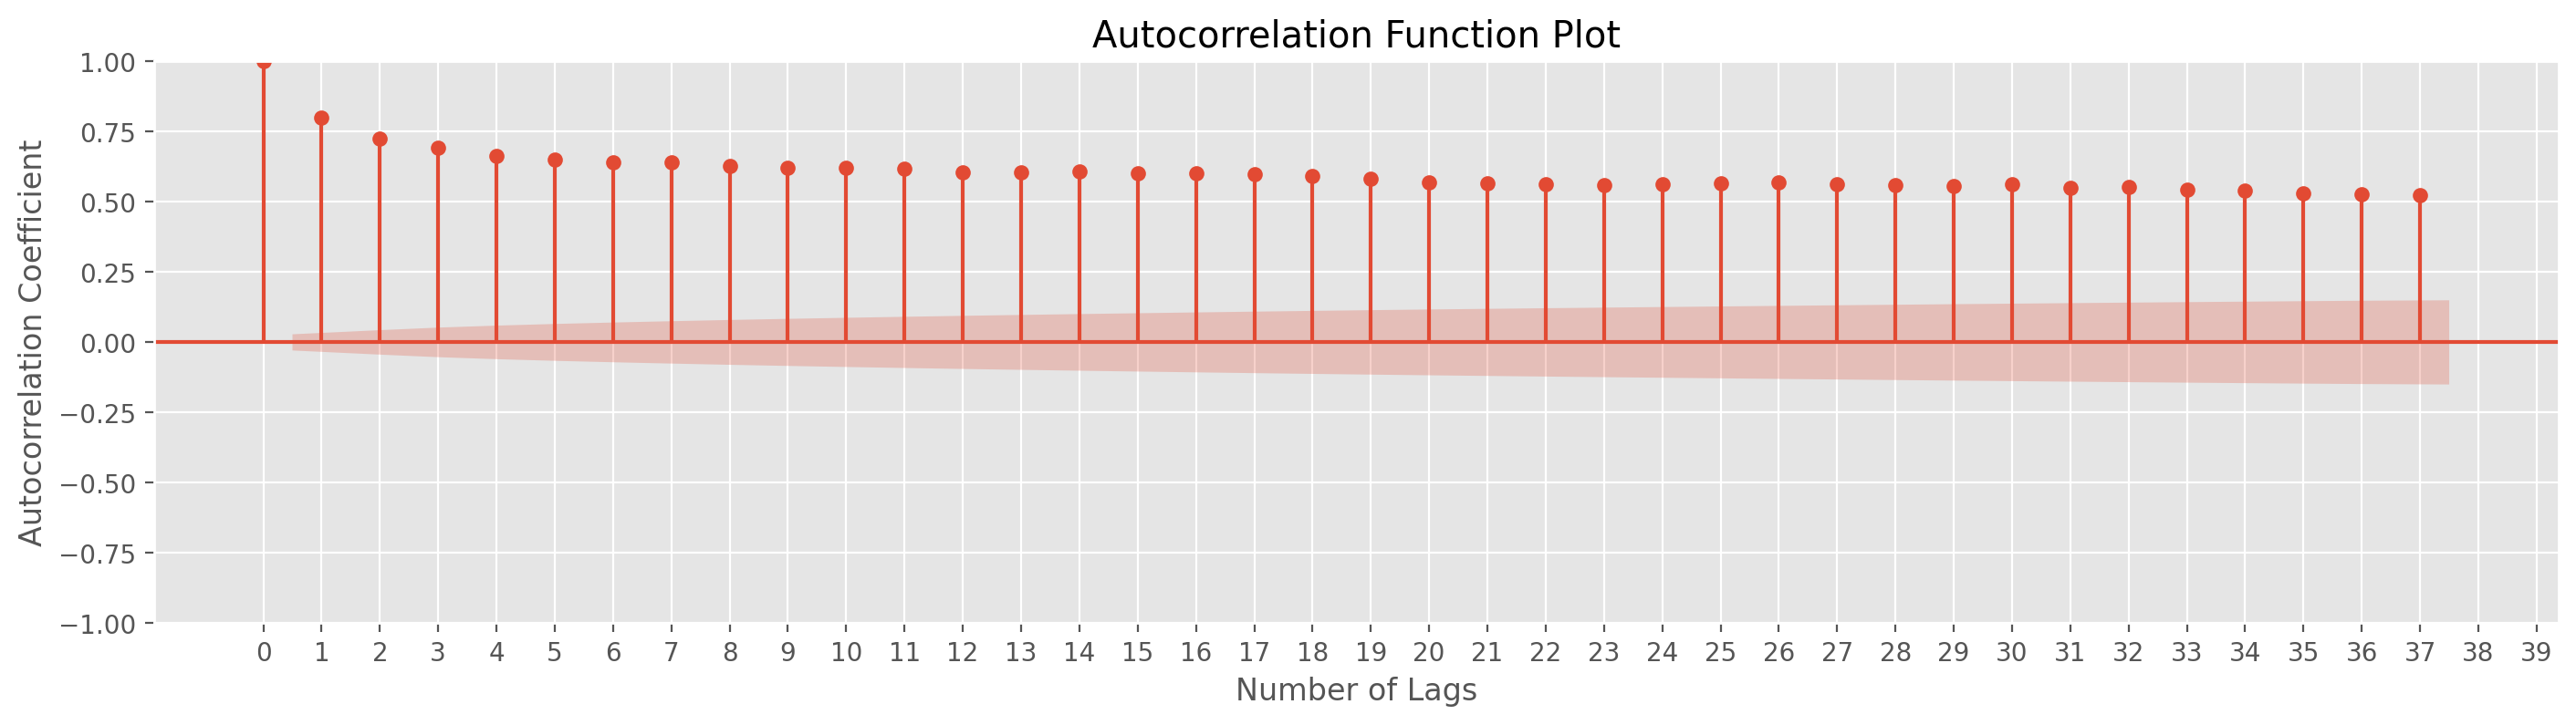

In [765]:
fig, ax = plt.subplots(figsize=(17, 4), dpi=200)  
plot_acf(df['o3'], ax=ax)
plt.title('Autocorrelation Function Plot')
plt.xlabel('Number of Lags')
plt.ylabel('Autocorrelation Coefficient')
plt.xticks(range(0, 40)) 
plt.show()

**Note**
- Based on the ACF plot, it appears that there's a strong autocorrelation at lag 1. This suggests that the value of the time series at a particular time point is significantly correlated with its value at the previous time point.
- The autocorrelation coefficient slowly decreases. This gradual decrease suggests a strong relationship between the current and past values at many lags. For this reason, this gradual decrease characterizes non-stationary series. This result then rejects the result of the Augmented Dickey-Fuller test which indicated stationary of the time series. 
- Given the non-stationarity of ozone concentration over time, the parameter `d` in arima should be set to non-zero values (`d=1` or `d=2`) if without manually differencing the data. 
- In addition to differencing order, the ACF plot also informs the number of lags required for the `q` (moving average order). Because of the gradual decay, `q=1` will be tried out. 

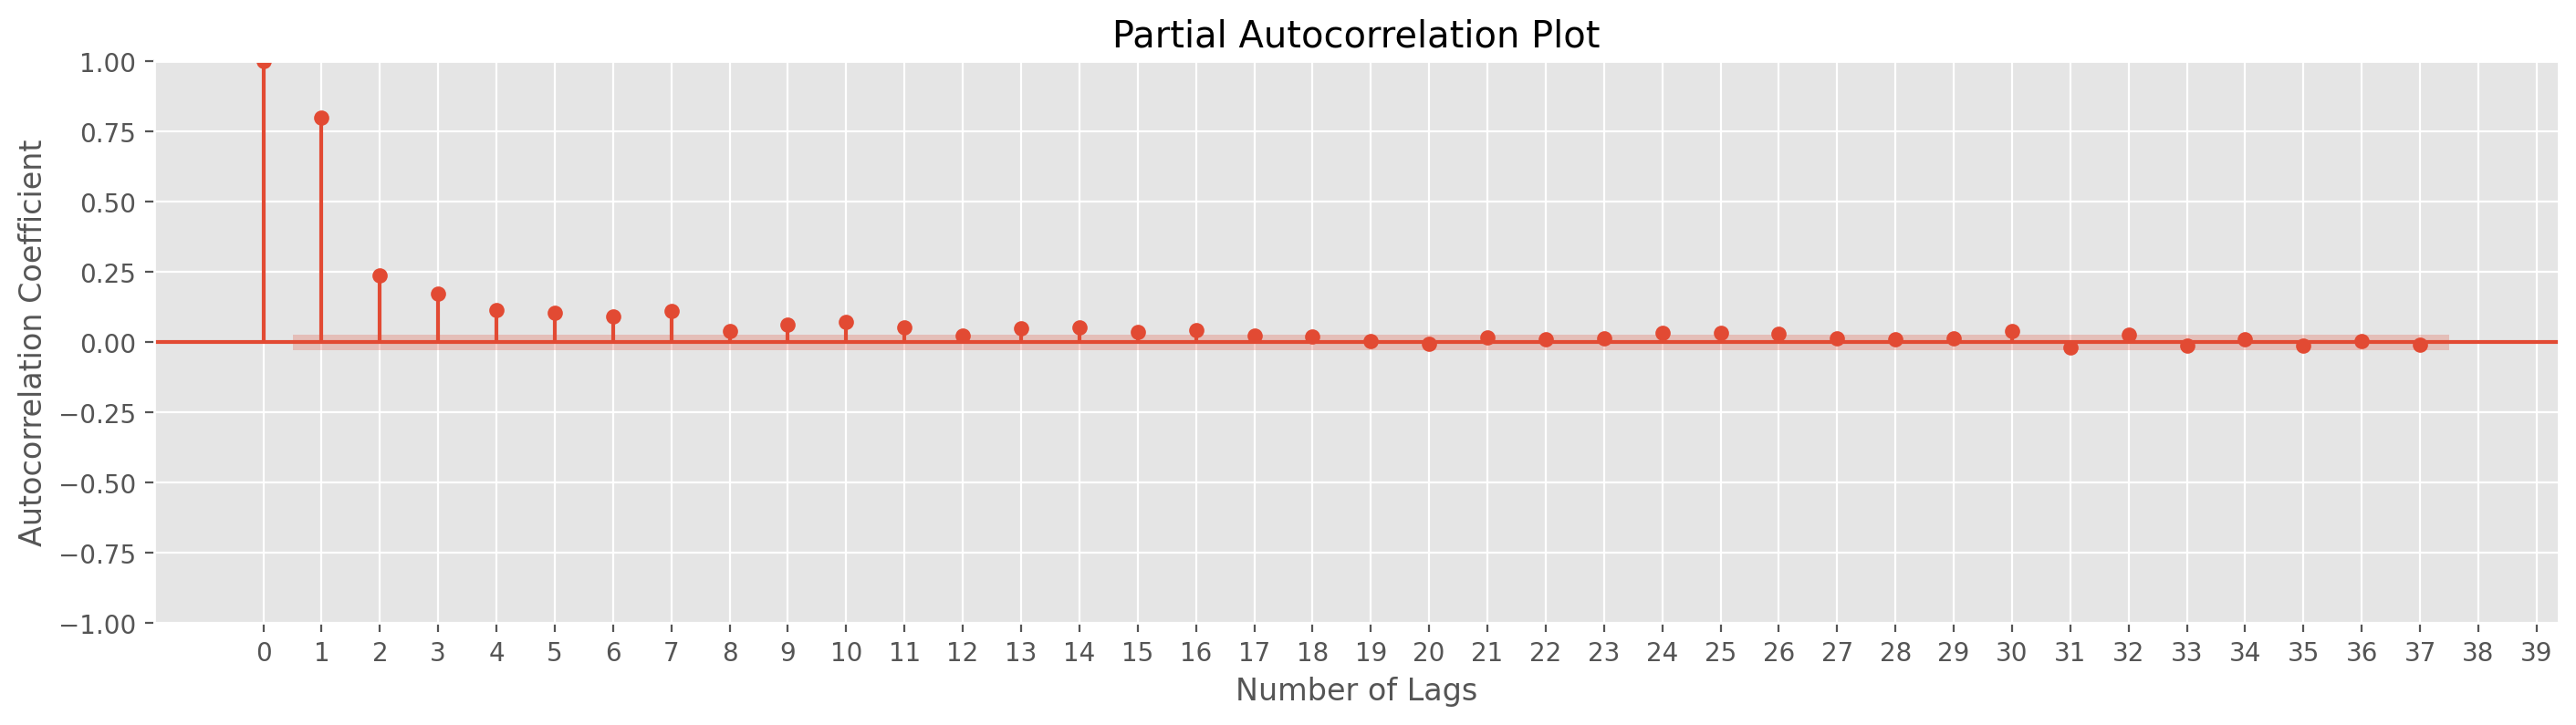

In [766]:
fig, ax = plt.subplots(figsize=(17, 4), dpi=200)  
plot_pacf(df['o3'].dropna(), ax=ax)
plt.title('Partial Autocorrelation Plot')
plt.xticks(range(0, 40)) 
plt.xlabel('Number of Lags')
plt.ylabel('Autocorrelation Coefficient')
plt.show()

**Note**: Since the partial autocorrelation coefficient drops significantly after lag 1, `p=1` can be a reasonable choice for the autoregressive component.

## **3 Predictive Modeling**
In this section, I will build several models involving three different algorithms, namely ARIMA (Autoregressive Integrated Moving Average), Prophet, and LSTM (Long Short-Term Memory) with a goal to get the best performing model based on RMSE (Root Mean Squared Error). Before moving forward, I will point out two scenarios where a model makes predictions, i.e., underpredictions and overpredictions. 
- **Underprediction**: Underpredictions occur when the forecasts underestimate the real ozone concentration. As a consequence, people may not be adequately warned about high pollution. In terms of quality management, the underprediction can lead to lack of actions by a government body to take necessary actions or impose restrictions. 
- **Overprediction**: This happens when a model's prediction is above the actual ozone concentration. As a result, the overestimation can lead to overly cautious measures, and worse, when occurring frequently, public trust in the monitoring system will be at risk.

The best model should have both minimum under and overpredictions to minimize negative consequences of both scenarios. The minimum under or overprediction can be seen by the smallest value of RMSE (Root Mean Squared Error). As previously mentioned, RMSE is chosen as the evaluation metric because of its high interpretability. The RMSE uses the same unit as the predictions, making the model performance evaluation easier.

The RMSE can be computed by firstly calculating the errors in the predictions (forecasted ozone concentration values - actual value). After the subtraction, each error should be squared to remove the negative signs and compute the mean of all squared errors. Last, take the square root of the mean value.

$$RMSE=\sqrt{\frac{\sum_{i=1}^N(\text{Predicted}_i-\text{Actual}_i)^2}{N}}$$

### **3.1 Data Splitting**

In [767]:
# drop irrelevant columns
df.drop(columns=['month', 'year'], inplace=True)

In [768]:
# specify test size
test_size = 365

# split dataset
train_df = df[:-test_size]
test_df = df[-test_size:]
print(f'Train set consists of {train_df.shape[0]} rows and {train_df.shape[1]} cols')
print(f'Test set consists of {test_df.shape[0]} rows and {test_df.shape[1]} cols')

Train set consists of 4261 rows and 2 cols
Test set consists of 365 rows and 2 cols


**Note**: To evaluate how good the performance of a model is, the dataset is split up into two, i.e., train and test set. However, unlike data split for regression and classification tasks which involve shuffling the data, time series task does not use shuffling because the data must be temporally ordered. Here, I decided to withdraw 365 instances from the dataset to be the test set. This number of instance represents the number of days in a year. The time series model here is expected to make long-term forecasts and have a low RMSE score. The "low" score here is operated based on the distribution of the data. For example, the RMSE of a model will be compared against the min, median, and max values of the ozone concentration.

In [769]:
# locate first instance in test df
test_df.iloc[:1, :]

tanggal    o3
4261 2022-12-01  27.0

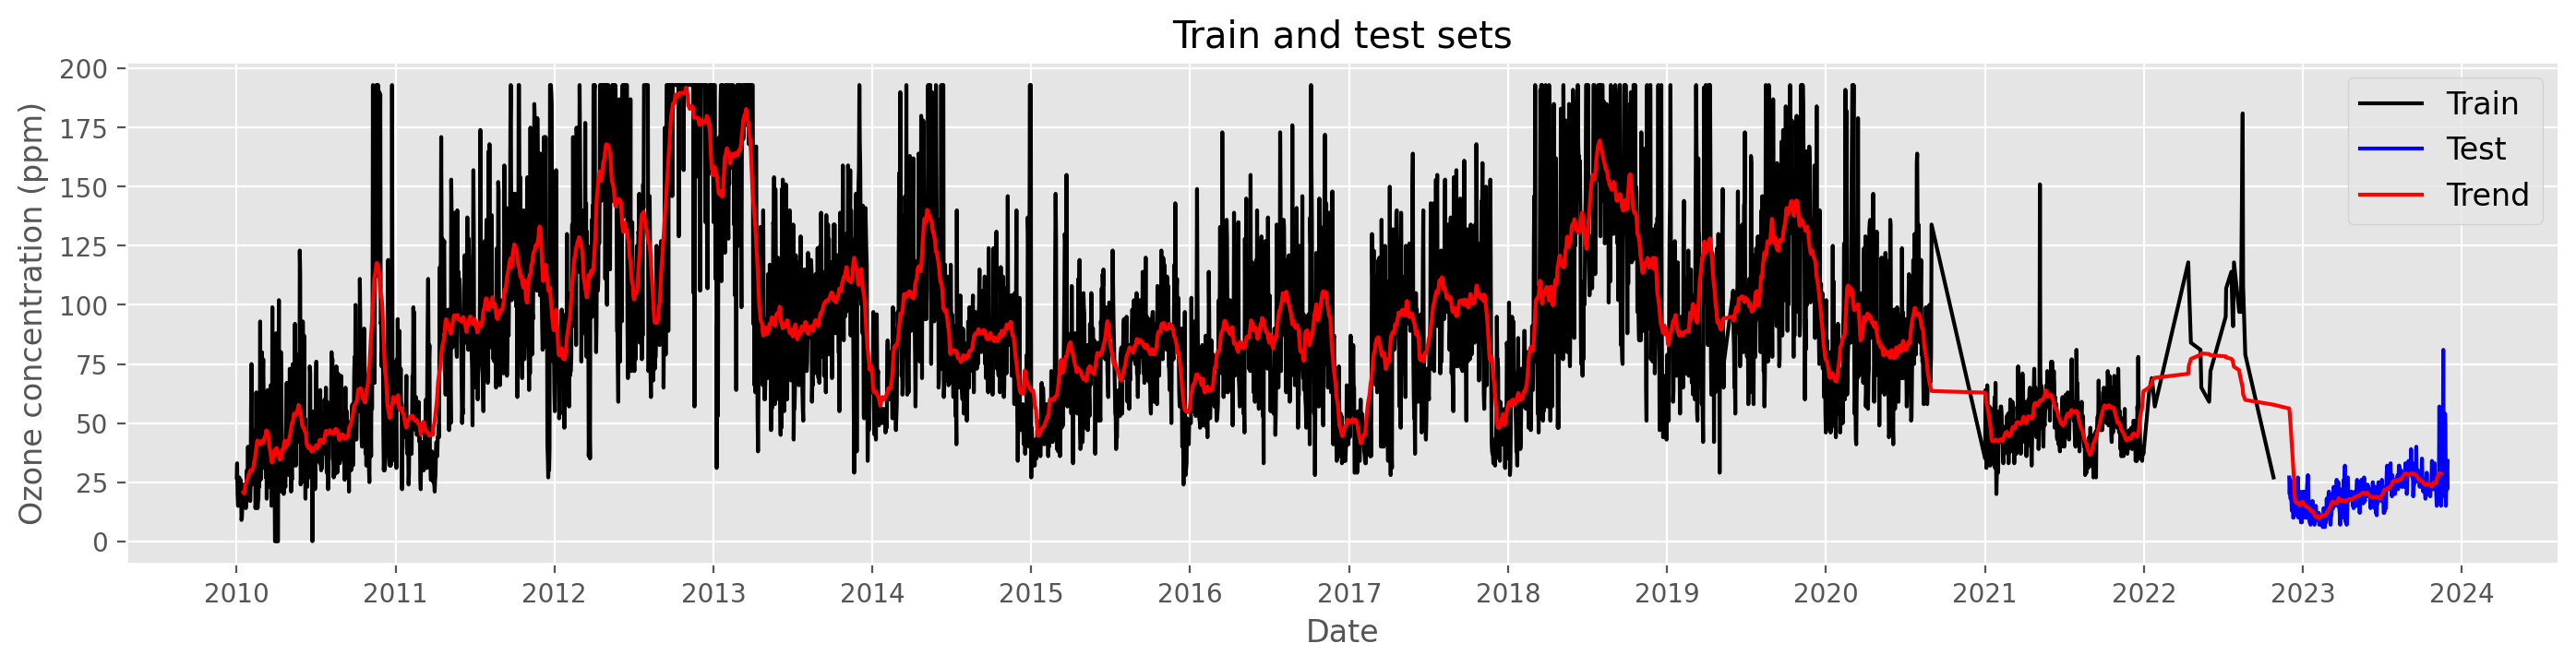

In [770]:
# visualize train and test set
plt.figure(figsize=(17, 4), dpi=200)

plt.plot(train_df['tanggal'], train_df['o3'], color='black', label='Train')
plt.plot(test_df['tanggal'], test_df['o3'], color='blue', label='Test')
decompose_result.trend.plot(legend=True, color='red', label='Trend')
plt.gca().xaxis.set_major_locator(mdates.YearLocator())          # set tick locations to every year
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # format ticks as year
plt.xlabel('Date')
plt.ylabel('Ozone concentration (ppm)')
plt.title('Train and test sets')
plt.xticks(rotation=0, ha='center')
plt.legend(fontsize=12)
plt.show()

In [771]:
# get stat summary of test set
test_df['o3'].describe().to_frame().transpose()

count  mean       std  min   25%   50%   75%   max
o3  365.0  20.4  8.237561  6.0  15.0  21.0  25.0  81.0

**Note**: The model is expected to follow the trend of the ozone concentration over time. According to the line chart above, since the range of the actual values (test set) is between 6 and 81, representing low ozone concentration since 2010, the ideal forecasted values shoud be around the range. 

### **3.2 ARIMA Model**
ARIMA (Autoregressive Integreated Moving Average) is a forecasting model to predict future values, e.g., future ozone concentration, based on the historical values (historical ozone concentration). To build an ARIMA model, the values of ARIMA parameters, i.e., `p` (n of lagged values), `d` (differencing), and `q` (lagged errors) should be prepared since the model relies on these parameters.

#### **3.2.1 Original ARIMA Model**
As identified earlier, the `p` parameter value to try based on the autocorrelation function plot is `1`. Because of the non-stationarity of the data, the differencing value (`d`) should be set to non-zeros. In the first trial below, I will try to use `1`. Last, the `q` as informed by the partial autocorrelation plot is `1`. To sum up, for the first trial, the parameters are `p=1`, `d=1`, and `q=1`.

In [772]:
# define and fit ARIMA model with p,d,q
arima_model = ARIMA(train_df['o3'], order=(1,1,1))
arima_model = arima_model.fit()

In [773]:
# make predictions 
forecast_result = arima_model.get_forecast(steps=len(test_df))

# get pred means
arima_predictions = forecast_result.predicted_mean

# get confidence intervals
conf_int = forecast_result.conf_int(alpha=0.05)  

In [774]:
# calculate RMSE
rmse_arima = np.sqrt(mean_squared_error(test_df['o3'], arima_predictions))
print(f"RMSE: {rmse_arima:.2f}")
min_v, max_v = df['o3'].min(), df['o3'].max()
print(f"Reference: Range of ozone concentration is between {min_v} and {max_v}")

RMSE: 63.20
Reference: Range of ozone concentration is between 0.0 and 193.0


**Note**: The RMSE of the ARIMA model's predictions is quite large since the value is almost three times of the max ozone concentration value. Given this substantial value, an adjustment to the model or an experiment with another algorithm will become necessary to find out another model with lower error.

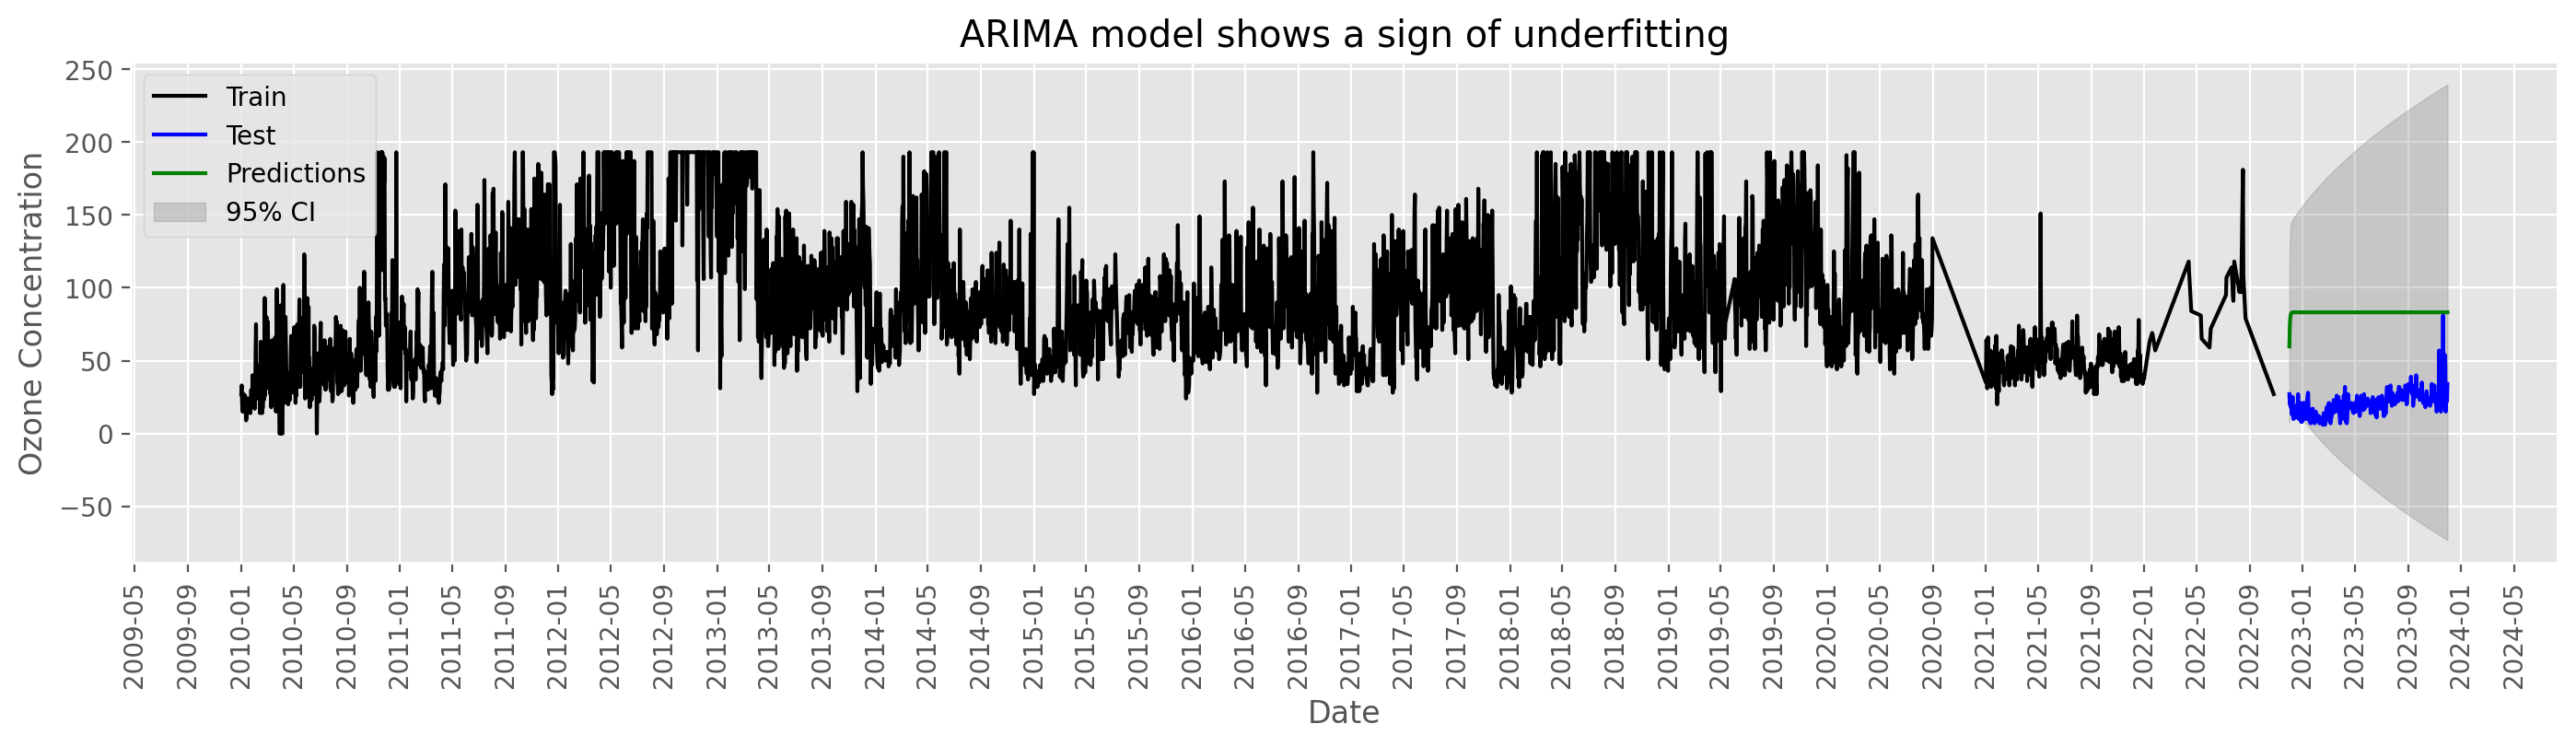

In [775]:
# plot ARIMA predictions
plt.figure(figsize=(17, 4), dpi=200)
plt.plot(train_df['tanggal'], train_df['o3'], label='Train', color='black')
plt.plot(test_df['tanggal'], test_df['o3'], label='Test', color='blue')
plt.plot(test_df['tanggal'], arima_predictions, label='Predictions', color='green')
plt.fill_between(test_df['tanggal'], conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='gray', alpha=0.3, label='95% CI')

# Set x-axis major locator to every 4 months
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=4))  
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gcf().autofmt_xdate()

plt.title('ARIMA model shows a sign of underfitting')
plt.xlabel('Date')
plt.ylabel('Ozone Concentration')
plt.xticks(rotation=90, ha='center')
plt.legend(loc='upper left')
plt.show()

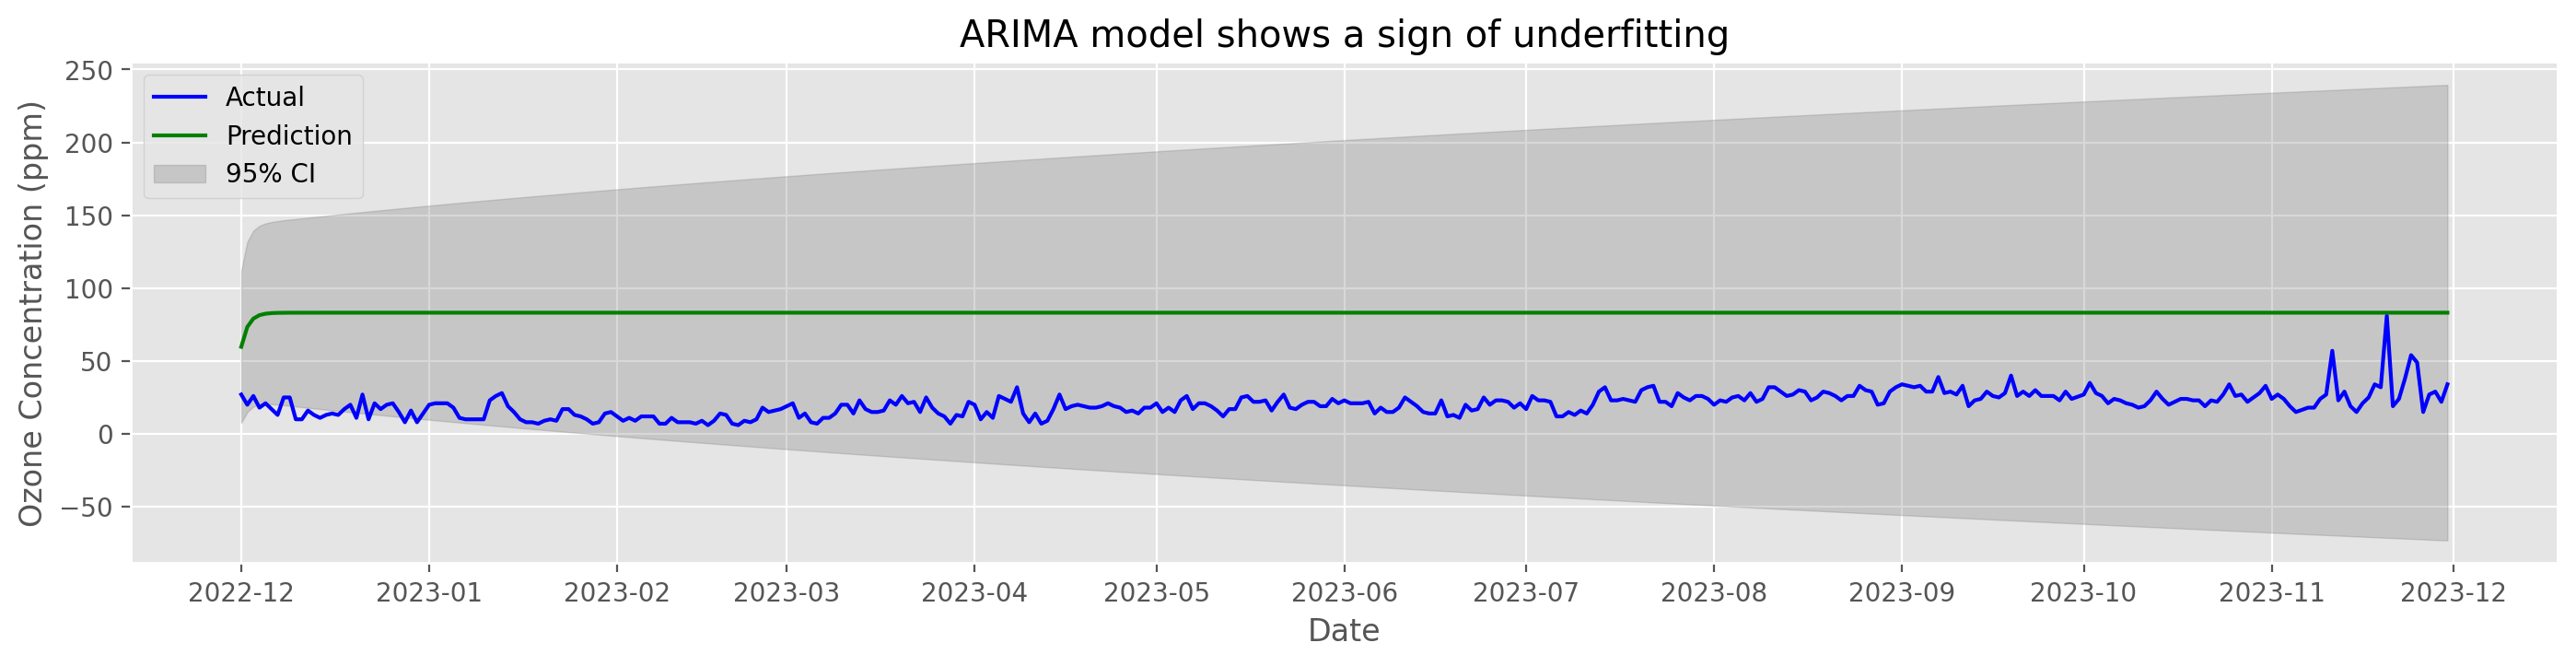

In [776]:
# plot the results
plt.figure(figsize=(17, 4), dpi=200)
plt.plot(test_df['tanggal'], test_df['o3'], label='Actual', color='blue')
plt.plot(test_df['tanggal'], arima_predictions, label='Prediction', color='green')
plt.fill_between(test_df['tanggal'], conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='gray', alpha=0.3, label='95% CI')

# set x-axis major locator to every 2 mth
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())  
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gcf().autofmt_xdate()

plt.title('ARIMA model shows a sign of underfitting')
plt.xlabel('Date')
plt.ylabel('Ozone Concentration (ppm)')
plt.xticks(rotation=0, ha='center')
plt.legend(loc='upper left')
plt.show()

**Note**
- The ARIMA model shows a sign of underfitting. The predicted values diveerge significantly from the actual values with a flat line, indicating a failure to capture the variability in the data. This might also suggest that the model is too simple to accurately represent the underlaying patterns in the time series data, especially long-term period (1 year). This might indicate that ARIMA model is more optimized for short-term forecasts. Kumar and Jain ([2010](https://doi.org/10.1007/s00477-009-0361-8)), for example, forecasted air pollutant in New Delhi, India in the three weeks period and the ARIMA model performs well.
- To improve ARIMA model's performance, an adjustment with the ARIMA parameters (`p`, `d`, and `q`) can be done. Alternatively, other algorithms such as Prophet and Long-Term Short Term Memory can be options. In this case, seasonal ARIMA (SARIMA) does not seem to be a good option since the ozone concentration does not indicate any seasonal components.

#### **3.1.2 ARIMA Model with Parameter Adjustment (AutoARIMA)**
Auto ARIMA is a simplified version of ARIMA in which the algorithm automatically searches the optimal `p`, `d`, and `q`. This algorithm is different from ARIMA which requires pre-defined values before building a model which takes more time.

However, it is important to bear in mind that even though the process of model building is mostly automatic and efficient, there is no guarantee that the model's performance will be significantly better than the previous ARIMA model because the previous model in 3.1.1 indicated poor performance in a long-term forecast.

In [777]:
# perform auto_arima 
auto_model = pm.auto_arima(train_df['o3'], start_p=0, start_q=0, max_p=3, max_q=3, 
                           seasonal=True, trace=False, stepwise=True)
print(auto_model)

 ARIMA(3,1,1)(0,0,0)[0]          


In [778]:
# forecast using the auto_arima model
autoarima_forecast, conf_int = auto_model.predict(n_periods=len(test_df), return_conf_int=True)

In [779]:
# calculate RMSE
rmse_autoarima = np.sqrt(mean_squared_error(test_df['o3'], autoarima_forecast))
print(f"RMSE: {rmse_autoarima:.2f}")
min_v, max_v = df['o3'].min(), df['o3'].max()
print(f"Reference: Range of ozone concentration is between {min_v} and {max_v}")

RMSE: 59.35
Reference: Range of ozone concentration is between 0.0 and 193.0


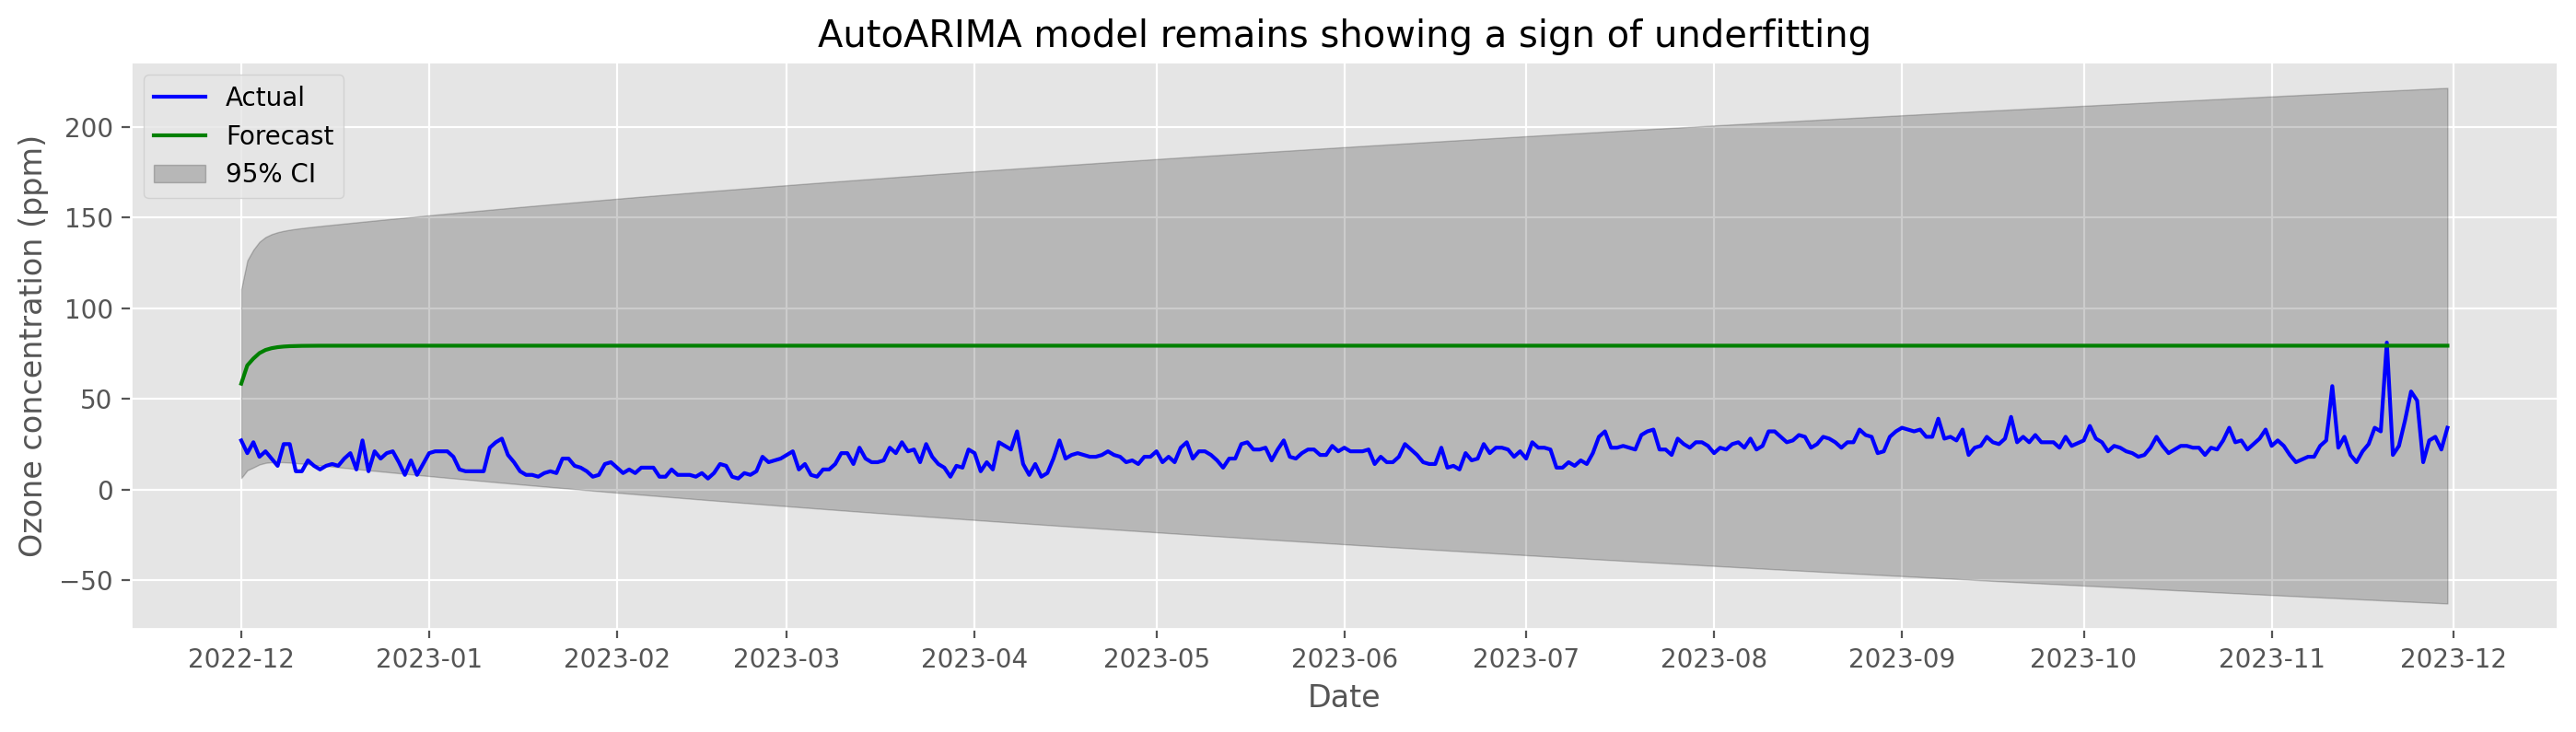

In [780]:
# plot ARIMA forecasts
plt.figure(figsize=(17, 4), dpi=200)
plt.plot(test_df['tanggal'], test_df['o3'], label='Actual', color='blue')
plt.plot(test_df['tanggal'], autoarima_forecast, label='Forecast', color='green')
plt.fill_between(test_df['tanggal'], conf_int[:, 0], conf_int[:, 1], color='k', alpha=0.2, label='95% CI')
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())  
plt.title('AutoARIMA model remains showing a sign of underfitting')
plt.xlabel('Date')
plt.ylabel('Ozone concentration (ppm)')
plt.legend(loc='upper left')
plt.show()

**Note**: Even though an adjustment to the order parameter has been done with `auto_arima`, the adjustment does not show a significant improvement. The only improvement shown is only the reduction to the RMSE score. The adjusted ARIMA model remains experiencing underfitting. The poor performance of these two ARIMA models might be attributed to ARIMA's limitation when dealing with long-term forecasting. This finding is similar to previous studies (Lee, Beh, & Lem, [2023](https://dx.doi.org/10.1504/IJBIDM.2022.10045646); Utari & Martini, [2022](https://doi.org/10.32502/jbearing.4645202273)) study pointing out ARIMA model's limitation for long-term forecasting, resulting a flat line.

### **3.2 Prophet Model**
To address the limitations of the ARIMA models in long-term forecasting, a Prophet model will be utilized. Prophet model building is quite straightforward because it reduces manual effort to handle outliers and missing values since these have been handled automatically by [Prophet](https://facebook.github.io/prophet/).

In [781]:
df_prophet = df.copy()
df_prophet.rename(columns={'tanggal': 'ds', 'o3': 'y'}, inplace=True)

**Note**: Prophet will require specific names for the variables so the variable names `tanggal` and `o3` must be renamed into `ds` and `y`, respectively. Otherwise, there will be an error message arising. Furthermore, since the name of the variable changes, the train and test set can no longer be used. Here, the train and tests set are redefined for building the Prophet model but the instances remain the same. The first instance for testing the Prophet model is still 2021-10-19.

In [782]:
# specify test size
test_size = 365

# Split dataset
train_df = df_prophet[:-test_size]
test_df = df_prophet[-test_size:]
print(f'Train set consists of {train_df.shape[0]} rows and {train_df.shape[1]} cols')
print(f'Test set consists of {test_df.shape[0]} rows and {test_df.shape[1]} cols')

Train set consists of 4261 rows and 2 cols
Test set consists of 365 rows and 2 cols


In [783]:
# locate first instance
test_df.iloc[:1, :]

ds     y
4261 2022-12-01  27.0

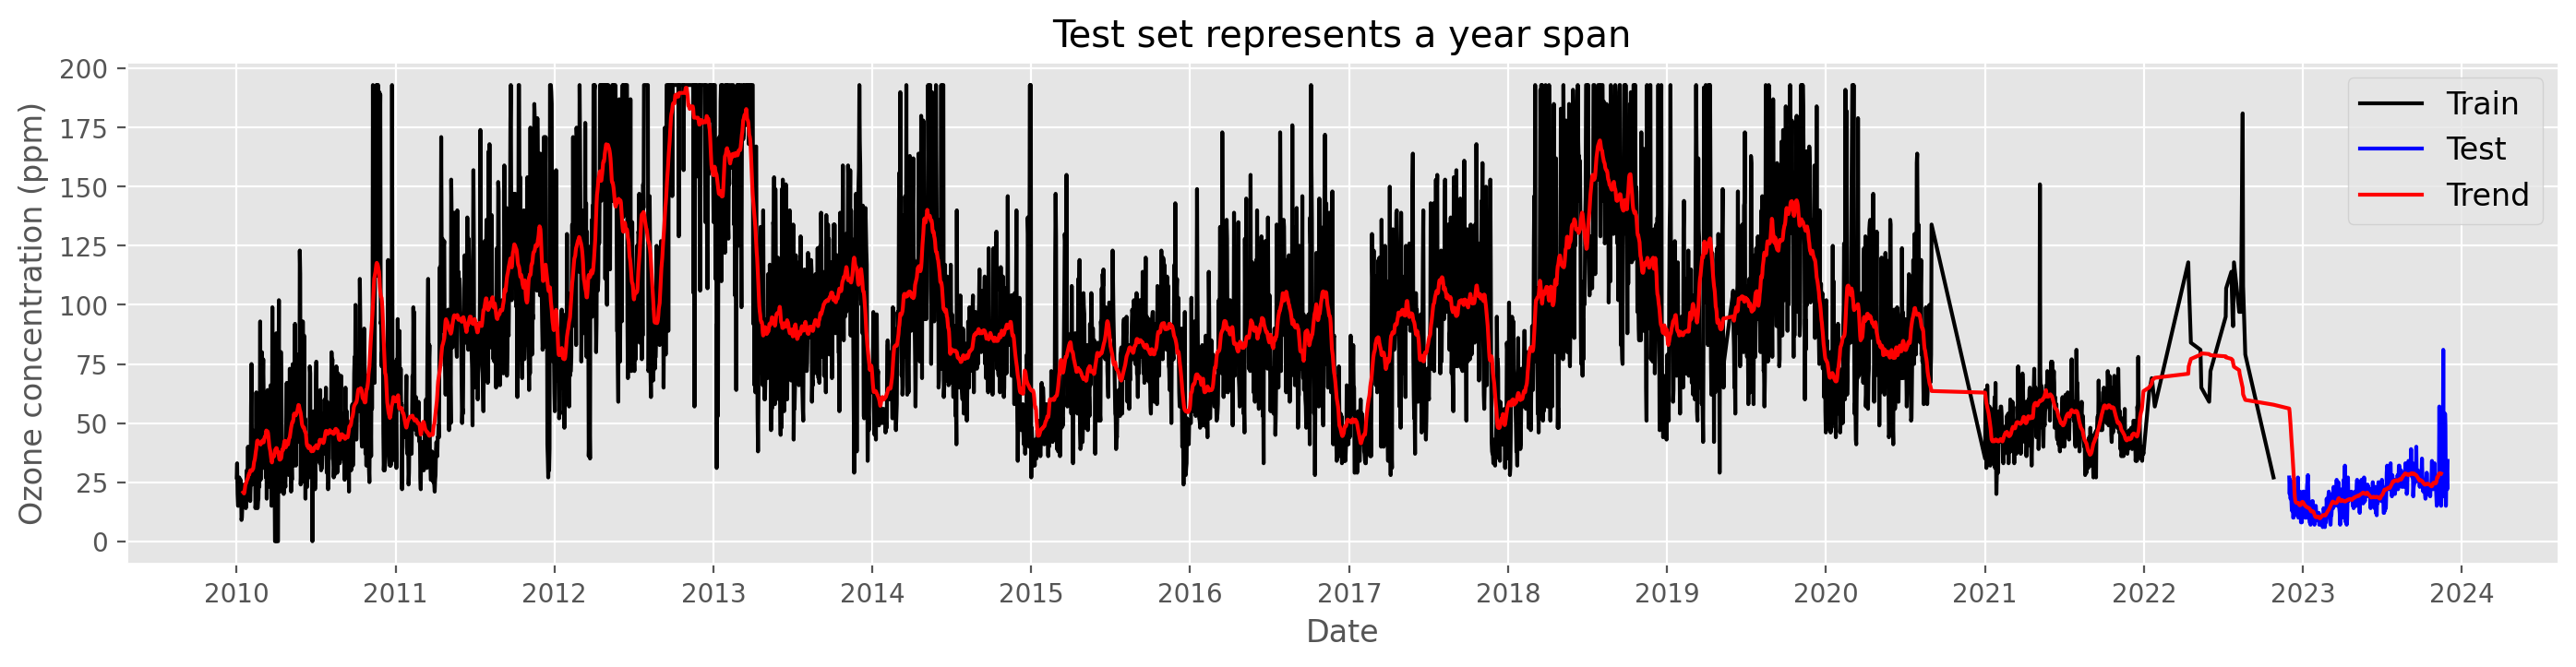

In [784]:
# visualize train and test set
plt.figure(figsize=(17, 4), dpi=200)
plt.plot(train_df['ds'], train_df['y'], color='black', label='Train')
plt.plot(test_df['ds'], test_df['y'], color='blue', label='Test')
decompose_result.trend.plot(legend=True, color='red', label='Trend')
plt.gca().xaxis.set_major_locator(mdates.YearLocator())          # set tick locations to every year
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # format ticks as year
plt.xlabel('Date')
plt.ylabel('Ozone concentration (ppm)')
plt.title('Test set represents a year span')
plt.xticks(rotation=0, ha='center')
plt.legend(fontsize=12)
plt.show()

In [785]:
# train prophet model
prophet_model = Prophet(interval_width=0.95)
prophet_model.fit(train_df)

20:00:17 - cmdstanpy - INFO - Chain [1] start processing
20:00:17 - cmdstanpy - INFO - Chain [1] done processing


In [786]:
# make predictions
forecast_df = prophet_model.predict(test_df[['ds']])
forecast_df.loc[:6, ['ds', 'trend', 'yhat_upper', 'yhat_lower', 'yhat']].round(2)

ds  trend  yhat_upper  yhat_lower   yhat
0 2022-12-01  23.82       95.37      -40.38  30.46
1 2022-12-02  23.75       98.45      -37.59  28.26
2 2022-12-03  23.68       89.68      -37.11  26.42
3 2022-12-04  23.62       81.97      -38.61  22.53
4 2022-12-05  23.55       85.84      -42.48  22.93
5 2022-12-06  23.48       87.28      -43.04  20.28
6 2022-12-07  23.41       88.18      -41.37  21.86

In [787]:
# compute RMSE
rmse_prophet = np.sqrt(mean_squared_error(test_df['y'], forecast_df['yhat']))
print(f'RMSE of Prophet model: {rmse_prophet:.2f} ppm')
min_v, max_v = df['o3'].min(), df['o3'].max()
print(f"Reference: Range of ozone concentration is between {min_v} and {max_v}")

RMSE of Prophet model: 13.05 ppm
Reference: Range of ozone concentration is between 0.0 and 193.0


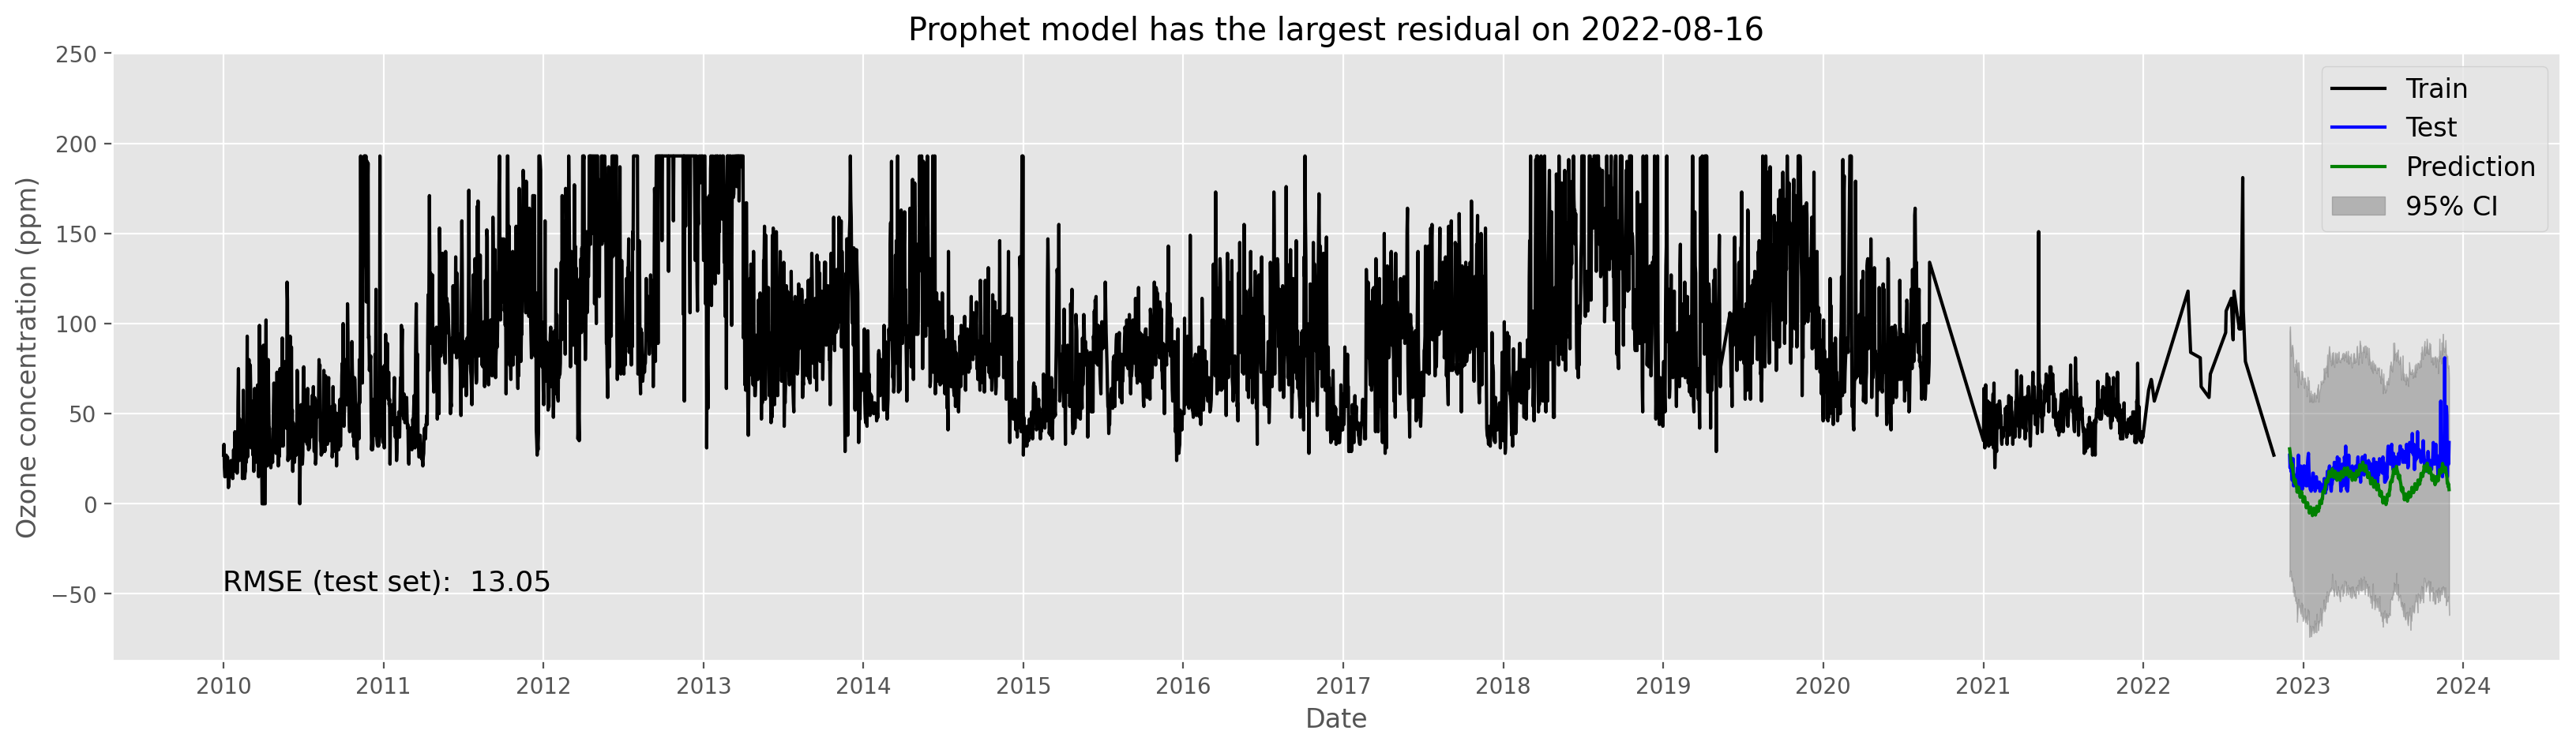

In [788]:
plt.figure(figsize=(20, 5), dpi=200)
plt.plot(train_df['ds'], train_df['y'], color='black', label='Train')
plt.plot(test_df['ds'], test_df['y'], color='blue', label='Test')
plt.plot(forecast_df['ds'], forecast_df['yhat'], color='green', label='Prediction')
plt.fill_between(forecast_df['ds'], forecast_df['yhat_lower'], forecast_df['yhat_upper'], 
                 color='grey', alpha=0.5, label='95% CI')
plt.text(x=0.045, y=0.15, s=f"RMSE (test set):  {rmse_prophet:.2f}", transform=plt.gca().transAxes,
         fontsize=13, verticalalignment='top', horizontalalignment='left', color='black')
plt.gca().xaxis.set_major_locator(mdates.YearLocator())          # set tick locations to every year
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # format ticks as year
plt.xlabel('Date', size=12)
plt.ylabel('Ozone concentration (ppm)')
plt.title('Prophet model has the largest residual on 2022-08-16')
plt.yticks(range(-50, 300, 50))
plt.legend(fontsize=12)
plt.show()

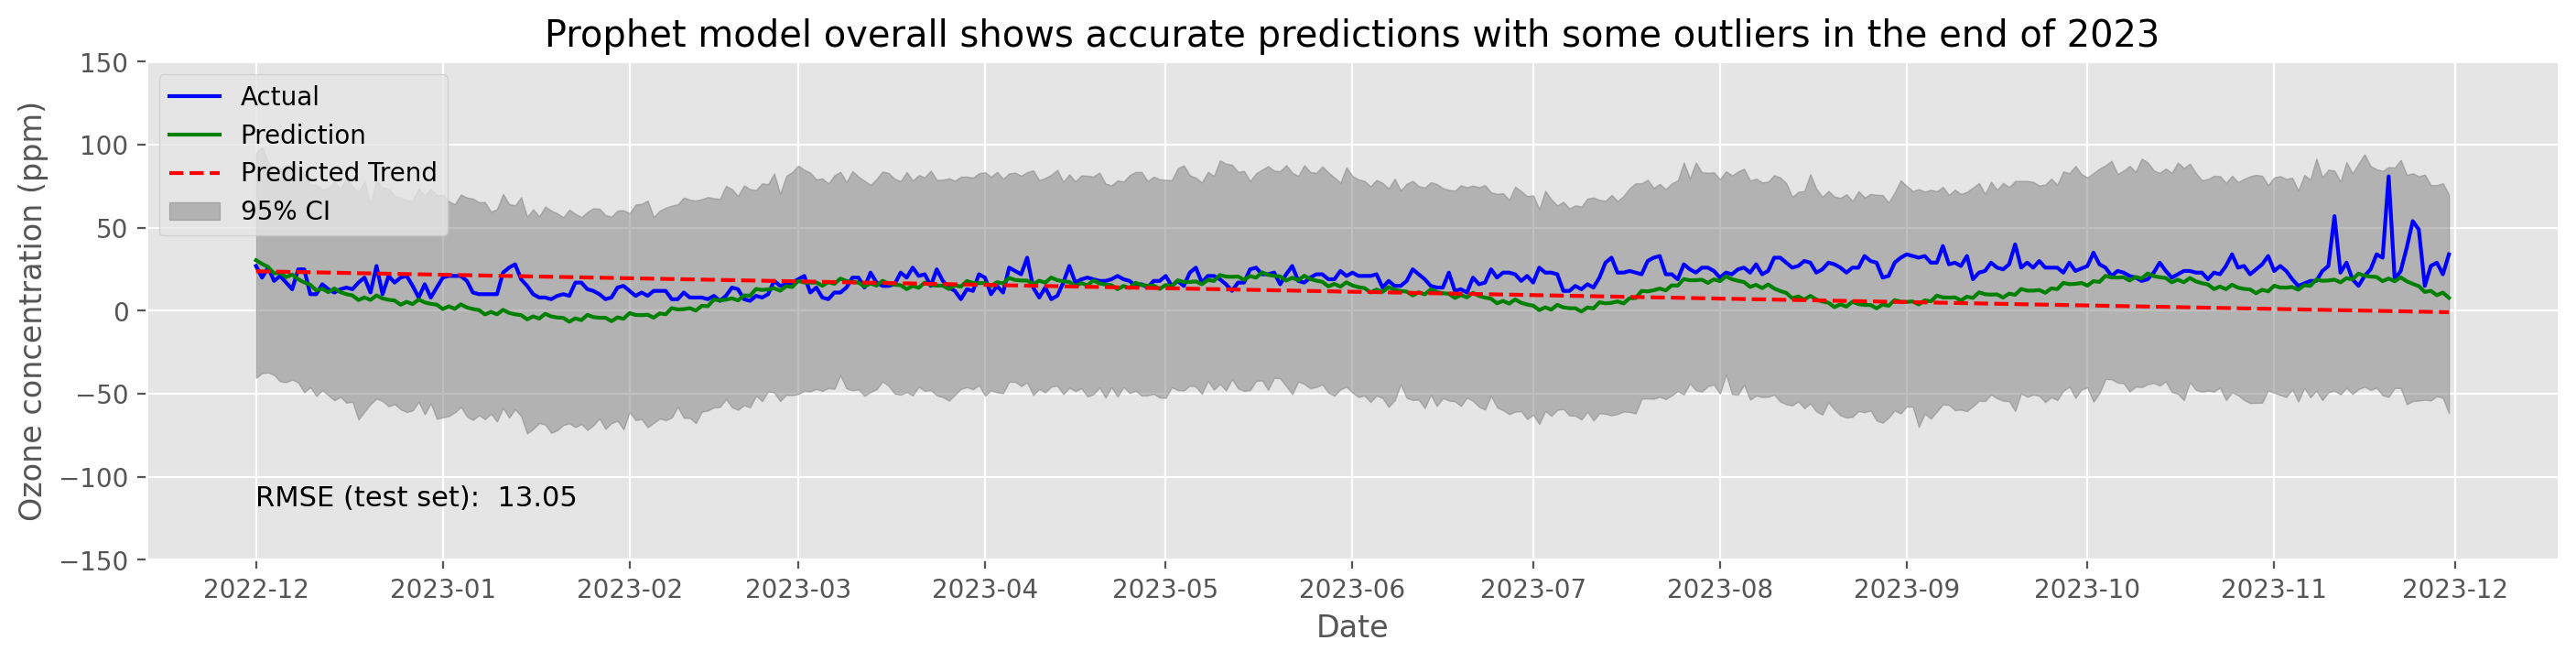

In [789]:
plt.figure(figsize=(17, 4), dpi=200)
plt.plot(test_df['ds'], test_df['y'], color='blue', label='Actual')
plt.plot(forecast_df['ds'], forecast_df['yhat'], color='green', label='Prediction')
plt.plot(forecast_df['ds'], forecast_df['trend'], color='red', label='Predicted Trend', linestyle='--')
plt.fill_between(forecast_df['ds'], forecast_df['yhat_lower'], 
                 forecast_df['yhat_upper'], color='grey', alpha=0.5, label='95% CI')
plt.text(x=0.045, y=0.15, s=f"RMSE (test set):  {rmse_prophet:.2f}", transform=plt.gca().transAxes,
         fontsize=11, verticalalignment='top', horizontalalignment='left', color='black')
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())  
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gcf().autofmt_xdate()
plt.xticks(rotation=0, ha='center')
plt.xlabel('Date')
plt.ylabel('Ozone concentration (ppm)')
plt.title('Prophet model overall shows accurate predictions with some outliers in the end of 2023')
plt.yticks(range(-150, 200, 50))
plt.legend()
plt.show()

**Note**
- The Prophet model in general shows accurarate predictions for ozone concentration with RMSE score of 13.05. This value represents the overall magnitude of errors made by the model predictions. Because the range of ozone concentration in the dataset is between 0 and 193 ppm, RMSE = 13.05 indicates that the model's performance is good. 
- In addition to the small numerical representation of errors, the accuracy of the Prophet model can also be evaluated by examining the visual representation (plot). The predicted values (<span style='color:green'>green line</span>) follows closely the actual values (<span style='color:blue'>blue line</span>), indicating a good fit to the data. The model has effectively captured the overall trend in the ozone concentration. 
- However, the presence of outliers in the end of 2023 might need further investigation to understand the extreme cases. 
- To understand how the Prophet model makes such forecasts, components of the model's forecasts can be visualized.

### **3.4 Long Short-Term Model**
<span style='color:red'>Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Ut enim ad minim veniam, quis nostrud exercitation ullamco laboris nisi ut aliquip ex ea commodo consequat. Duis aute irure dolor in reprehenderit in voluptate velit esse cillum dolore eu fugiat nulla pariatur. Excepteur sint occaecat cupidatat non proident, sunt in culpa qui officia deserunt mollit anim id est laborum.</span>

In [790]:
# set tanggal as index
df.set_index('tanggal', inplace=True)

In [791]:
# normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df['o3'].values.reshape(-1, 1))

# create sequences
def create_sequences(data, seq_length):
    sequences = []
    targets = []
    for i in range(len(data) - seq_length):
        seq = data[i:i+seq_length]
        target = data[i+seq_length]
        sequences.append(seq)
        targets.append(target)
    return np.array(sequences), np.array(targets)

sequence_length = 30
X, y = create_sequences(scaled_data, sequence_length)

<span style='color:red'>Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Ut enim ad minim veniam, quis nostrud exercitation ullamco laboris nisi ut aliquip ex ea commodo consequat. Duis aute irure dolor in reprehenderit in voluptate velit esse cillum dolore eu fugiat nulla pariatur. Excepteur sint occaecat cupidatat non proident, sunt in culpa qui officia deserunt mollit anim id est laborum.</span>

In [792]:
# specify test size
test_size = 365

# split dataset
X_train, X_test = X[:-test_size], X[-test_size:]
y_train, y_test = y[:-test_size], y[-test_size:]

In [793]:
# define the LSTM model with additional layers and dropout
def create_lstm_model():
    model = Sequential([
        LSTM(100, activation='relu', return_sequences=True, kernel_regularizer=regularizers.l2(0.01),
             input_shape=(sequence_length, 1)),
        Dropout(0.2),
        LSTM(50, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
        Dense(1, kernel_regularizer=regularizers.l2(0.01))
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='mse')
    return model

In [794]:
# create and train the LSTM model
lstm_model = create_lstm_model()

# define early stopping and learning rate scheduler
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler = LearningRateScheduler(lambda epoch, lr: lr * 0.9 if epoch > 10 else lr)

history = lstm_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1, verbose=0,
                         callbacks=[early_stopping, lr_scheduler])

<span style='color:red'>Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Ut enim ad minim veniam, quis nostrud exercitation ullamco laboris nisi ut aliquip ex ea commodo consequat. Duis aute irure dolor in reprehenderit in voluptate velit esse cillum dolore eu fugiat nulla pariatur. Excepteur sint occaecat cupidatat non proident, sunt in culpa qui officia deserunt mollit anim id est laborum.</span>

In [795]:
# evaluate model
lstm_predictions = lstm_model.predict(X_test)
lstm_predictions = scaler.inverse_transform(lstm_predictions)
y_test_inv = scaler.inverse_transform(y_test)
lstm_rmse = np.sqrt(mean_squared_error(y_test_inv, lstm_predictions))

print(f"LSTM Model RMSE: {lstm_rmse:.2f}")

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
LSTM Model RMSE: 24.31


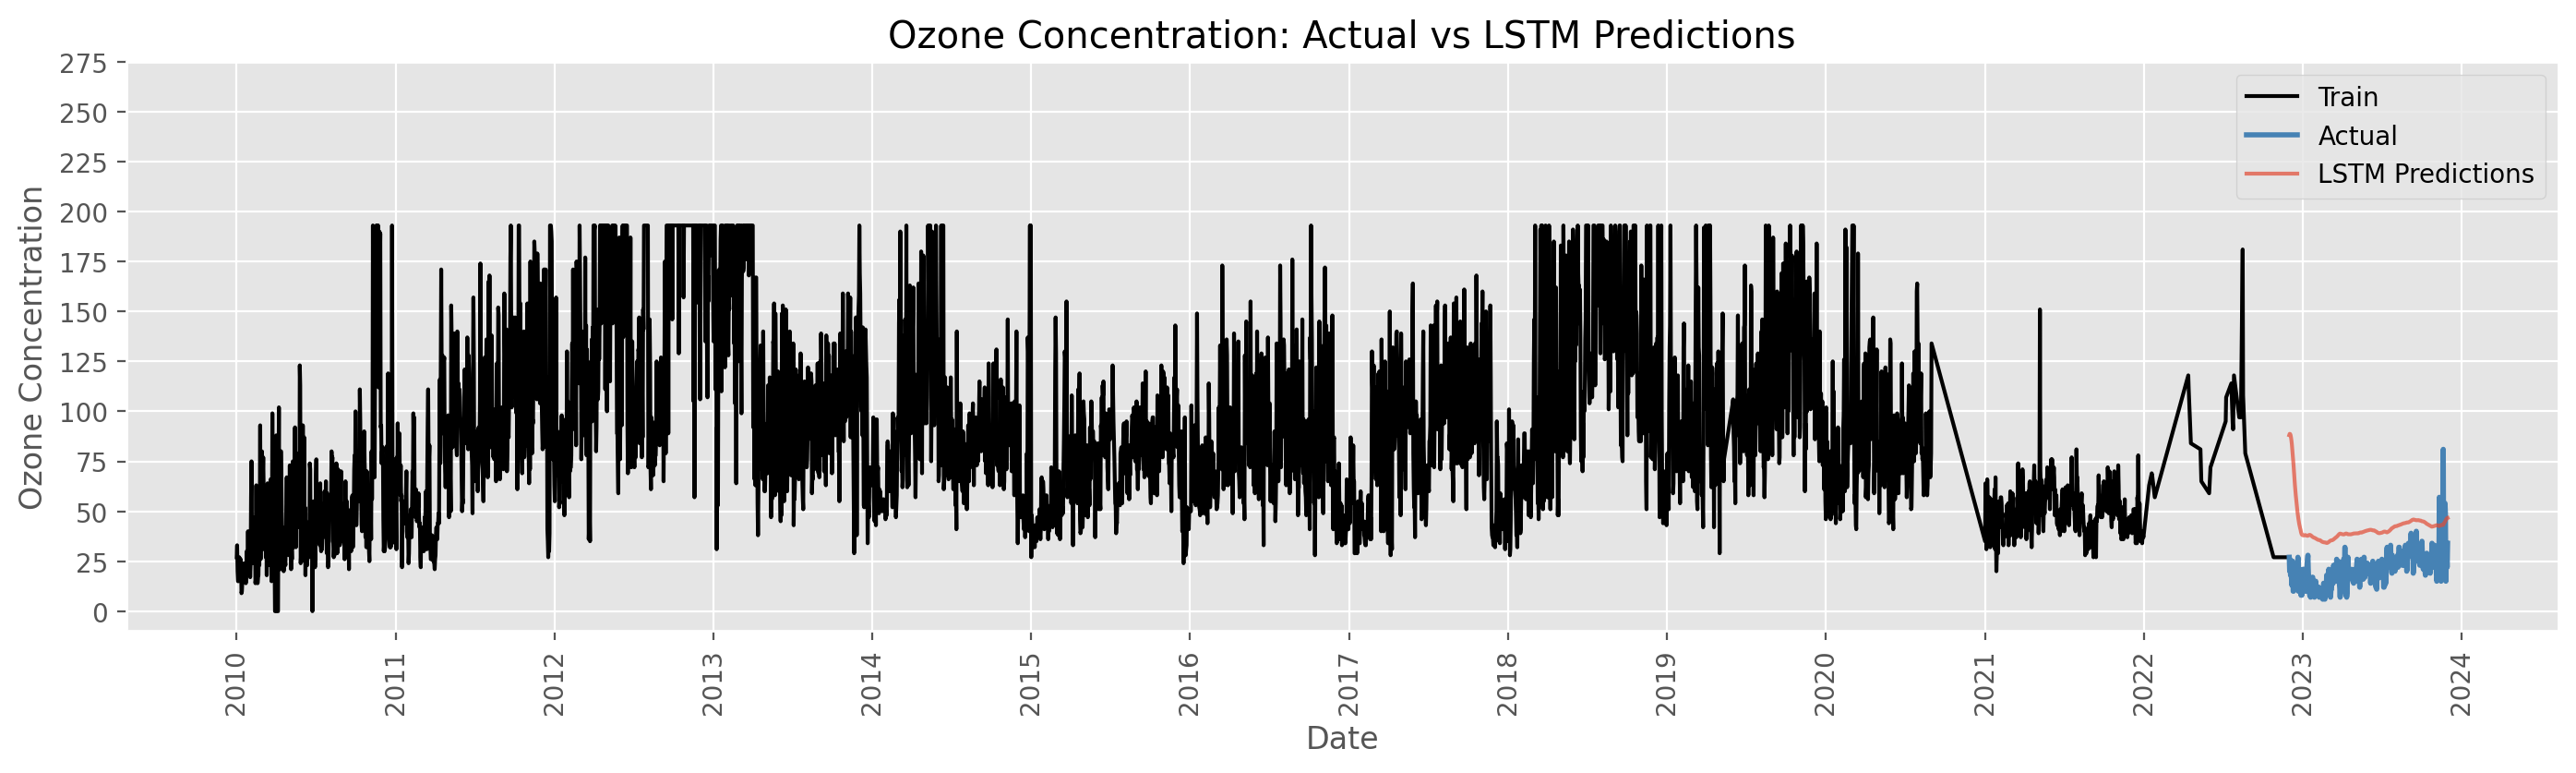

In [796]:
# plot results
plt.figure(figsize=(17, 4), dpi=200)
plt.plot(df.index, df['o3'], color='black', label='Train')
plt.plot(df.index[-len(y_test):], scaler.inverse_transform(y_test), 
         label='Actual', linewidth=2, color='steelblue')
plt.plot(df.index[-len(y_test):], lstm_predictions, 
         label='LSTM Predictions', alpha=0.7)
plt.yticks(range(0, 300, 25))
plt.title('Ozone Concentration: Actual vs LSTM Predictions')
plt.xlabel('Date')
plt.ylabel('Ozone Concentration')
plt.gca().xaxis.set_major_locator(mdates.YearLocator())          # set tick locations to every year
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # format ticks as year

plt.xticks(rotation=90, ha='center')
plt.legend()
plt.show()

<span style='color:red'>Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Ut enim ad minim veniam, quis nostrud exercitation ullamco laboris nisi ut aliquip ex ea commodo consequat. Duis aute irure dolor in reprehenderit in voluptate velit esse cillum dolore eu fugiat nulla pariatur. Excepteur sint occaecat cupidatat non proident, sunt in culpa qui officia deserunt mollit anim id est laborum.</span>

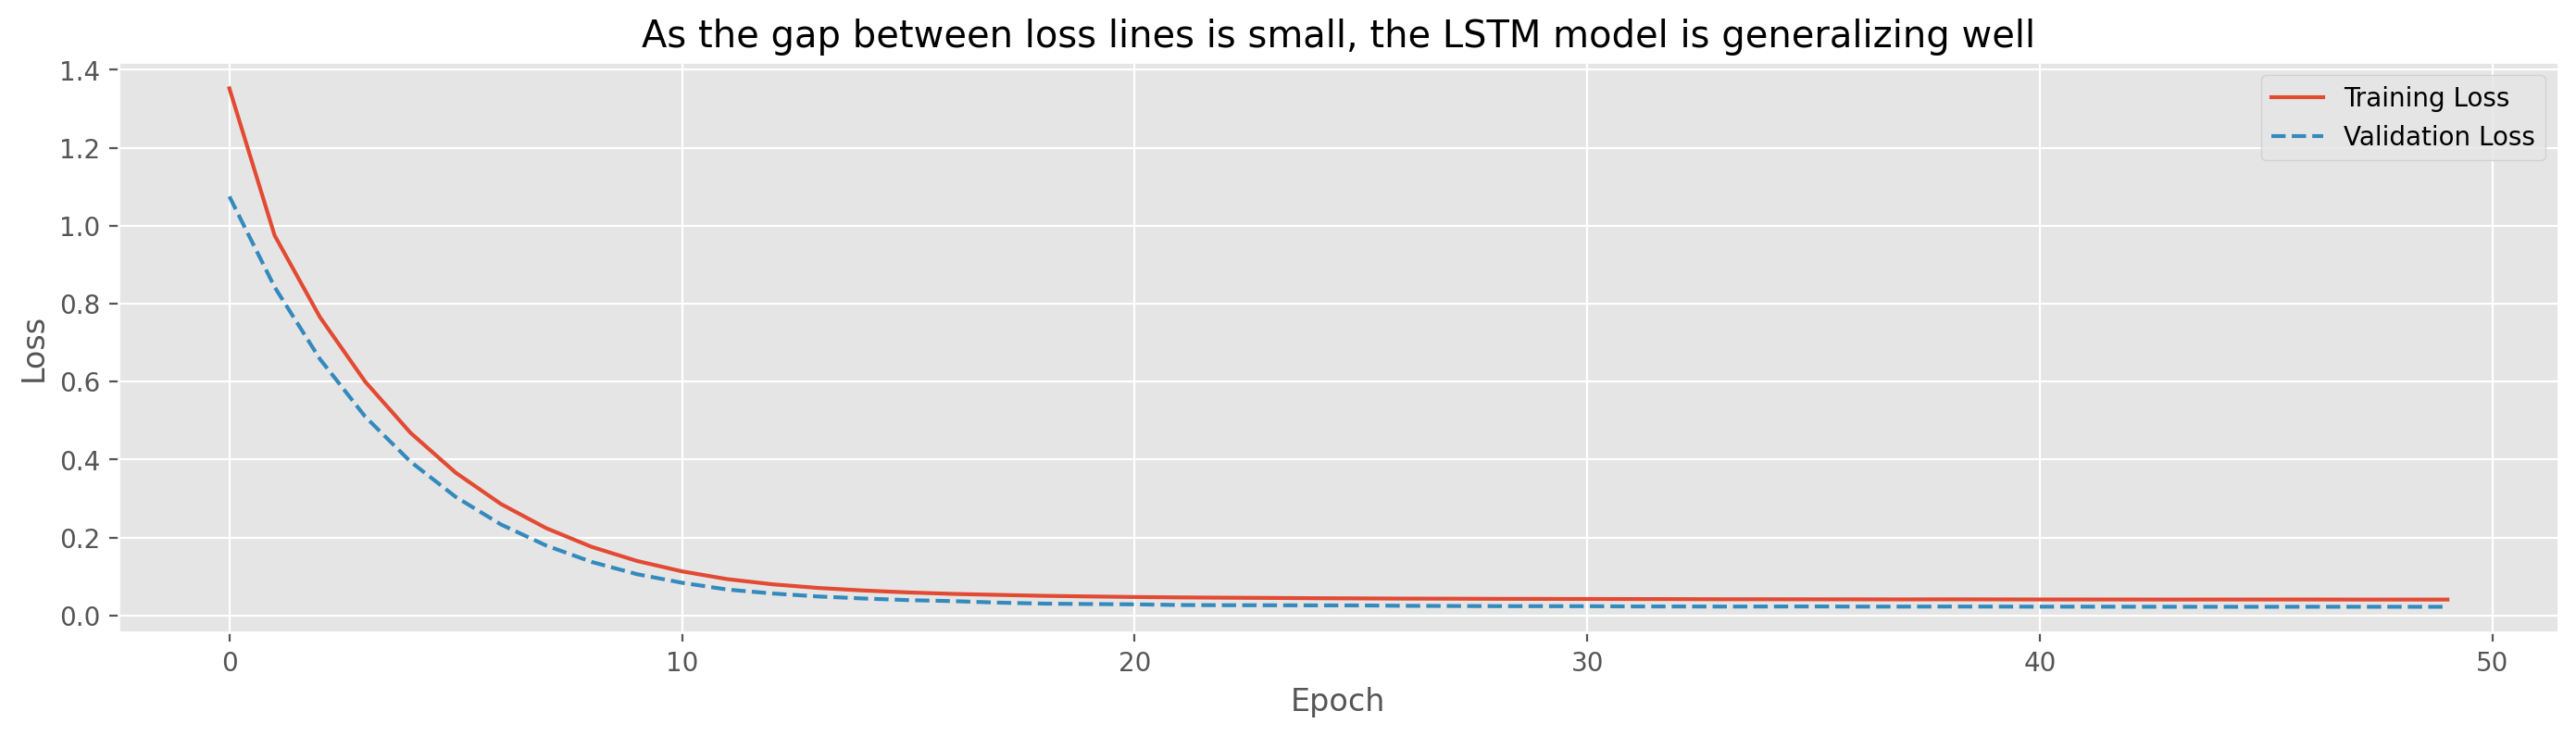

In [797]:
# plot training history
plt.figure(figsize=(17, 4), dpi=200)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss', linestyle='--')
# plt.yticks(np.arange(0, 1.1, 0.1))
plt.title('As the gap between loss lines is small, the LSTM model is generalizing well')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

**Note**
- Both the training and validation losses decrease sharply initially and then level off, closely following each other throughout the epochs.
- The close alignment of training and validation losses at a low level indicates that the model is learning effectively and generalizing well to the validation data.
- Given the close alignment between two lines, the model does not undergo overfitting.

## **4 Final Model Evaluation**
<span style='color:red'>Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Ut enim ad minim veniam, quis nostrud exercitation ullamco laboris nisi ut aliquip ex ea commodo consequat. Duis aute irure dolor in reprehenderit in voluptate velit esse cillum dolore eu fugiat nulla pariatur. Excepteur sint occaecat cupidatat non proident, sunt in culpa qui officia deserunt mollit anim id est laborum.</span>

### **4.1 Model Selection**

In [798]:
# compare RMSE valus
print(f"RMSE of ARIMA: {rmse_arima:.2f}")
print(f"RMSE of AutoARIMA: {rmse_autoarima:.2f}")
print(f'RMSE of Prophet: {rmse_prophet:.2f}')
print(f"RMSE of LSTM: {lstm_rmse:.2f}")
min_v, max_v = df['o3'].min(), df['o3'].max()
print(f"Reference: Range of ozone concentration is between {min_v} and {max_v} ppm")

RMSE of ARIMA: 63.20
RMSE of AutoARIMA: 59.35
RMSE of Prophet: 13.05
RMSE of LSTM: 24.31
Reference: Range of ozone concentration is between 0.0 and 193.0 ppm


**Note**
- Before selecting which model to choose, let me briefly point out the models. The first model is ARIMA model with order (1,1,1). As the first experiment yielded a poor model performance, another ARIMA model was set up with order (3,1,1). The output of the second experiment remained poor performance despite a reduction of RMSE value by 0.85. The third experiment utilized Prophet from Facebook, resulting a minimum RMSE value, i.e., 13.05. Since this model could achieve such RMSE, a Recurrent Neural Network model, especially Long Short-Term Memory, was experimented to see whether this variant of RNN could outperform the Prophet model. 
- However, because the RMSE value of the LSTM model was larger than the Prophet model, the Prophet model is considered as the final model in this project.

### **4.2 Final Model evaluation**
<span style='color:red'>Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Ut enim ad minim veniam, quis nostrud exercitation ullamco laboris nisi ut aliquip ex ea commodo consequat. Duis aute irure dolor in reprehenderit in voluptate velit esse cillum dolore eu fugiat nulla pariatur. Excepteur sint occaecat cupidatat non proident, sunt in culpa qui officia deserunt mollit anim id est laborum.</span>

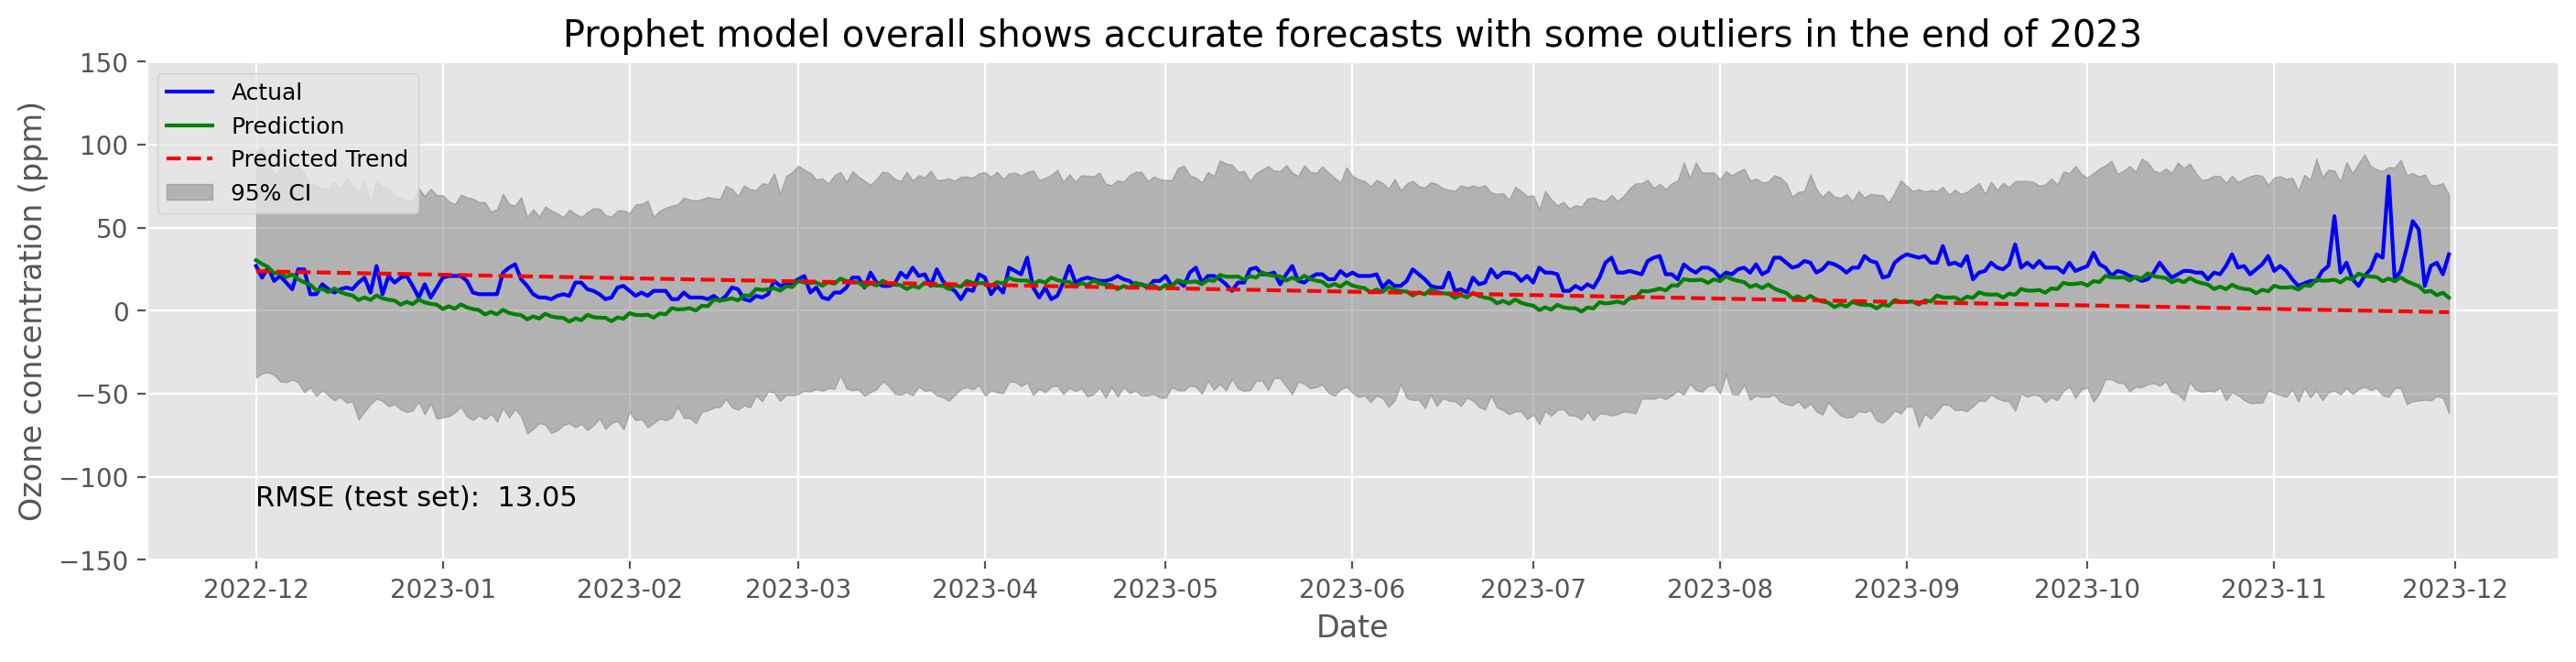

In [828]:
plt.figure(figsize=(17, 4), dpi=200)
plt.plot(test_df['ds'], test_df['y'], color='blue', label='Actual')
plt.plot(forecast_df['ds'], forecast_df['yhat'], color='green', label='Prediction')
plt.plot(forecast_df['ds'], forecast_df['trend'], color='red', label='Predicted Trend', linestyle='--')
plt.fill_between(forecast_df['ds'], forecast_df['yhat_lower'], 
                 forecast_df['yhat_upper'], color='grey', alpha=0.5, label='95% CI')
plt.text(x=0.045, y=0.15, s=f"RMSE (test set):  {rmse_prophet:.2f}", transform=plt.gca().transAxes,
         fontsize=11, verticalalignment='top', horizontalalignment='left', color='black')
# plt.scatter(pd.to_datetime('2023-11-20'), 78,
#             color='red', s=200, facecolors='none', edgecolors='black', linewidths=2)
# plt.text(x=0.91, y=0.85, s='61.55', transform=plt.gca().transAxes,
#          fontsize=11, verticalalignment='top', horizontalalignment='left', color='black')
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())  
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gcf().autofmt_xdate()
plt.xticks(rotation=0, ha='center')
plt.xlabel('Date')
plt.ylabel('Ozone concentration (ppm)')
plt.title('Prophet model overall shows accurate forecasts with some outliers in the end of 2023')
plt.yticks(range(-150, 200, 50))
plt.legend(loc='upper left', fontsize=9)
plt.show()

**Note**: Just for a reminder, above is the forecasting output of the Prophet model for one-year period (365 days). In brief, the model can predict the concentration of ground-level ozone accurately (minimum RMSE) but there are several outliers present at the end of the predictions. To explain how the model makes predictions on ozone concentration in Jakarta, I explain the model by identifying the model forecasting components, change points, and residuals. The components serve to indicate how the components make the model forecast as it is; the change points illustrate the trend shift affecting the general patterns of the predictions; and last, residuals are noise which cannot be explained by the model. Ideally, the smaller the residuals, the better the forecasts are.

#### **4.2.1 Model Components**
In this subsection I will explain how the model works by decompose the trend components. The trend decomposition will cover general trend, yearly and weekly trends. The trend components provides an understanding of changes in the overall direction of the data. It reflects the model's behavior in handling long term changes. Yearly seasonality captures repeating patterns occurring annually. This will shed light on the annual cycle in the data which reflect seasonal behavior, e.g., increased pollution during specific month. And weekly seasinality indicates weekly cycle.

In [800]:
# create plots
fig_components = plot_components_plotly(prophet_model, forecast_df)

fig_components.update_layout(
    autosize=False,
    width=1200, 
    height=600,  
    title_text='Components of Prophet Model\'s Forecasts',  
    title_x=0.5,  
    title_font=dict(size=18, family='Arial'), 
    margin=dict(t=50)
)

fig_components.show()

**Note**
- The components for generating final predictions include trend of the ozone concentration series, yearly patterns, and weekly patterns. 
- In general, the trend component appears to be a slightly downward line. This suggests that there is a general decreasing trend over time. This is in line with my previous finding in 2.6 in which year-to-year trend tends to be decreasing.
- The yearly seasonal patterns show annual varriation. In the end of the year, there are higher ozone concentrations.
- Thee weekly components indicate variations occurring on different days of the week. Overall, the line chart indicates an increase with a peak on Wednesday before plateauing till the end of the week.

#### **4.2.2 Change Points**
Change points generally identifies points in time where the trend of time series changes significantly. It shows where and how the model adapts to sudden changes in the time series. For the records, the plot will show vertical lines where the significant change is detected. The magnitude of shift is presented in a bar chart following the change point plot. In short the larger change point indicates a more substantial shift in trend. 

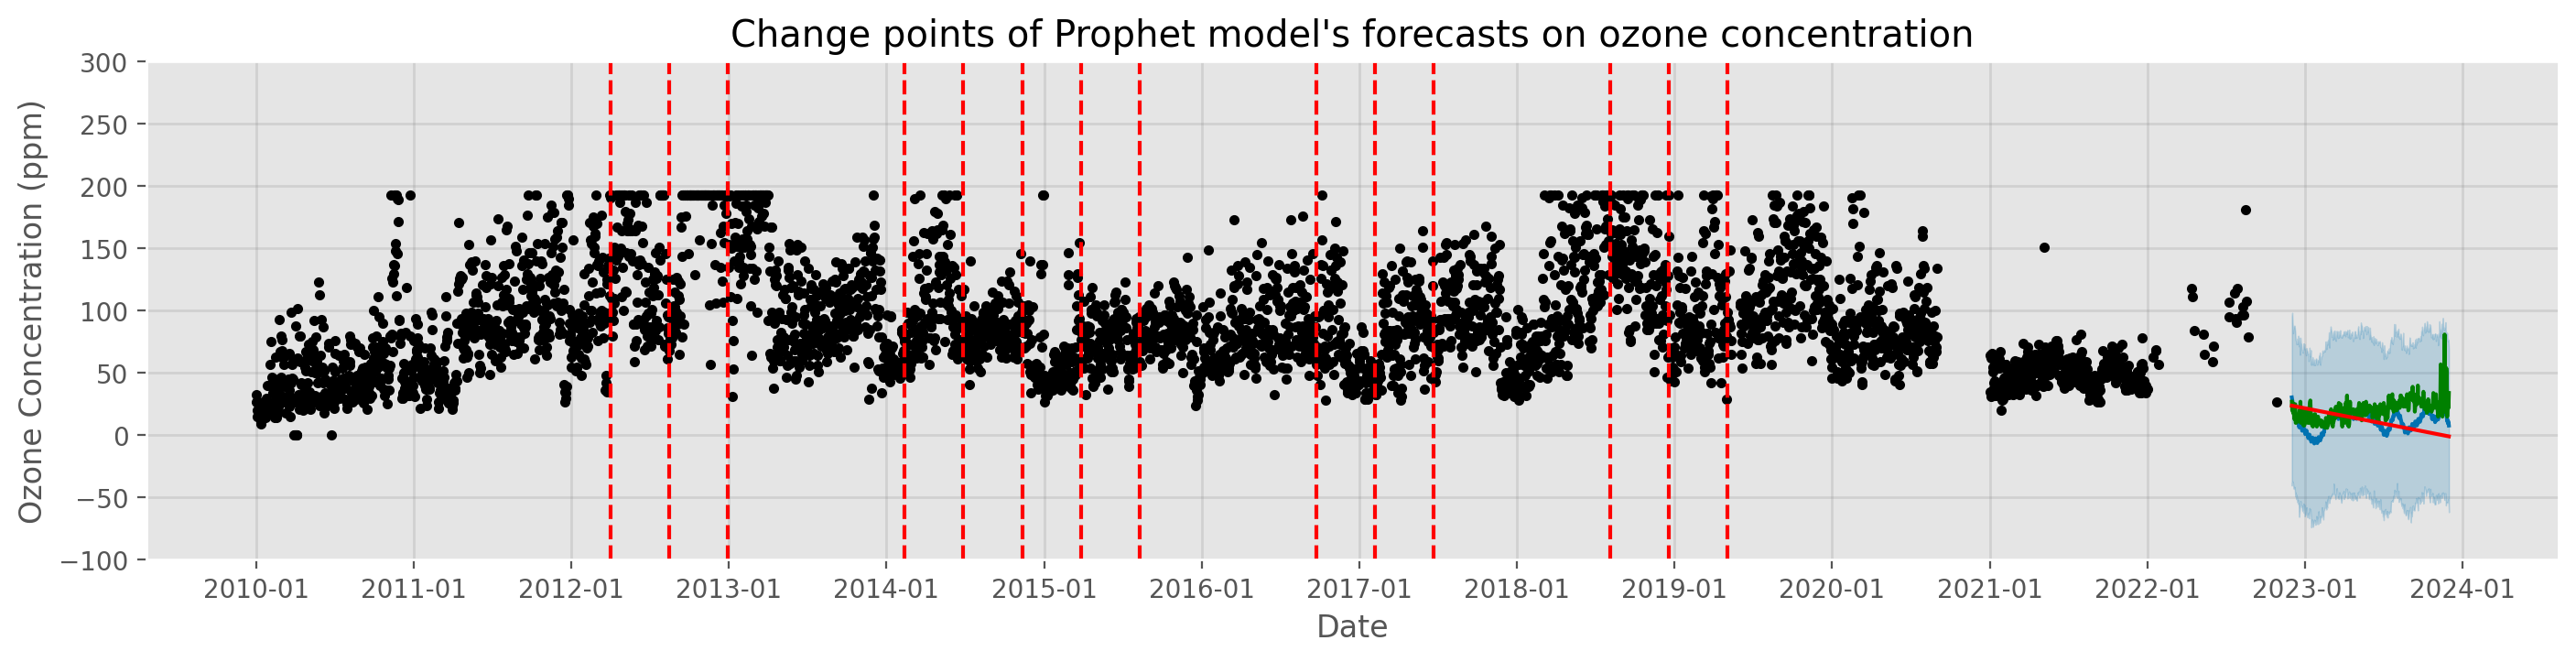

In [801]:
fig, ax = plt.subplots(figsize=(17, 4), dpi=200)

# plot the forecast 
prophet_model.plot(forecast_df, ax=ax)
ax.plot(test_df['ds'], test_df['y'], color='green', label='Actual')
adding_changepoints = add_changepoints_to_plot(ax, prophet_model, forecast_df)

# set 12 month step
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=12)) 
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gcf().autofmt_xdate()

ax.set_title('Change points of Prophet model\'s forecasts on ozone concentration')
ax.set_xlabel('Date')
ax.set_ylabel('Ozone Concentration (ppm)')
ax.set_yticks(range(-100, 350, 50))
plt.setp(ax.get_xticklabels(), rotation=0, ha="center")
plt.show()

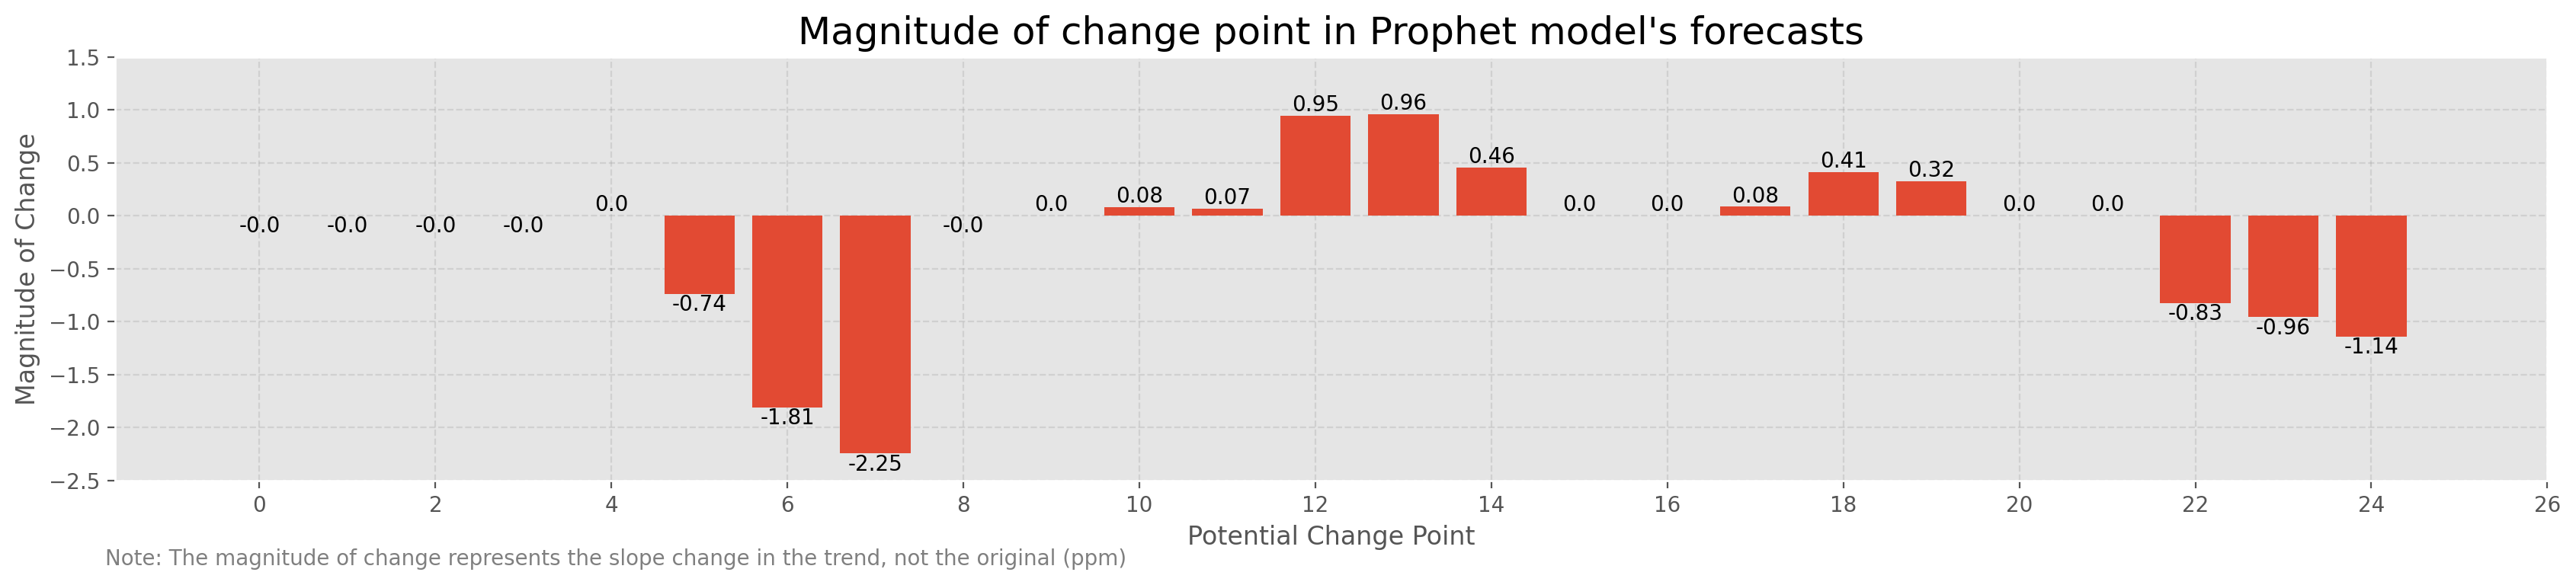

In [829]:
# check magnitude of change point
delta = prophet_model.params['delta'].mean(0) 
plot = plt.figure(facecolor='w', figsize=(17, 4), dpi=200)
ax = plot.add_subplot(111)
bars = ax.bar(range(len(delta)), delta)

# add data labels 
for bar in bars:
    yval = bar.get_height()
    if yval < 0:
        ax.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2),
                ha='center', va='top', fontsize=10, color='black')
    else:
        ax.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2),
                ha='center', va='bottom', fontsize=10, color='black')
plt.text(-1.75, -3.3, 'Note: The magnitude of change represents the slope change in the trend, not the original (ppm)', 
         size=10, alpha=0.5)
ax.grid(True, which='major', c='grey', ls='--', alpha=0.2)
ax.set_title('Magnitude of change point in Prophet model\'s forecasts', size=18)
ax.set_xlabel('Potential Change Point')
ax.set_ylabel('Magnitude of Change')
ax.set_yticks(np.arange(-2.5, 2, 0.5))
ax.set_xticks(range(0, 28, 2))
plt.tight_layout()
plt.show()

**Note**
- The first plot (change points) identifies when the trend shift occurs while the second one (bar plot) quantifies how significant the shifts are. Understanding these is useful for understanding the overall behavior of the ozone concentration over time and how the model makes its forecasts. 
- Since the change points spread across the timeline, the change points suggest that the ozone concentration trend has experienced multiple shifts either upward or downward over the years.
- The large bars represent more significant changes in the trend. Specifically in the end of the bar chart, three bars show downward. These are in line with the overall trend predicted by the model.

### **4.2.3 Residuals**
<span style='color:red'>Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Ut enim ad minim veniam, quis nostrud exercitation ullamco laboris nisi ut aliquip ex ea commodo consequat. Duis aute irure dolor in reprehenderit in voluptate velit esse cillum dolore eu fugiat nulla pariatur. Excepteur sint occaecat cupidatat non proident, sunt in culpa qui officia deserunt mollit anim id est laborum.</span>

In [803]:
# combine actual and predicted values
prophet_predictions = (pd.merge(test_df, 
                                forecast_df.loc[:, ['ds', 'trend', 'yhat_upper', 'yhat_lower', 'yhat']], 
                                on='ds').round(2))
prophet_predictions = prophet_predictions.loc[:, ['ds', 'trend', 'y', 'yhat', 'yhat_lower', 'yhat_upper']]

# get residuals
prophet_predictions['resid'] = prophet_predictions['y'] - prophet_predictions['yhat']
prophet_predictions.head()

ds  trend     y   yhat  yhat_lower  yhat_upper  resid
0 2022-12-01  23.82  27.0  30.46      -40.38       95.37  -3.46
1 2022-12-02  23.75  20.0  28.26      -37.59       98.45  -8.26
2 2022-12-03  23.68  26.0  26.42      -37.11       89.68  -0.42
3 2022-12-04  23.62  18.0  22.53      -38.61       81.97  -4.53
4 2022-12-05  23.55  21.0  22.93      -42.48       85.84  -1.93

**Note**: Forecast error (residual) is added to the dataframe. In geneeral, residual is the difference between $\text{expected value} - \text{predicted value}$ (see Brownlee, 2020, p. 154).

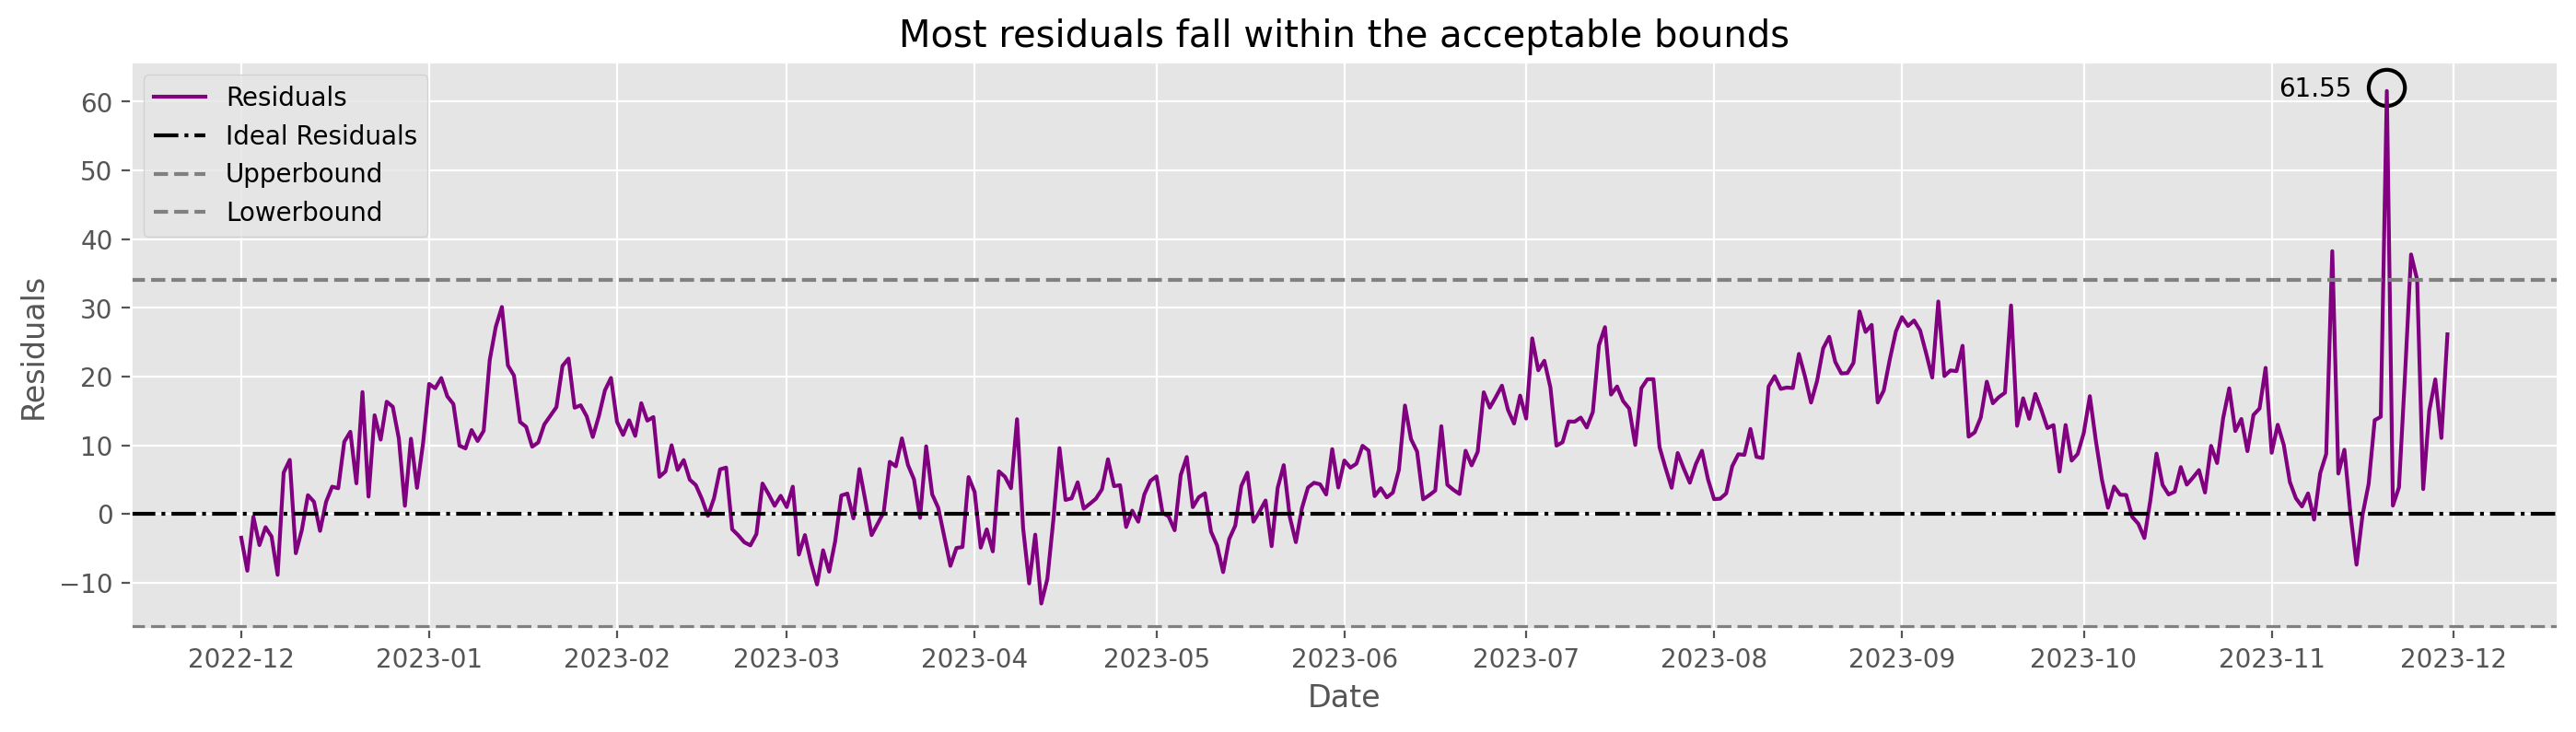

In [830]:
# plot residuals
plt.figure(figsize=(17, 4), dpi=200)
plt.plot(prophet_predictions['ds'], prophet_predictions['resid'], label='Residuals', color='purple')
plt.scatter(pd.to_datetime('2023-11-20'), 62,
            color='red', s=200, facecolors='none', edgecolors='black', linewidths=1.5)
plt.text(x=0.885, y=0.975, s='61.55', transform=plt.gca().transAxes,
         fontsize=10, verticalalignment='top', horizontalalignment='left', color='black')
plt.axhline(y=0, color='black', linestyle='-.', label='Ideal Residuals') 
plt.axhline(y=upper_bound, color='grey', linestyle='--', label='Upperbound') 
plt.axhline(y=lower_bound, color='grey', linestyle='--', label='Lowerbound') 
plt.gca().xaxis.set_major_locator(mdates.MonthLocator()) 
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.title('Most residuals fall within the acceptable bounds')
plt.legend(loc='upper left')
plt.show()

In [805]:
Q1 = prophet_predictions['resid'].quantile(0.25)
Q3 = prophet_predictions['resid'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers = prophet_predictions.loc[(prophet_predictions['resid'] < lower_bound) |
                                   (prophet_predictions['resid'] > upper_bound)]
num_outliers = len(outliers)
total_rows = len(prophet_predictions)
print(f"The number of outliers is {num_outliers} or {(num_outliers/total_rows * 100):.2f}% of the total data ({total_rows} rows).")
display(outliers)

The number of outliers is 4 or 1.10% of the total data (365 rows).


ds  trend     y   yhat  yhat_lower  yhat_upper  resid
345 2023-11-11   0.45  57.0  18.76      -48.09       84.42  38.24
354 2023-11-20  -0.16  81.0  19.45      -51.89       86.58  61.55
358 2023-11-24  -0.43  54.0  16.24      -54.40       82.85  37.76
359 2023-11-25  -0.50  49.0  14.90      -54.07       80.97  34.10

In [813]:
# get kurtosis and skewness
kurt_value = kurtosis(prophet_predictions['resid'])
skw_value = skew(prophet_predictions['resid'])

# compute stat summary
print('Descriptive stats for residuals:')
display(prophet_predictions['resid'].describe().to_frame().T.round(2))
print('Descriptive stats for actual values:')
display(df['o3'].describe().to_frame().transpose())

Descriptive stats for residuals:


count  mean   std    min   25%   50%    75%    max
resid  365.0  8.91  9.55 -13.03  2.53  7.78  15.15  61.55

Descriptive stats for actual values:


count       mean       std  min   25%   50%    75%    max
o3  4626.0  85.052313  46.28439  0.0  51.0  78.0  110.0  193.0

<span style='color:red'>Jelasin apakah rentang segitu residualsnya gede atau enggak</span>

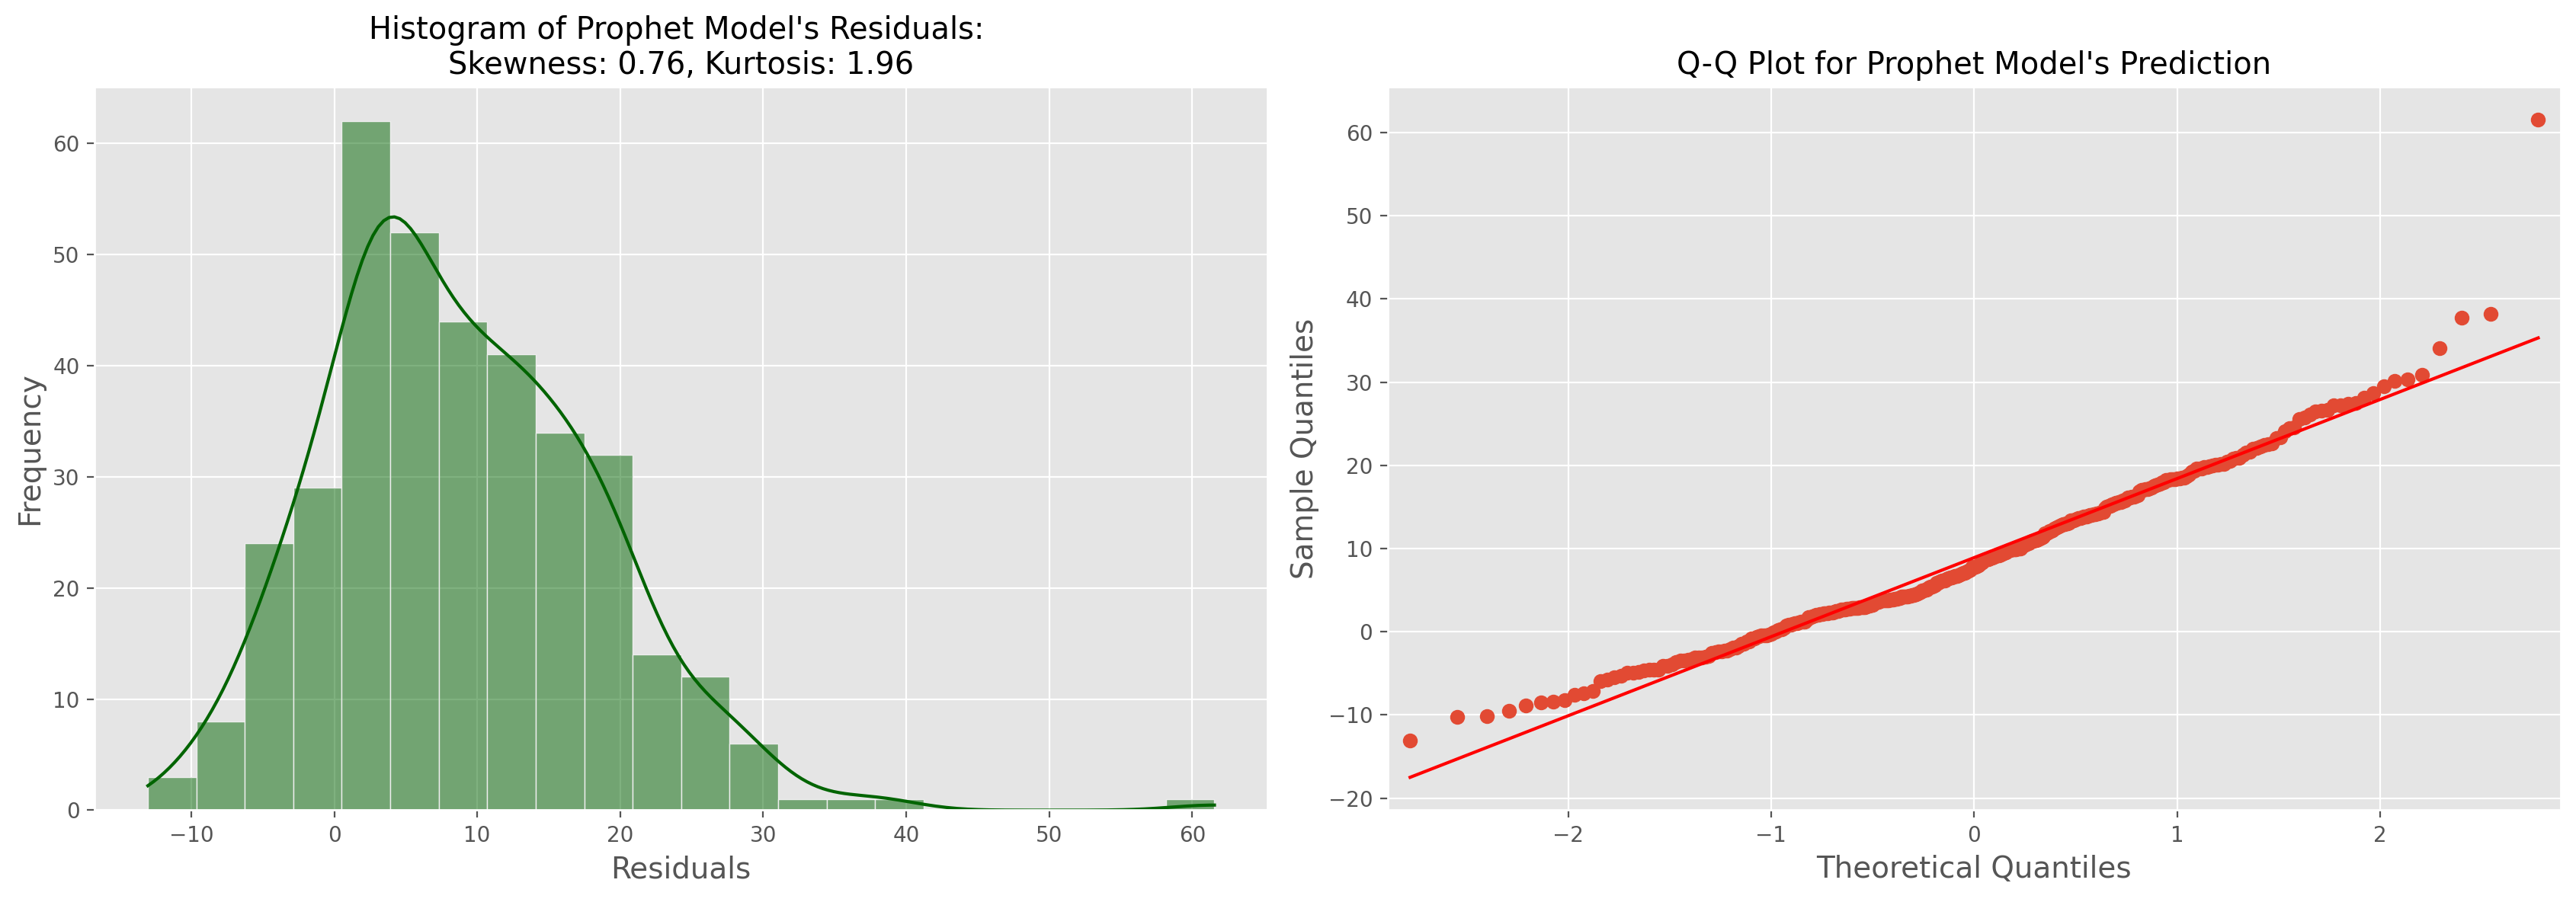

In [807]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17, 6), dpi=200)

# histogram on the left
sns.histplot(x=prophet_predictions['resid'], kde=True, color='darkgreen', ax=ax1)
ax1.set_title(f'Histogram of Prophet Model\'s Residuals: \nSkewness: {skw_value:.2f}, Kurtosis: {kurt_value:.2f}')
ax1.set_xlabel('Residuals', size=14)
ax1.set_ylabel('Frequency', size=14)

# Q-Q plot on the right
qqplot(prophet_predictions['resid'], line='r', ax=ax2)
ax2.set_title('Q-Q Plot for Prophet Model\'s Prediction')
ax2.set_xlabel('Theoretical Quantiles', size=14)
ax2.set_ylabel('Sample Quantiles', size=14)

plt.tight_layout()
plt.show()

**Note**
- While the Q-Q plot shows some evidence of normality, the deviations in the tails suggest that the residuals might not be perfectly normally distributed. This could indicate that the Prophet model may not be capturing all the important aspects of the data or that there might be some outliers or other non-normal patterns.
- Based on both plots, the Prophet model seems to be performing reasonably well. The residuals are generally normally distributed, with some deviations in the tails. The skewness and kurtosis values are not too extreme, suggesting that the model is capturing the main patterns in the data.

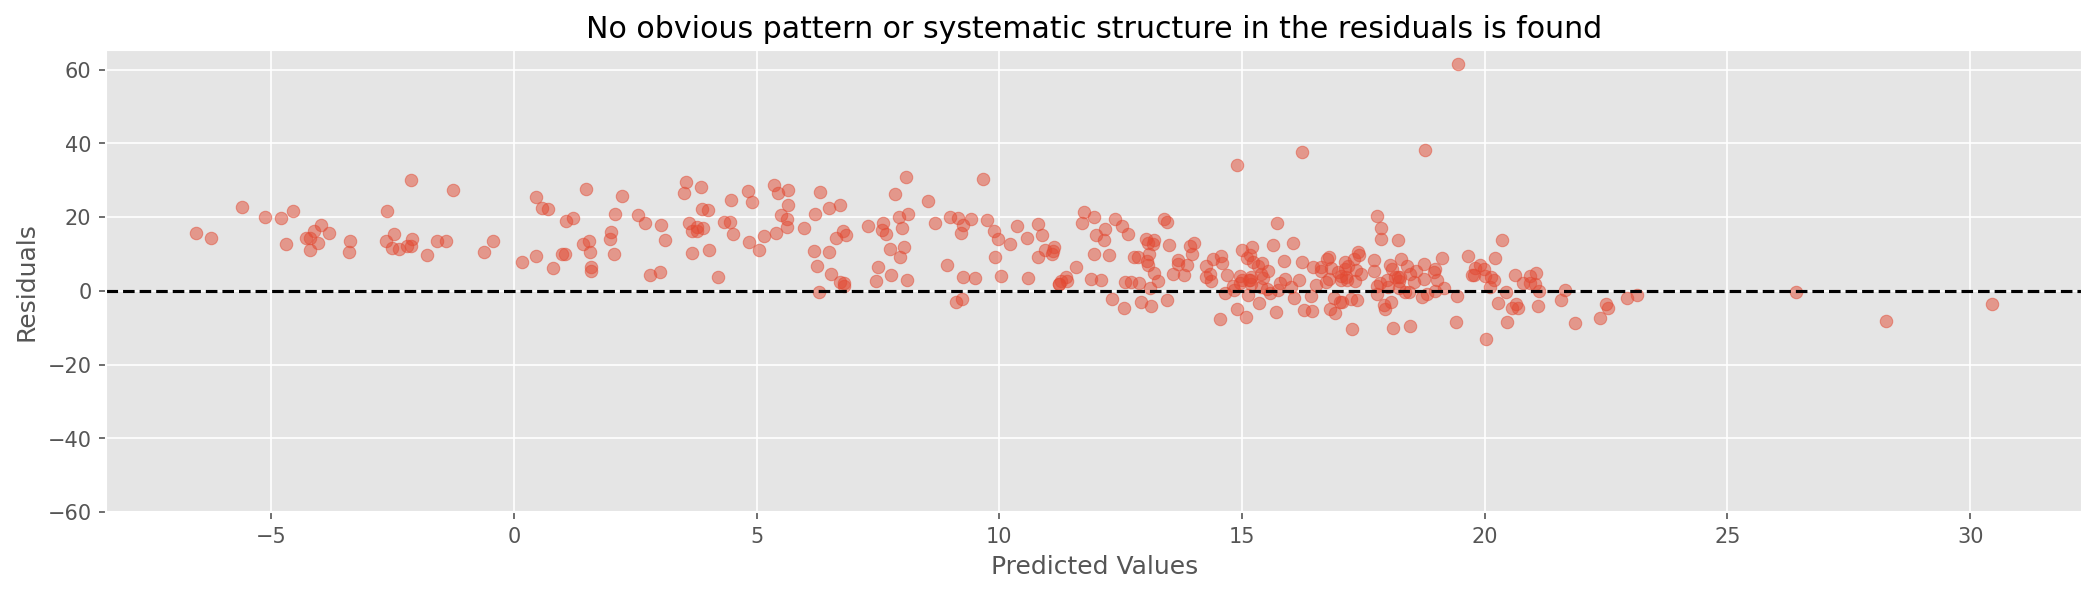

In [808]:
plt.figure(figsize=(17, 4), dpi=150)
plt.scatter(prophet_predictions['yhat'], prophet_predictions['resid'], alpha=0.5)
plt.axhline(y=0, color='black', linestyle='--')
plt.yticks(range(-60, 70, 20))
plt.title('No obvious pattern or systematic structure in the residuals is found')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()

**Note**: The residuals are scattered around the zero line, indicating the model's predictions are not biased (random distribution of the errors). The spread of the residuals are also consistent across different levels of fitted values, indicating constant variance of residuals (homoscedasticity). Just for the record, residuals with heteroscedasticity usually show a funnel-shaped patterns, indicating the spread of the residuals increases, as the predicted values increase.

In [809]:
# fit a linear model on the residuals
X = sm.add_constant(prophet_predictions['yhat'])
y = prophet_predictions['resid']
model = sm.OLS(y, X).fit()

# perform Breusch-Pagan test
test_results = het_breuschpagan(model.resid, model.model.exog)
lm_stat, lm_pvalue, f_stat, f_pvalue = test_results
print(f'Breusch-Pagan test statistic: {lm_stat:.4f}, with p-value: {lm_pvalue:.4f}')

Breusch-Pagan test statistic: 0.5837, with p-value: 0.4448


**Note**: Because the *p*-value (0.445) is greater than threshold at 0.05, the value suggests that there is no significant evidence of heteroscedasticity in model residuals. This result means that the residuals appear to have constant variance, and heteroscedasticity is not a major concern based on this test.

## **5 Conclusions**
### **5.1 Summary**
<span style='color:red'>Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Ut enim ad minim veniam, quis nostrud exercitation ullamco laboris nisi ut aliquip ex ea commodo consequat. Duis aute irure dolor in reprehenderit in voluptate velit esse cillum dolore eu fugiat nulla pariatur. Excepteur sint occaecat cupidatat non proident, sunt in culpa qui officia deserunt mollit anim id est laborum.</span>

### **5.2 Recommendations**
<span style='color:red'>Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Ut enim ad minim veniam, quis nostrud exercitation ullamco laboris nisi ut aliquip ex ea commodo consequat. Duis aute irure dolor in reprehenderit in voluptate velit esse cillum dolore eu fugiat nulla pariatur. Excepteur sint occaecat cupidatat non proident, sunt in culpa qui officia deserunt mollit anim id est laborum.</span>

In [810]:
# save model
joblib.dump(prophet_model, '../model/final_model.pkl')

['../model/final_model.pkl']

## **6 References**
- Brownlee, J. (2017). *Introduction to time series forecasting with python: how to prepare data and develop models to predict the future*. Machine Learning Mastery.
- Kumar, U., & Jain, V. K. (2010). ARIMA forecasting of ambient air pollutants (O 3, NO, NO 2 and CO). *Stochastic Environmental Research and Risk Assessment*, 24, 751-760.
- Lee, H. Y., Beh, W. L., & Lem, K. H. (2023). Forecasting with information extracted from the residuals of ARIMA in financial time series using continuous wavelet transform. *International Journal of Business Intelligence and Data Mining*, 22(1-2), 70-99.

<h1 style='text-align:center; font-weight:bold; color:orange'>--END--</h1>